In [442]:
# from google.colab import drive
# drive.mount('/content/drive')

In [443]:
# # navigate to root directory of current file in order to access other files relatively
# %cd /content/drive/MyDrive/Colab\ Notebooks/thesis-writing-1/eda-signal-classifier

In [444]:
# !pip install tqdm
# !pip install PyWavelets
# !pip install scipy

In [445]:
import datetime
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, lfilter, firwin, hilbert, sosfiltfilt
from scipy.stats import entropy
from scipy.ndimage import median_filter
from scipy.interpolate import interp1d, splrep, UnivariateSpline#, spline
import pywt
from tqdm import tqdm

from utilities.feature_extractors import _compute_vfcdm_feats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [446]:
# with zipfile.ZipFile('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/EDABE dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)')

In [447]:
# os.remove('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Train/')
# os.remove('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Test/')

In [448]:
raw_eda_df = pd.read_csv('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Test/oxused_expert2.csv', sep=';')
raw_eda_df

time   rawdata  cleandata  binarytarget  signal_automatic  \
0          0.000000  0.000000  -0.091119           0.0          0.000000   
1          0.007812  0.000000  -0.091119           0.0          0.000000   
2          0.015625  0.000000  -0.091119           0.0          0.000000   
3          0.023438  0.000000  -0.091119           0.0          0.000000   
4          0.031250  0.000000  -0.091119           0.0          0.000000   
...             ...       ...        ...           ...               ...   
765040  5976.875000  0.011766   0.011766           0.0          0.011766   
765041  5976.882812  0.011322   0.011322           0.0          0.011322   
765042  5976.890625  0.011322   0.011322           0.0          0.011322   
765043  5976.898438  0.011766   0.011766           0.0          0.011766   
765044  5976.906250  0.011322   0.011322           0.0          0.011322   

        PredArtifacts  PostProcessedPredArtifacts  
0                 0.0                         0.0  
1                 0.0                         0.0  
2                 0.0                         0.0  
3                 0.0                         0.0  
4                 0.0                         0.0  
...               ...                         ...  
765040            0.0                         0.0  
765041            0.0                         0.0  
765042            0.0                         0.0  
765043            0.0                         0.0  
765044            0.0                         0.0  

[765045 rows x 7 columns]

In [449]:
raw_eda_df.rename(columns={
    'rawdata': 'raw_signal',
    'cleandata': 'clean_signal',
    'binarytarget': 'label',
    'signal_automatic': 'auto_signal',
    'PredArtifacts': 'pred_art',
    'PostProcessedPredArtifacts': 'post_proc_pred_art'}, inplace=True)
raw_eda_df

time  raw_signal  clean_signal  label  auto_signal  pred_art  \
0          0.000000    0.000000     -0.091119    0.0     0.000000       0.0   
1          0.007812    0.000000     -0.091119    0.0     0.000000       0.0   
2          0.015625    0.000000     -0.091119    0.0     0.000000       0.0   
3          0.023438    0.000000     -0.091119    0.0     0.000000       0.0   
4          0.031250    0.000000     -0.091119    0.0     0.000000       0.0   
...             ...         ...           ...    ...          ...       ...   
765040  5976.875000    0.011766      0.011766    0.0     0.011766       0.0   
765041  5976.882812    0.011322      0.011322    0.0     0.011322       0.0   
765042  5976.890625    0.011322      0.011322    0.0     0.011322       0.0   
765043  5976.898438    0.011766      0.011766    0.0     0.011766       0.0   
765044  5976.906250    0.011322      0.011322    0.0     0.011322       0.0   

        post_proc_pred_art  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
765040                 0.0  
765041                 0.0  
765042                 0.0  
765043                 0.0  
765044                 0.0  

[765045 rows x 7 columns]

In [450]:
raw_eda_df.iloc[:128]

time  raw_signal  clean_signal  label  auto_signal  pred_art  \
0    0.000000    0.000000     -0.091119    0.0     0.000000       0.0   
1    0.007812    0.000000     -0.091119    0.0     0.000000       0.0   
2    0.015625    0.000000     -0.091119    0.0     0.000000       0.0   
3    0.023438    0.000000     -0.091119    0.0     0.000000       0.0   
4    0.031250    0.000000     -0.091119    0.0     0.000000       0.0   
..        ...         ...           ...    ...          ...       ...   
123  0.960938    0.005550      0.005550    0.0     0.005550       0.0   
124  0.968750    0.005550      0.005550    0.0     0.005550       0.0   
125  0.976562    0.005550      0.005550    0.0     0.005550       0.0   
126  0.984375    0.005550      0.005550    0.0     0.005550       0.0   
127  0.992188    0.005994      0.005994    0.0     0.005994       0.0   

     post_proc_pred_art  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
..                  ...  
123                 0.0  
124                 0.0  
125                 0.0  
126                 0.0  
127                 0.0  

[128 rows x 7 columns]

In [451]:
raw_eda_df.iloc[:640:64]

time  raw_signal  clean_signal  label  auto_signal  pred_art  \
0     0.0    0.000000     -0.091119    0.0     0.000000       0.0   
64    0.5    0.009546      0.009546    0.0     0.009546       0.0   
128   1.0    0.005550      0.005550    0.0     0.005550       0.0   
192   1.5    0.008214      0.008214    0.0     0.008214       0.0   
256   2.0    0.007770      0.007770    0.0     0.007770       0.0   
320   2.5    0.008214      0.008214    0.0     0.008107       1.0   
384   3.0    0.008214      0.008214    0.0     0.008115       1.0   
448   3.5    0.006882      0.006882    0.0     0.007889       0.0   
512   4.0    0.007770      0.007770    0.0     0.007979       0.0   
576   4.5    0.008214      0.008214    0.0     0.008030       1.0   

     post_proc_pred_art  
0                   0.0  
64                  0.0  
128                 0.0  
192                 0.0  
256                 0.0  
320                 1.0  
384                 1.0  
448                 1.0  
512                 1.0  
576                 1.0

In [452]:
raw_eda_df.iloc[:640]

time  raw_signal  clean_signal  label  auto_signal  pred_art  \
0    0.000000     0.00000     -0.091119    0.0     0.000000       0.0   
1    0.007812     0.00000     -0.091119    0.0     0.000000       0.0   
2    0.015625     0.00000     -0.091119    0.0     0.000000       0.0   
3    0.023438     0.00000     -0.091119    0.0     0.000000       0.0   
4    0.031250     0.00000     -0.091119    0.0     0.000000       0.0   
..        ...         ...           ...    ...          ...       ...   
635  4.960938     0.00777      0.007770    0.0     0.007806       1.0   
636  4.968750     0.00777      0.007770    0.0     0.007800       1.0   
637  4.976562     0.00777      0.007770    0.0     0.007795       1.0   
638  4.984375     0.00777      0.007770    0.0     0.007818       1.0   
639  4.992188     0.00777      0.007770    0.0     0.007841       1.0   

     post_proc_pred_art  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
..                  ...  
635                 1.0  
636                 1.0  
637                 1.0  
638                 1.0  
639                 1.0  

[640 rows x 7 columns]

In [453]:
def which_element(object_list):
    """
    This function only defines and returns the position
    in an array or list where it is a True value.
    e.g. [True, False, true, true, False] -> [0, 2, 3]

    Dependency of find_begin_end()
    """
    result = [i_obj for i_obj, obj in enumerate(object_list) if obj]
    return result

In [454]:

def find_begin_end(x_p):
    """
    This function defines where it is found the first and the last 1 of a sequence of ones (1s)
    in a binary vector where. For example: X = [0, 0, 1, 1, 1, 0, 0, 1, 1]. This function will
    have this as a result: find_begin_end(X) = [2, 7], [4, 8]. It means that at positions 2 and 7
    of X it begins a sequence of 1s. On the other hand, 4 and 8 are the positions where these
    sequences ends. This function is necessary to localize the position of the
    artifacts in the raw binary signal of the target or the prediction.
    """

    # this takes in a boolean numpy array or a dataframe
    # not a list since [1, 0, 1, 0, 0] == 1 for instance
    # would just return false
    # For instance if we had now signals that are labeled as
    # artifacts or non artifacts...
    # >>> signal = np.array([0, 0, 1, 1, 1, 0, 0, 1, 1])
    # >>> signal == 1
    # array([False, False, True, True, True, False, False, True, True])
    # when this is passed through which_element() this will
    # return [2, 3, 4, 7, 8]
    pos_artf_true = which_element(x_p == 1)

    # get the very starting index where an artifact is indeed an artifact
    # which in this case for instance will be 2, start_pos_artf_true is [2]
    start_pos_artf_true = [pos_artf_true[0]]

    # this block finds the begin indices of artifacts in signal
    # pos_artf_true is [3, 4, 7, 8], i is initially 0, p_art_t is initially 3
    for i, p_art_t in enumerate(pos_artf_true[1:]):
        # (3 - 2) > 1 will render false 
        # (4 - 3) > 1 will render false
        # (7 - 4) > 1 will render true
        # (8 - 7) > 1 will render false
        if (p_art_t - pos_artf_true[i]) > 1:
            start_pos_artf_true.append(p_art_t)

    # this will be the block that finds the end indices of artifacts in a signal
    end_pos_artf_true = [p_art_t for i, p_art_t in enumerate(pos_artf_true[:-1]) if (pos_artf_true[i + 1] - p_art_t) > 1]
    end_pos_artf_true.append(pos_artf_true[-1])

    return start_pos_artf_true, end_pos_artf_true

In [455]:
def down_sample(signals: pd.DataFrame | np.ndarray | list, target_freq = 16):
    """
    takes in raw signals x and converts it to another frequency
    via downsampling e.g. 128hz to 16hz
    """
    result = []
    n_rows = signals.shape[0]
    for i in np.arange(n_rows / target_freq):
        result += [np.nanmean(signals[int(i * target_freq):int((i + 1) * target_freq)])]

    return result

In [456]:
eda_df_16hz = down_sample(raw_eda_df, 16)
len(eda_df_16hz)

47816

In [457]:
eda_df_8hz = down_sample(raw_eda_df, 8)
len(eda_df_8hz)

95631

In [458]:
len(down_sample(raw_eda_df, 128))

5977

In [459]:
def view_time_frame(raw_eda_df, samp_freq=128, begin_time_s=1750, end_time_s=1765, cols_to_use=['raw_signal', 'clean_signal', 'auto_signal']):
    """
    ntoe cols to use must be equal to 5 or more
    """
    fig = plt.figure(figsize=(17, 5))

    axis = fig.add_subplot()


    # why is it multiplied by 128?
    # results it 224000 and 225920 and is used as indeces to access a slice of the dataframes rows
    begin_sample, end_sample = begin_time_s * samp_freq, end_time_s * samp_freq

    #
    time_to_plot = raw_eda_df["time"].iloc[begin_sample:end_sample]

    # colors and linestyles to use
    colors = ['#df03fc', '#236cb0', '#fc034e', '#fc8003', '#3dfc03']
    lines = ['dotted', 'solid', 'dashed', 'dashdot', (5, (10, 3))]

    for i, col in enumerate(cols_to_use):
        col_to_plot = raw_eda_df[col].iloc[begin_sample:end_sample]
        axis.plot(time_to_plot, col_to_plot, label=col, alpha=0.75, linestyle=lines[i], c=colors[i])
    # axis.plot(time_to_plot, rawdata_to_plot, label="Raw data")
    # axis.plot(time_to_plot, cleandata_to_plot, label="Manual", c="orange")
    # axis.plot(time_to_plot, autodata_to_plot, label="Automatic", alpha=0.7, linestyle="--", c="red")
    # axis.plot(time_to_plot, autodata_to_plot, label="Automatic", alpha=0.7, linestyle="--", c="red")

    axis.legend(fontsize=14)
    axis.grid()

    axis.set_ylabel(r'$\mu S$', fontsize=16)
    axis.set_xlabel("Time (s)", fontsize=16)

    plt.show()

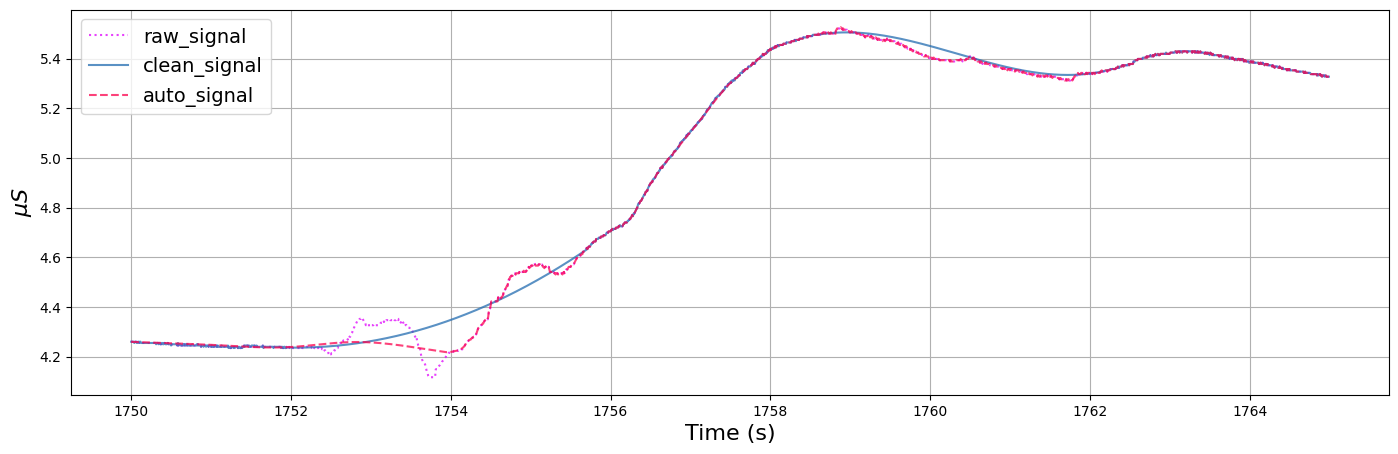

In [460]:
view_time_frame(raw_eda_df, begin_time_s=1750, end_time_s=1765)

Here we attempt to get the raw SCR values from 0 to 5 seconds

In [461]:
begin_time_s, end_time_s = 0, 5
begin_sample, end_sample = begin_time_s * 128, end_time_s * 128
time_to_plot = raw_eda_df["time"].iloc[begin_sample:end_sample]
time_to_plot

0      0.000000
1      0.007812
2      0.015625
3      0.023438
4      0.031250
         ...   
635    4.960938
636    4.968750
637    4.976562
638    4.984375
639    4.992188
Name: time, Length: 640, dtype: float64

## Oh ok so the reason why it is multiplied by 128 is because since these are values in milliseconds that render it a float value and we want the flexibility to choose letsay sa specific time frame of 1750 to 1765 we cant really index the dataframe with a float value but we can convert the time frame value we want such that we are able to use the resulting value as index that matches exactly the time frame we want to access

In [462]:
def charge_raw_data(data: pd.DataFrame | np.ndarray, 
    hertz: int=128, 
    window_time: float | int=5, 
    x_col="raw_signal", 
    target_time=0.5, 
    y_col=None, 
    scale=False,
    verbose: bool=False):
    """
    charge_raw_data" preprocesses the input signal cutting the signal in pieces of 5 seconds.
    In the case that a target is introduced i.e. y_col != None, the target is cut the last 0.5
    seconds of the binary target, becoming the target of the correspondent 5 seconds segement.
    """

    # we access the SCR values via raw data column
    x_signals = data[x_col].values

    # here if we would want to create windows of the raw data including the target label
    # we must specify which target label we want to include since there are multiple columns
    # that pertain to the label I vbelieve which are: binary_target, predicted artifacts
    # and post processed artifacts
    if y_col is not None:
        y_signals = data[y_col].values

    window_size = int(window_time * hertz)
    target_size = int(target_time * hertz)

    x_window_list, y_window_list = [], []

    i = 0
    # so if we have a length of 765045 rows for the raw eda data
    # and in each row we'd have to multiply 128 to get specific seconds e.g.
    # to get 0th second we multiply 128 by 0 and use it as index
    # raw_eda_df['time'].iloc[:128 * 0], to get 1st second mark we'd have
    # to multiply 128 by 1 and use it as index raw_eda_df['time'].iloc[:128 * 1]

    # but what is the point of subtracting 765045 by window size of 640 (5 * 128)?
    print(f'length of x_signals: {len(x_signals)}')
    print(f'window size: {window_size}')

    stop = len(x_signals) - window_size
    while i <= stop:
        # iteration pattern is the following
        # 0 <= 765045 - 640 (764405)
        # 64 <= 765045 - 640
        # 128 <= 765045 - 640
        # 192 <= 765045 - 640
        # 256 <= 765045 - 640
        # 320 <= 765045 - 640
        # ...
        # 764288 <= 765045 - 640
        # 764352 <= 765045 - 640 (764405) we only go until here as 764352 + 64
        # (or another 0.5s segment would result in 764416 which is greater than 764405)  

        # maybe what this truly does is we get 5 seconds of a signal and since there are 128 signals per second
        # we would in total get 640 rows for 5 seconds of our signals

        # oh so this is the denominator part of the min max scaling formula
        # and as stated by llanes-jurado et al. they used min max scaling to scale the raw signals
        # mroeover nanmax and min is used in case of nan values in the windows which returns
        # minimum of an array or minimum along an axis, ignoring any NaNs
        # 0:0 + 640 = 0:640
        # 64:64 + 640 = 64:704
        # 128:128 + 640 = 128:768
        # 192:192 + 640 = 192:832
        # ...
        # 764352:764352 + 640 = 764352:764992
        # if we exceed 764352 by adding 64 then we have 764416
        # 764416:764416 + 640 = 764416:765056 and 765056 exceeds the index and rows of 765045 

        # if scale is true then min max scaling is applied
        if scale == True:
            denominator_norm = (np.nanmax(x_signals[i:(i + window_size)]) - np.nanmin(x_signals[i:(i + window_size)]))
            denominator_norm = denominator_norm + 1e-100 if denominator_norm == 0 else denominator_norm

            # this is full min max scaling formula with the denominator using
            # the difference of the min and max of a window
            # to address also potential zero division concerns
            x_window = (x_signals[i:(i + window_size)] - np.nanmin(x_signals[i:(i + window_size)])) / denominator_norm
        else:
            # this would be appropriate if there was a larger ram
            x_window = x_signals[i:(i + window_size)]

        # we then append these normed signals to a list
        x_window_list.append(x_window)

        # returns the mean of a list or matrix of values given an
        # axis ignoring any nan values. Based on Llanes-Jurado et al. (2023)
        # the threshold for a 0.5s segment of a signal to be accepted as an
        # artifact must be 0.5 or 50% if it is less than this then the label
        # of such a segment of the signal will be not an artifact
        # 0 + 640 - 64:0 + 640 = 576:640
        # 64 + 640 - 64:64 + 640 = 640:704
        # 128 + 640 - 64:128 + 640 = 704:768
        # ...
        # 764288 + 640 - 64:764288 + 640 = 764864:764928
        # 764352 + 640 - 64:764352 + 640 = 764928:764992
        # this iteration pattern now I know just gets the last 0.5s segment of a 5s segment and 
        
        if y_col is not None:
            cond = np.nanmean(y_signals[(i + window_size - target_size):(i + window_size)]) > 0.5
            y_window_list.append(1 if cond else 0)

        if (i == 0 or (i + target_size) >= stop) and verbose:
            print(f'i: {i}, i + window_size: {i + window_size}')
            print(f'i + window_size - target_size: {i + window_size - target_size}, i + window_size: {i + window_size}')
            print(f"Iteration {i} of {stop - 1}\n")
        
        # this will increment our i by the size of our target frames which in this 
        # case is 0.5s or 64 rows since 1 second is 128 rows or 128hz
        i += target_size
        

    # because x_window_list and y_window_list when converted to a numpy array will
    # be of dimensions (m, 640) and (m,) respectively we need to first and foremost
    # reshpae x_window_list into a 3D matrix such that it is able to be taken in
    # by an LSTM layer, m being the number of examples, 640 being the number of time steps
    # and 1 being the number of features which will be just our raw eda signals.
    X = np.array(x_window_list)
    subject_signals = np.reshape(X, (X.shape[0], X.shape[1], -1))

    # and because y_window_list is merely of dimension (m, ) we will have to
    # expand its dimensions such that it can be accepted by our tensorflow model
    # resulting shape of subject_labels will now be (m, 1)
    if y_col is not None:
        Y = np.array(y_window_list)
        subject_labels = np.reshape(Y, (Y.shape[0], -1))

        return (subject_signals, subject_labels) 
    
    else:
        return subject_signals

In [463]:
subject_signals, subject_labels = charge_raw_data(raw_eda_df, y_col='label', scale=True)

length of x_signals: 765045
window size: 640


In [464]:
subject_signals

array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.68627451],
        [0.68627451],
        [0.68627451]],

       [[0.73333333],
        [0.66666667],
        [0.6       ],
        ...,
        [0.53333333],
        [0.53333333],
        [0.53333333]],

       [[0.18181818],
        [0.18181818],
        [0.09090909],
        ...,
        [0.63636364],
        [0.63636364],
        [0.63636364]],

       ...,

       [[0.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [0.        ],
        [0.        ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [0.        ],
        [1.        ]],

       [[0.        ],
        [0.        ],
        [1.        ],
        ...,
        [1.        ],
        [0.        ],
        [0.        ]]])

In [465]:
subject_labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [466]:
subject_signals.shape

(11944, 640, 1)

In [467]:
subject_labels.shape

(11944, 1)

In [468]:
uniques, counts = np.unique(subject_labels, return_counts=True)

In [469]:
uniques

array([0, 1])

In [470]:
counts

array([9899, 2045], dtype=int64)

In [471]:
ratios = [f"percentage of {i} label: {round(count / subject_labels.shape[0], 2)}" for i, count in enumerate(counts)]

In [472]:
ratios

['percentage of 0 label: 0.83', 'percentage of 1 label: 0.17']

## insights:
- So from these values given a window of 5 multiplied by 128 results we know this implies...
- if we have a `window_size` of 640 which is subtracted from 765045 resulting in 764405 and we loop starting from 0 incrementing by a value of 64 which is the `target_size_frames` variable then we essentially have a total of 765045 divided by 64 iterations which is 11943.8 or approximately 11944 iterations in totoal that is why we see the total number of `X` training samples or rows we have is 11944
- maybe the reason why we multiply by 128 is because 128 is the sampling frequency the eda signals were recorded at

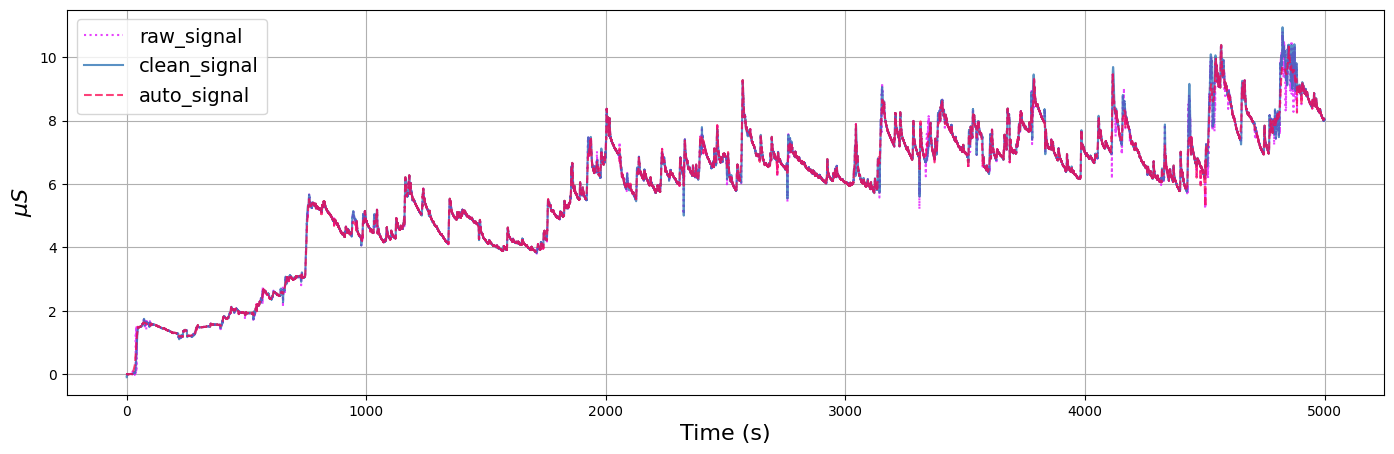

In [473]:
view_time_frame(raw_eda_df, begin_time_s=0, end_time_s=5000)

the aforementioned data loaded above was just one subject I believe which spans from 0 to roughly 6400 seconds or 1 hour roughly for each subject, because in the edabe dataset which consists of train and test folders, inside each folder are I believe the subjects which each exhibit their skin conductance or eda signals, and have their last rows have time values of 59, 58, 60, 61, 62, 63, 64 etc. which may tell us that each subject had their SC or EDA recorded from 0 to 6400 seconds which again roughly is 1 hour for each subject

here oxused is the name of the subject as the filename Corrected_oxused_expert2.csv suggests and has been used by llanes-jurado for testing their automatic eda signal correction model this is why Corrected_oxused_expert2.csv is not actually the data used for training in of itself but the test data processed by the automatic eda signal correction model already

![image.png](attachment:image.png)

In [474]:
ahixac_eda_df = pd.read_csv('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Train/ahixac_expert1.csv', sep=';')
ahixac_eda_df

time   rawdata  cleandata  binarytarget  signal_automatic  \
0          0.000000  0.000000  -0.164015           0.0      2.106994e-20   
1          0.007812  0.000000  -0.127567           0.0      1.879714e-06   
2          0.015625  0.000000  -0.127567           0.0      3.656027e-06   
3          0.023438  0.000000  -0.127567           0.0      5.370973e-06   
4          0.031250  0.000000  -0.127567           0.0      7.062509e-06   
...             ...       ...        ...           ...               ...   
832825  6506.445312  2.591209   2.591209           0.0      2.591209e+00   
832826  6506.453125  2.585348   2.585348           0.0      2.585348e+00   
832827  6506.460938  2.602930   2.602930           0.0      2.602930e+00   
832828  6506.468750  2.570696   2.570696           0.0      2.570696e+00   
832829  6506.476562  2.589744   2.589744           0.0      2.589744e+00   

        PredArtifacts  PostProcessedPredArtifacts  
0                 1.0                         1.0  
1                 1.0                         1.0  
2                 1.0                         1.0  
3                 1.0                         1.0  
4                 1.0                         1.0  
...               ...                         ...  
832825            0.0                         0.0  
832826            0.0                         0.0  
832827            0.0                         0.0  
832828            0.0                         0.0  
832829            0.0                         0.0  

[832830 rows x 7 columns]

In [475]:
ahixac_eda_df.rename(columns={
    'rawdata': 'raw_signal',
    'cleandata': 'clean_signal',
    'binarytarget': 'label',
    'signal_automatic': 'auto_signal',
    'PredArtifacts': 'pred_art',
    'PostProcessedPredArtifacts': 'post_proc_pred_art'}, inplace=True)
ahixac_eda_df

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0          0.000000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1          0.007812    0.000000     -0.127567    0.0  1.879714e-06       1.0   
2          0.015625    0.000000     -0.127567    0.0  3.656027e-06       1.0   
3          0.023438    0.000000     -0.127567    0.0  5.370973e-06       1.0   
4          0.031250    0.000000     -0.127567    0.0  7.062509e-06       1.0   
...             ...         ...           ...    ...           ...       ...   
832825  6506.445312    2.591209      2.591209    0.0  2.591209e+00       0.0   
832826  6506.453125    2.585348      2.585348    0.0  2.585348e+00       0.0   
832827  6506.460938    2.602930      2.602930    0.0  2.602930e+00       0.0   
832828  6506.468750    2.570696      2.570696    0.0  2.570696e+00       0.0   
832829  6506.476562    2.589744      2.589744    0.0  2.589744e+00       0.0   

        post_proc_pred_art  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      1.0  
...                    ...  
832825                 0.0  
832826                 0.0  
832827                 0.0  
832828                 0.0  
832829                 0.0  

[832830 rows x 7 columns]

## we need to get the last row of this dataframes time column and round the time (in seconds) to a whole number and that would be the end_time_s value we can use for the `view_time_frame` function

In [476]:
begin_time_s = 0
end_time_s = ahixac_eda_df['time'].iloc[-1]

In [477]:
end_time_s = round(end_time_s)
end_time_s

6506

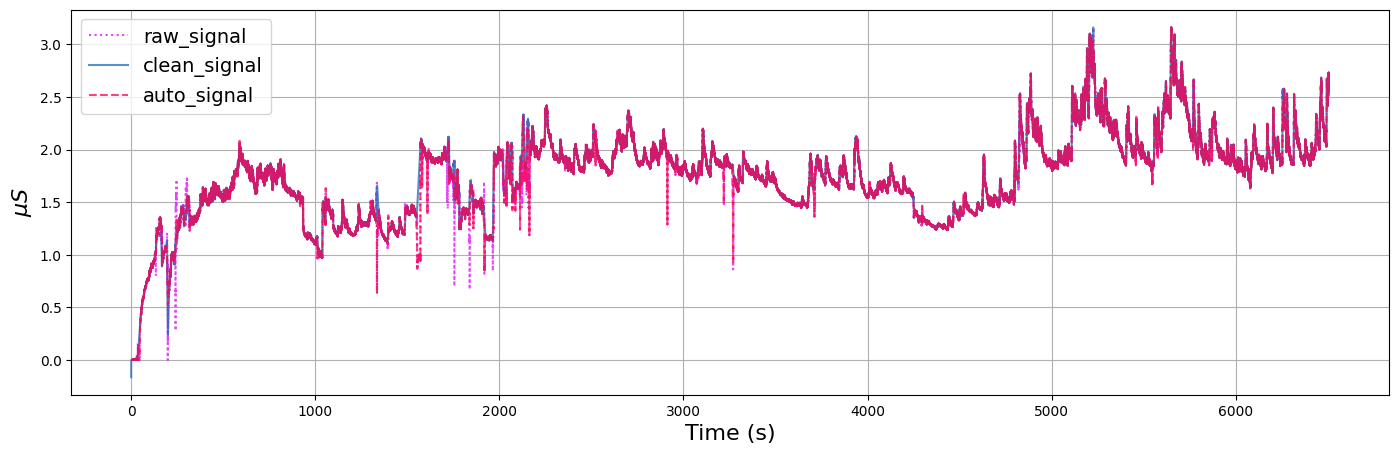

In [478]:
view_time_frame(ahixac_eda_df, begin_time_s=begin_time_s, end_time_s=end_time_s)

In [479]:
len(os.listdir('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Test/'))

10

In [480]:
len(os.listdir('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Train/'))

33

## this also tells us as llanes-jurado et al. (2023) has detailed that in total there were 43 subjects that had their SCR recorded. And this tells us that the test set used 10 subjects, and the train set used 33 subjects

## Things to do and know about the dataset:
- what frequency (in hertz) were the eda signals recorded in in llanes-jurado et al. (2023), because in taylor et al. (2015) it was in 8hz? **128hz**
- visualize a filtered version of the eda signals using taylor et al. function
- print question and answer by gemini about filtering raw eda signals using `scipy.signal.butter` etc.
- once printed write down the function written

In [481]:
def interpolate_signals(data: pd.DataFrame, sample_rate: int=128, start_time: datetime.datetime | str='01/01/1970', target_hz: int=8):
    """
    interpolates signals to a certain frequency i.e. if an
    eda signal has been recorded at 128hz it can be interpolated
    to 8hz, 16hz, etc. via downsampling or to 256hz via upsampling
    """

    # get number of rows of dataframe
    n_rows = data.shape[0]
    if sample_rate < 8:
        if sample_rate == 2:
            # we modify the index of the dataframe to be time values
            data.index = pd.date_range(start=start_time, periods=n_rows, freq='500ms')
        elif sample_rate == 4:
            data.index = pd.date_range(start=start_time, periods=n_rows, freq='250ms')

        # if our sample rate is 1, 3, 5, 6, or 7 which are all below 8 then
        # we convert our timestamps to that that increments to 125 milliseconds
        # now
        data = data.resample(f'{1000 / target_hz}ms').mean()

    # this is if sample rate is 8 or greater than 8
    else:
        if sample_rate > 8:
            # we create a list of indeces to use as index to access parts
            # of the dataframe which are at this point still integers
            indices = list(range(0, n_rows))
            indices_sampled = indices[0::int(sample_rate / target_hz)]
            data = data.iloc[indices_sampled]

        # get number of rows of dataframe which were newly sampled
        sampled_n_rows = data.shape[0]

        # set the index to be our target frequency (in hz) i.e. if our new target
        # frequency of  the signal is 8hz then 1000 / 8 would result in 125ms, if
        # we want it to be 16 then 1000 / 16 would result in 62.5ms
        freq = f'{1000 / target_hz}ms'
        print(freq)
        data.index = pd.date_range(start=start_time, periods=sampled_n_rows, freq=freq)

    # since data resampling and then aggregation (i.e. mean, sum, etc.)
    # from 500ms to 125ms for instance will likely generate empty or
    # nan values we need to also interpolate these empty values
    data = interpolate_empty_values(data)

    return data

def interpolate_empty_values(data: pd.DataFrame):
    """
    # since data resampling and then aggregation (i.e. mean, sum, etc.)
    # from 500ms to 125ms for instance will likely generate empty or
    # nan values we need to also interpolate these empty values
    """

    # instead of DataframeIndex object extract
    # its original values
    cols = data.columns.values

    for col in cols:
        # loop through each column/feature to use to access
        # series of values in each column to interpolate thems
        data.loc[:, col] = data[col].interpolate()

    return data

## Here we want to create a datetime index for our dataframe that increases by 0.5s or 500 milliseconds

In [482]:
now_500ms_from_now = pd.date_range(start=datetime.datetime.now(), periods=10, freq='500ms')
now_500ms_from_now

DatetimeIndex(['2024-11-11 17:44:33.014768', '2024-11-11 17:44:33.514768',
               '2024-11-11 17:44:34.014768', '2024-11-11 17:44:34.514768',
               '2024-11-11 17:44:35.014768', '2024-11-11 17:44:35.514768',
               '2024-11-11 17:44:36.014768', '2024-11-11 17:44:36.514768',
               '2024-11-11 17:44:37.014768', '2024-11-11 17:44:37.514768'],
              dtype='datetime64[ns]', freq='500ms')

## Here we want to create a datetime index object for our dataframe that increases by 0.25s or 500milliseconds

In [483]:
now_250ms_from_now = pd.date_range(start=datetime.datetime.now(), periods=10, freq='250ms')
now_250ms_from_now

DatetimeIndex(['2024-11-11 17:44:33.147467', '2024-11-11 17:44:33.397467',
               '2024-11-11 17:44:33.647467', '2024-11-11 17:44:33.897467',
               '2024-11-11 17:44:34.147467', '2024-11-11 17:44:34.397467',
               '2024-11-11 17:44:34.647467', '2024-11-11 17:44:34.897467',
               '2024-11-11 17:44:35.147467', '2024-11-11 17:44:35.397467'],
              dtype='datetime64[ns]', freq='250ms')

In [484]:
test_data = pd.Series(range(10), index=now_500ms_from_now)
test_data

2024-11-11 17:44:33.014768    0
2024-11-11 17:44:33.514768    1
2024-11-11 17:44:34.014768    2
2024-11-11 17:44:34.514768    3
2024-11-11 17:44:35.014768    4
2024-11-11 17:44:35.514768    5
2024-11-11 17:44:36.014768    6
2024-11-11 17:44:36.514768    7
2024-11-11 17:44:37.014768    8
2024-11-11 17:44:37.514768    9
Freq: 500ms, dtype: int64

In [485]:
test_data_resampled = test_data.resample('125ms')
test_data_resampled

In [486]:
len(test_data_resampled)

37

In [487]:
for row in test_data_resampled:
    print(row)

(Timestamp('2024-11-11 17:44:33'), 2024-11-11 17:44:33.014768    0
Freq: 500ms, dtype: int64)
(Timestamp('2024-11-11 17:44:33.125000'), Series([], Freq: 500ms, dtype: int64))
(Timestamp('2024-11-11 17:44:33.250000'), Series([], Freq: 500ms, dtype: int64))
(Timestamp('2024-11-11 17:44:33.375000'), Series([], Freq: 500ms, dtype: int64))
(Timestamp('2024-11-11 17:44:33.500000'), 2024-11-11 17:44:33.514768    1
Freq: 500ms, dtype: int64)
(Timestamp('2024-11-11 17:44:33.625000'), Series([], Freq: 500ms, dtype: int64))
(Timestamp('2024-11-11 17:44:33.750000'), Series([], Freq: 500ms, dtype: int64))
(Timestamp('2024-11-11 17:44:33.875000'), Series([], Freq: 500ms, dtype: int64))
(Timestamp('2024-11-11 17:44:34'), 2024-11-11 17:44:34.014768    2
Freq: 500ms, dtype: int64)
(Timestamp('2024-11-11 17:44:34.125000'), Series([], Freq: 500ms, dtype: int64))
(Timestamp('2024-11-11 17:44:34.250000'), Series([], Freq: 500ms, dtype: int64))
(Timestamp('2024-11-11 17:44:34.375000'), Series([], Freq: 500m

In [488]:
test_data_resampled.mean()

2024-11-11 17:44:33.000    0.0
2024-11-11 17:44:33.125    NaN
2024-11-11 17:44:33.250    NaN
2024-11-11 17:44:33.375    NaN
2024-11-11 17:44:33.500    1.0
2024-11-11 17:44:33.625    NaN
2024-11-11 17:44:33.750    NaN
2024-11-11 17:44:33.875    NaN
2024-11-11 17:44:34.000    2.0
2024-11-11 17:44:34.125    NaN
2024-11-11 17:44:34.250    NaN
2024-11-11 17:44:34.375    NaN
2024-11-11 17:44:34.500    3.0
2024-11-11 17:44:34.625    NaN
2024-11-11 17:44:34.750    NaN
2024-11-11 17:44:34.875    NaN
2024-11-11 17:44:35.000    4.0
2024-11-11 17:44:35.125    NaN
2024-11-11 17:44:35.250    NaN
2024-11-11 17:44:35.375    NaN
2024-11-11 17:44:35.500    5.0
2024-11-11 17:44:35.625    NaN
2024-11-11 17:44:35.750    NaN
2024-11-11 17:44:35.875    NaN
2024-11-11 17:44:36.000    6.0
2024-11-11 17:44:36.125    NaN
2024-11-11 17:44:36.250    NaN
2024-11-11 17:44:36.375    NaN
2024-11-11 17:44:36.500    7.0
2024-11-11 17:44:36.625    NaN
2024-11-11 17:44:36.750    NaN
2024-11-11 17:44:36.875    NaN
2024-11-

In [489]:
len(test_data_resampled.mean())

37

In [490]:
pqbqpr_eda_df = pd.read_csv('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Test/pqbqpr_expert2.csv', sep=';')
pqbqpr_eda_df

time   rawdata  cleandata  binarytarget  signal_automatic  \
0          0.000000  0.000000  -0.164015           0.0      2.106994e-20   
1          0.007812  0.000000  -0.164015           0.0      1.879714e-06   
2          0.015625  0.000000  -0.164015           0.0      3.656027e-06   
3          0.023438  0.000000  -0.164015           0.0      5.370973e-06   
4          0.031250  0.000000  -0.164015           0.0      7.062509e-06   
...             ...       ...        ...           ...               ...   
980113  7657.132812  0.002886   0.002886           0.0      2.886003e-03   
980114  7657.140625  0.000222   0.000222           0.0      2.220002e-04   
980115  7657.148438  0.000222   0.000222           0.0      2.220002e-04   
980116  7657.156250  0.002442   0.002442           0.0      2.442002e-03   
980117  7657.164062  0.000222   0.000222           0.0      2.220002e-04   

        PredArtifacts  PostProcessedPredArtifacts  
0                 1.0                         1.0  
1                 1.0                         1.0  
2                 1.0                         1.0  
3                 1.0                         1.0  
4                 1.0                         1.0  
...               ...                         ...  
980113            0.0                         0.0  
980114            0.0                         0.0  
980115            0.0                         0.0  
980116            0.0                         0.0  
980117            0.0                         0.0  

[980118 rows x 7 columns]

In [491]:
pqbqpr_eda_df.columns = ['time', 'raw_signal', 'clean_signal', 'label', 'auto_signal', 'pred_art', 'post_proc_pred_art']
pqbqpr_eda_df

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0          0.000000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1          0.007812    0.000000     -0.164015    0.0  1.879714e-06       1.0   
2          0.015625    0.000000     -0.164015    0.0  3.656027e-06       1.0   
3          0.023438    0.000000     -0.164015    0.0  5.370973e-06       1.0   
4          0.031250    0.000000     -0.164015    0.0  7.062509e-06       1.0   
...             ...         ...           ...    ...           ...       ...   
980113  7657.132812    0.002886      0.002886    0.0  2.886003e-03       0.0   
980114  7657.140625    0.000222      0.000222    0.0  2.220002e-04       0.0   
980115  7657.148438    0.000222      0.000222    0.0  2.220002e-04       0.0   
980116  7657.156250    0.002442      0.002442    0.0  2.442002e-03       0.0   
980117  7657.164062    0.000222      0.000222    0.0  2.220002e-04       0.0   

        post_proc_pred_art  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      1.0  
...                    ...  
980113                 0.0  
980114                 0.0  
980115                 0.0  
980116                 0.0  
980117                 0.0  

[980118 rows x 7 columns]

In [492]:
begin_time_s = 0
end_time_s = round(pqbqpr_eda_df['time'].iloc[-1])
begin_time_s, end_time_s

(0, 7657)

In [493]:
end_time_s * 128

980096

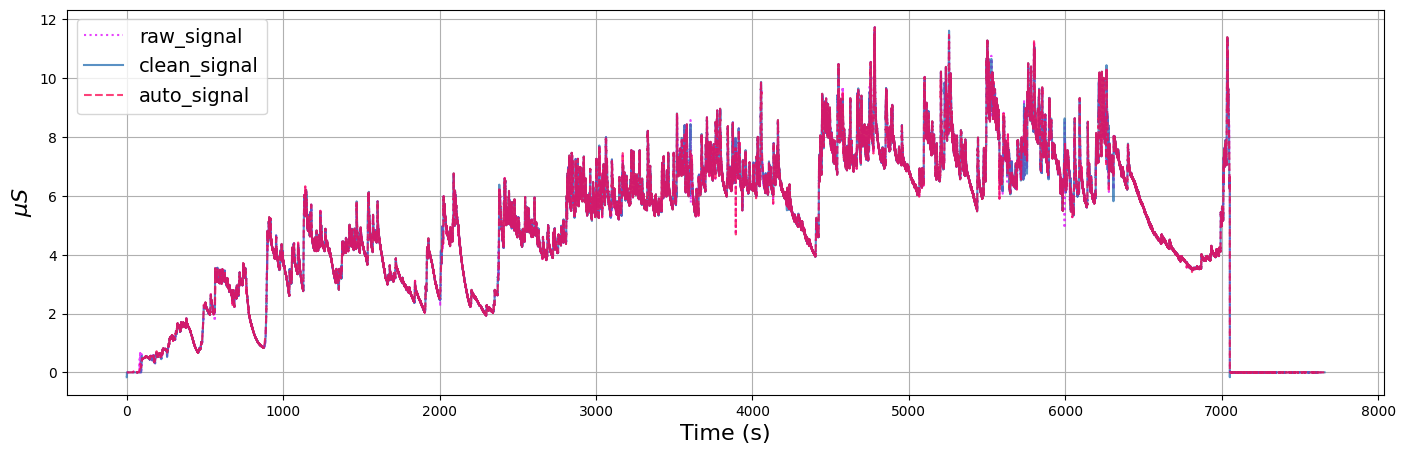

In [494]:
view_time_frame(pqbqpr_eda_df, begin_time_s=begin_time_s, end_time_s=end_time_s)

In [495]:
akakip_eda_df = pd.read_csv('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Train/akakip_expert2.csv', sep=';')
akakip_eda_df

time   rawdata  cleandata  binarytarget  signal_automatic  \
0          0.000000  0.000000  -0.164015           0.0      2.106994e-20   
1          0.007812  0.000000  -0.164015           0.0      1.879714e-06   
2          0.015625  0.000000  -0.164015           0.0      3.656027e-06   
3          0.023438  0.000000  -0.164015           0.0      5.370973e-06   
4          0.031250  0.000000  -0.164015           0.0      7.062509e-06   
...             ...       ...        ...           ...               ...   
770809  6021.945312  5.214994   5.214994           0.0      5.214994e+00   
770810  6021.953125  5.209889   5.209889           0.0      5.209889e+00   
770811  6021.960938  5.209889   5.209889           0.0      5.209889e+00   
770812  6021.968750  5.204784   5.204784           0.0      5.204784e+00   
770813  6021.976562  5.204784   5.204784           0.0      5.204784e+00   

        PredArtifacts  PostProcessedPredArtifacts  
0                 1.0                         1.0  
1                 1.0                         1.0  
2                 1.0                         1.0  
3                 1.0                         1.0  
4                 1.0                         1.0  
...               ...                         ...  
770809            0.0                         0.0  
770810            0.0                         0.0  
770811            0.0                         0.0  
770812            0.0                         0.0  
770813            0.0                         0.0  

[770814 rows x 7 columns]

In [496]:
akakip_eda_df.columns

Index(['time', 'rawdata', 'cleandata', 'binarytarget', 'signal_automatic',
       'PredArtifacts', 'PostProcessedPredArtifacts'],
      dtype='object')

## skiprows argument in reading a `.csv` file skips rows `n` times specified by user e.g. if we have a set of data `[1, 2, 3, 4, 5]` and I specify `skiprows` to be 2 then only 3, 4, 5 will be left since I skipped the first 2 elements namely 1 and 2.

In [497]:
# akakip_eda_df = pd.read_csv('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Train/akakip_expert2.csv', sep=';', skiprows=2)
# akakip_eda_df

## since the last skipped row became the headers we can just reset the headers via the setter function of our dataframe object

In [498]:
akakip_eda_df.columns = ['time', 'raw_signal', 'clean_signal', 'label', 'auto_signal', 'pred_art', 'post_proc_pred_art']
akakip_eda_df

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0          0.000000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1          0.007812    0.000000     -0.164015    0.0  1.879714e-06       1.0   
2          0.015625    0.000000     -0.164015    0.0  3.656027e-06       1.0   
3          0.023438    0.000000     -0.164015    0.0  5.370973e-06       1.0   
4          0.031250    0.000000     -0.164015    0.0  7.062509e-06       1.0   
...             ...         ...           ...    ...           ...       ...   
770809  6021.945312    5.214994      5.214994    0.0  5.214994e+00       0.0   
770810  6021.953125    5.209889      5.209889    0.0  5.209889e+00       0.0   
770811  6021.960938    5.209889      5.209889    0.0  5.209889e+00       0.0   
770812  6021.968750    5.204784      5.204784    0.0  5.204784e+00       0.0   
770813  6021.976562    5.204784      5.204784    0.0  5.204784e+00       0.0   

        post_proc_pred_art  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      1.0  
...                    ...  
770809                 0.0  
770810                 0.0  
770811                 0.0  
770812                 0.0  
770813                 0.0  

[770814 rows x 7 columns]

In [499]:
# get start time of subjects eda signals
akakip_start_time = akakip_eda_df['time'].iloc[0]
akakip_start_time

0.0

In [500]:
# to convert this to a pandas datetime object we need to specify the unit of the original object which is our start time
akakip_start_time = pd.to_datetime(akakip_start_time, unit='s')
akakip_start_time

Timestamp('1970-01-01 00:00:00')

## now we can use the start time we extracted earlier and use the number of rows from the shape of our dataframe to create dataframe indeces that increment in 500, 250, and 125 milliseconds respectively

In [501]:
akakip_500ms = pd.date_range(start=akakip_start_time, periods=akakip_eda_df.shape[0], freq='500ms')
akakip_500ms

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.500000',
                      '1970-01-01 00:00:01', '1970-01-01 00:00:01.500000',
                      '1970-01-01 00:00:02', '1970-01-01 00:00:02.500000',
                      '1970-01-01 00:00:03', '1970-01-01 00:00:03.500000',
                      '1970-01-01 00:00:04', '1970-01-01 00:00:04.500000',
               ...
                      '1970-01-05 11:03:22', '1970-01-05 11:03:22.500000',
                      '1970-01-05 11:03:23', '1970-01-05 11:03:23.500000',
                      '1970-01-05 11:03:24', '1970-01-05 11:03:24.500000',
                      '1970-01-05 11:03:25', '1970-01-05 11:03:25.500000',
                      '1970-01-05 11:03:26', '1970-01-05 11:03:26.500000'],
              dtype='datetime64[ns]', length=770814, freq='500ms')

In [502]:
akakip_250ms = pd.date_range(start=akakip_start_time, periods=akakip_eda_df.shape[0], freq='250ms')
akakip_250ms

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.250000',
               '1970-01-01 00:00:00.500000', '1970-01-01 00:00:00.750000',
                      '1970-01-01 00:00:01', '1970-01-01 00:00:01.250000',
               '1970-01-01 00:00:01.500000', '1970-01-01 00:00:01.750000',
                      '1970-01-01 00:00:02', '1970-01-01 00:00:02.250000',
               ...
                      '1970-01-03 05:31:41', '1970-01-03 05:31:41.250000',
               '1970-01-03 05:31:41.500000', '1970-01-03 05:31:41.750000',
                      '1970-01-03 05:31:42', '1970-01-03 05:31:42.250000',
               '1970-01-03 05:31:42.500000', '1970-01-03 05:31:42.750000',
                      '1970-01-03 05:31:43', '1970-01-03 05:31:43.250000'],
              dtype='datetime64[ns]', length=770814, freq='250ms')

In [503]:
akakip_125ms = pd.date_range(start=akakip_start_time, periods=akakip_eda_df.shape[0], freq='125ms')
akakip_125ms

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.125000',
               '1970-01-01 00:00:00.250000', '1970-01-01 00:00:00.375000',
               '1970-01-01 00:00:00.500000', '1970-01-01 00:00:00.625000',
               '1970-01-01 00:00:00.750000', '1970-01-01 00:00:00.875000',
                      '1970-01-01 00:00:01', '1970-01-01 00:00:01.125000',
               ...
               '1970-01-02 02:45:50.500000', '1970-01-02 02:45:50.625000',
               '1970-01-02 02:45:50.750000', '1970-01-02 02:45:50.875000',
                      '1970-01-02 02:45:51', '1970-01-02 02:45:51.125000',
               '1970-01-02 02:45:51.250000', '1970-01-02 02:45:51.375000',
               '1970-01-02 02:45:51.500000', '1970-01-02 02:45:51.625000'],
              dtype='datetime64[ns]', length=770814, freq='125ms')

In [504]:
akakip_eda_df_8hz = interpolate_signals(akakip_eda_df, sample_rate=128, start_time=akakip_start_time, target_hz=8)
akakip_eda_df_8hz

125.0ms


time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000     0.000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.125     0.125    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.250     0.250    0.000222      0.000222    0.0   
1970-01-01 00:00:00.375     0.375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.500     0.500    0.000222      0.000222    0.0   
...                           ...         ...           ...    ...   
1970-01-01 01:40:21.375  6021.375    5.357941      5.357941    0.0   
1970-01-01 01:40:21.500  6021.500    5.322204      5.322204    0.0   
1970-01-01 01:40:21.625  6021.625    5.291573      5.291573    0.0   
1970-01-01 01:40:21.750  6021.750    5.255836      5.255836    0.0   
1970-01-01 01:40:21.875  6021.875    5.230310      5.230310    0.0   

                          auto_signal  pred_art  post_proc_pred_art  
1970-01-01 00:00:00.000  2.106994e-20       1.0                 1.0  
1970-01-01 00:00:00.125  2.747785e-05       1.0                 1.0  
1970-01-01 00:00:00.250  1.260593e-04       1.0                 1.0  
1970-01-01 00:00:00.375  1.960738e-04       1.0                 1.0  
1970-01-01 00:00:00.500  2.196768e-04       0.0                 0.0  
...                               ...       ...                 ...  
1970-01-01 01:40:21.375  5.357941e+00       0.0                 0.0  
1970-01-01 01:40:21.500  5.322204e+00       0.0                 0.0  
1970-01-01 01:40:21.625  5.291573e+00       0.0                 0.0  
1970-01-01 01:40:21.750  5.255836e+00       0.0                 0.0  
1970-01-01 01:40:21.875  5.230310e+00       0.0                 0.0  

[48176 rows x 7 columns]

![image.png](attachment:image.png)

## As we can see now we have interpolated our 128hz time stamps by downsampling to 8hz which still roughly retains our original end time of 6021.976562 or 1h40m22s even if our end time is now 6021.890625	since this is virtually still 1h40m22s. And now my theory is if we've now interpolated the 128hz timestamps to 8hz could it be that if we multiply now by 8 that we get the indeces that are appropriate to it akin to what we did earlier when it was still at 128hz i.e. multiplying the last timestamp that has been rounded, to 128 give the last index of the dataframe?

In [505]:
begin_time_s = 0
end_time_s = round(akakip_eda_df_8hz['time'].iloc[-1])

In [506]:
end_time_s

6022

In [507]:
end_time_s * 8

48176

In [508]:
end_time_index = akakip_eda_df_8hz['time'].iloc[-1]
end_time_index

6021.875

In [509]:
end_time_index = end_time_index * 8
end_time_index

48175.0

In [510]:
end_time_index = round(end_time_index)
end_time_index

48175

## As we can see now the theory is correct that multiplying by 8 which is our frequency does indeed give us the index to which we can use to include the last timestamp and/or signal in our downsampled dataframe which is 48176. That is why this supports the claim that the reason why 128 was a number used to multiply to the timestamp was because multiplying it by a timestamp in our dataframe gave us the index where this timestamp was positioned since it was the sampling frequency used to record the eda signals at.

## Now we've interpolated the timestamps and consequently our eda signals to a frequency of 8hz, now we apply low pass filtering using the `scipy.signal.butter` and `scipy.signal.lfilter` functions

In [511]:
def butter_lowpass(cutoff, samp_freq, order):
    """
    defines filter characteristics of the signal to be filtered
    which will be used by butter_lowpass_filter, by utilizing
    this functions return values which are the filter coefficients
    a and b
    """

    # calculate nyquist frequency which is half the given
    # sampling frequency
    nyq = samp_freq / 2
    normed_cutoff = cutoff / nyq

    # calculate filter coefficients
    b, a = butter(order, normed_cutoff, btype='low', analog=False)

    return b, a

def butter_lowpass_filter(data, cutoff, samp_freq, order=5):
    """
    applies a low-pass filter to the eda signals using filter
    coefficients calculated by butter_lowpass, which removes high
    frequency noise components from signals
    """
    # call butter_lowpass to obtain filter coefficients
    b, a = butter_lowpass(cutoff, samp_freq, order)

    # apply coefficients to signal
    filt_signal = lfilter(b, a, data)

    return filt_signal

In [512]:
akakip_eda_df_8hz['filtered_signal'] = butter_lowpass_filter(akakip_eda_df_8hz['raw_signal'], cutoff=1.0, samp_freq=8, order=6)

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\349979694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  akakip_eda_df_8hz['filtered_signal'] = butter_lowpass_filter(akakip_eda_df_8hz['raw_signal'], cutoff=1.0, samp_freq=8, order=6)


In [513]:
akakip_eda_df_8hz

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000     0.000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.125     0.125    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.250     0.250    0.000222      0.000222    0.0   
1970-01-01 00:00:00.375     0.375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.500     0.500    0.000222      0.000222    0.0   
...                           ...         ...           ...    ...   
1970-01-01 01:40:21.375  6021.375    5.357941      5.357941    0.0   
1970-01-01 01:40:21.500  6021.500    5.322204      5.322204    0.0   
1970-01-01 01:40:21.625  6021.625    5.291573      5.291573    0.0   
1970-01-01 01:40:21.750  6021.750    5.255836      5.255836    0.0   
1970-01-01 01:40:21.875  6021.875    5.230310      5.230310    0.0   

                          auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.125  2.747785e-05       1.0                 1.0   
1970-01-01 00:00:00.250  1.260593e-04       1.0                 1.0   
1970-01-01 00:00:00.375  1.960738e-04       1.0                 1.0   
1970-01-01 00:00:00.500  2.196768e-04       0.0                 0.0   
...                               ...       ...                 ...   
1970-01-01 01:40:21.375  5.357941e+00       0.0                 0.0   
1970-01-01 01:40:21.500  5.322204e+00       0.0                 0.0   
1970-01-01 01:40:21.625  5.291573e+00       0.0                 0.0   
1970-01-01 01:40:21.750  5.255836e+00       0.0                 0.0   
1970-01-01 01:40:21.875  5.230310e+00       0.0                 0.0   

                         filtered_signal  
1970-01-01 00:00:00.000     0.000000e+00  
1970-01-01 00:00:00.125     0.000000e+00  
1970-01-01 00:00:00.250     2.334658e-07  
1970-01-01 00:00:00.375     2.329646e-06  
1970-01-01 00:00:00.500     1.110953e-05  
...                                  ...  
1970-01-01 01:40:21.375     5.548104e+00  
1970-01-01 01:40:21.500     5.499107e+00  
1970-01-01 01:40:21.625     5.453893e+00  
1970-01-01 01:40:21.750     5.413261e+00  
1970-01-01 01:40:21.875     5.376920e+00  

[48176 rows x 8 columns]

In [514]:
new_akakip_eda_df_8hz = akakip_eda_df_8hz.reset_index(drop=True)
new_akakip_eda_df_8hz

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0         0.000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1         0.125    0.000000     -0.028079    0.0  2.747785e-05       1.0   
2         0.250    0.000222      0.000222    0.0  1.260593e-04       1.0   
3         0.375    0.000222      0.000222    0.0  1.960738e-04       1.0   
4         0.500    0.000222      0.000222    0.0  2.196768e-04       0.0   
...         ...         ...           ...    ...           ...       ...   
48171  6021.375    5.357941      5.357941    0.0  5.357941e+00       0.0   
48172  6021.500    5.322204      5.322204    0.0  5.322204e+00       0.0   
48173  6021.625    5.291573      5.291573    0.0  5.291573e+00       0.0   
48174  6021.750    5.255836      5.255836    0.0  5.255836e+00       0.0   
48175  6021.875    5.230310      5.230310    0.0  5.230310e+00       0.0   

       post_proc_pred_art  filtered_signal  
0                     1.0     0.000000e+00  
1                     1.0     0.000000e+00  
2                     1.0     2.334658e-07  
3                     1.0     2.329646e-06  
4                     0.0     1.110953e-05  
...                   ...              ...  
48171                 0.0     5.548104e+00  
48172                 0.0     5.499107e+00  
48173                 0.0     5.453893e+00  
48174                 0.0     5.413261e+00  
48175                 0.0     5.376920e+00  

[48176 rows x 8 columns]

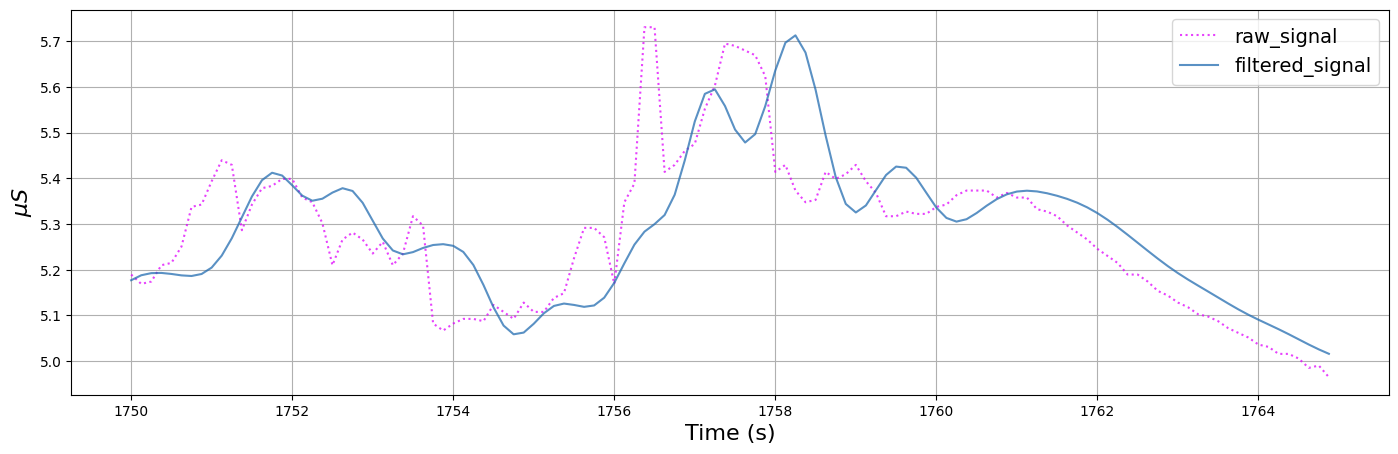

In [515]:
view_time_frame(new_akakip_eda_df_8hz, samp_freq=8, cols_to_use=['raw_signal', 'filtered_signal'])

In [516]:
akakip_eda_df = interpolate_signals(akakip_eda_df, sample_rate=128, start_time=akakip_start_time, target_hz=128)
akakip_eda_df

7.8125ms


time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.164015    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:40:21.945312500  6021.945312    5.214994      5.214994    0.0   
1970-01-01 01:40:21.953125000  6021.953125    5.209889      5.209889    0.0   
1970-01-01 01:40:21.960937500  6021.960938    5.209889      5.209889    0.0   
1970-01-01 01:40:21.968750000  6021.968750    5.204784      5.204784    0.0   
1970-01-01 01:40:21.976562500  6021.976562    5.204784      5.204784    0.0   

                                auto_signal  pred_art  post_proc_pred_art  
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0  
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0  
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0  
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0  
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0  
...                                     ...       ...                 ...  
1970-01-01 01:40:21.945312500  5.214994e+00       0.0                 0.0  
1970-01-01 01:40:21.953125000  5.209889e+00       0.0                 0.0  
1970-01-01 01:40:21.960937500  5.209889e+00       0.0                 0.0  
1970-01-01 01:40:21.968750000  5.204784e+00       0.0                 0.0  
1970-01-01 01:40:21.976562500  5.204784e+00       0.0                 0.0  

[770814 rows x 7 columns]

In [517]:
akakip_eda_df['filtered_signal'] = butter_lowpass_filter(akakip_eda_df['raw_signal'], cutoff=1.0, samp_freq=128, order=6)
akakip_eda_df

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.164015    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:40:21.945312500  6021.945312    5.214994      5.214994    0.0   
1970-01-01 01:40:21.953125000  6021.953125    5.209889      5.209889    0.0   
1970-01-01 01:40:21.960937500  6021.960938    5.209889      5.209889    0.0   
1970-01-01 01:40:21.968750000  6021.968750    5.204784      5.204784    0.0   
1970-01-01 01:40:21.976562500  6021.976562    5.204784      5.204784    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 01:40:21.945312500  5.214994e+00       0.0                 0.0   
1970-01-01 01:40:21.953125000  5.209889e+00       0.0                 0.0   
1970-01-01 01:40:21.960937500  5.209889e+00       0.0                 0.0   
1970-01-01 01:40:21.968750000  5.204784e+00       0.0                 0.0   
1970-01-01 01:40:21.976562500  5.204784e+00       0.0                 0.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 01:40:21.945312500         5.368299  
1970-01-01 01:40:21.953125000         5.366143  
1970-01-01 01:40:21.960937500         5.363993  
1970-01-01 01:40:21.968750000         5.361849  
1970-01-01 01:40:21.976562500         5.359710  

[770814 rows x 8 columns]

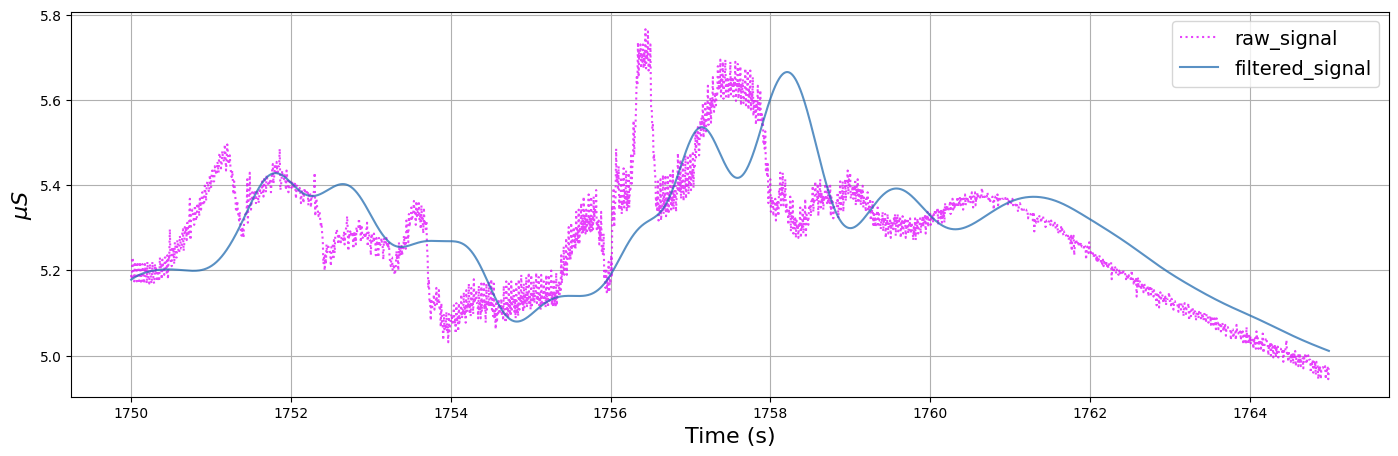

In [518]:
view_time_frame(akakip_eda_df, samp_freq=128, cols_to_use=['raw_signal', 'filtered_signal'])

In [519]:
akakip_eda_df_16hz = interpolate_signals(akakip_eda_df, sample_rate=128, start_time=akakip_start_time, target_hz=16)
akakip_eda_df_16hz

62.5ms


time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000     0.0000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.062500     0.0625    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.125000     0.1250    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.187500     0.1875    0.000000     -0.005128    0.0   
1970-01-01 00:00:00.250000     0.2500    0.000222      0.000222    0.0   
...                               ...         ...           ...    ...   
1970-01-01 01:40:21.687500  6021.6875    5.271152      5.271152    0.0   
1970-01-01 01:40:21.750000  6021.7500    5.255836      5.255836    0.0   
1970-01-01 01:40:21.812500  6021.8125    5.240520      5.240520    0.0   
1970-01-01 01:40:21.875000  6021.8750    5.230310      5.230310    0.0   
1970-01-01 01:40:21.937500  6021.9375    5.209889      5.209889    0.0   

                             auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.062500  1.357508e-05       1.0                 1.0   
1970-01-01 00:00:00.125000  2.747785e-05       1.0                 1.0   
1970-01-01 00:00:00.187500  5.611462e-05       1.0                 1.0   
1970-01-01 00:00:00.250000  1.260593e-04       1.0                 1.0   
...                                  ...       ...                 ...   
1970-01-01 01:40:21.687500  5.271152e+00       0.0                 0.0   
1970-01-01 01:40:21.750000  5.255836e+00       0.0                 0.0   
1970-01-01 01:40:21.812500  5.240520e+00       0.0                 0.0   
1970-01-01 01:40:21.875000  5.230310e+00       0.0                 0.0   
1970-01-01 01:40:21.937500  5.209889e+00       0.0                 0.0   

                            filtered_signal  
1970-01-01 00:00:00.000000     0.000000e+00  
1970-01-01 00:00:00.062500     0.000000e+00  
1970-01-01 00:00:00.125000     0.000000e+00  
1970-01-01 00:00:00.187500     0.000000e+00  
1970-01-01 00:00:00.250000     3.639641e-12  
...                                     ...  
1970-01-01 01:40:21.687500     5.444835e+00  
1970-01-01 01:40:21.750000     5.425037e+00  
1970-01-01 01:40:21.812500     5.406151e+00  
1970-01-01 01:40:21.875000     5.388016e+00  
1970-01-01 01:40:21.937500     5.370461e+00  

[96352 rows x 8 columns]

In [520]:
start_time_s = 0
end_time_s = round(akakip_eda_df_16hz['time'].iloc[-1])

In [521]:
end_time_s

6022

In [522]:
end_time_s * 16

96352

In [523]:
end_time_index = round(akakip_eda_df_16hz['time'].iloc[-1] * 16)
end_time_index

96351

In [524]:
akakip_eda_df_16hz['filtered_signal'] = butter_lowpass_filter(akakip_eda_df_16hz['raw_signal'], cutoff=1.0, samp_freq=16, order=6)

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\2130612871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  akakip_eda_df_16hz['filtered_signal'] = butter_lowpass_filter(akakip_eda_df_16hz['raw_signal'], cutoff=1.0, samp_freq=16, order=6)


In [525]:
new_akakip_eda_df_16hz = akakip_eda_df_16hz.reset_index(drop=True)
new_akakip_eda_df_16hz

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0         0.0000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1         0.0625    0.000000     -0.028079    0.0  1.357508e-05       1.0   
2         0.1250    0.000000     -0.028079    0.0  2.747785e-05       1.0   
3         0.1875    0.000000     -0.005128    0.0  5.611462e-05       1.0   
4         0.2500    0.000222      0.000222    0.0  1.260593e-04       1.0   
...          ...         ...           ...    ...           ...       ...   
96347  6021.6875    5.271152      5.271152    0.0  5.271152e+00       0.0   
96348  6021.7500    5.255836      5.255836    0.0  5.255836e+00       0.0   
96349  6021.8125    5.240520      5.240520    0.0  5.240520e+00       0.0   
96350  6021.8750    5.230310      5.230310    0.0  5.230310e+00       0.0   
96351  6021.9375    5.209889      5.209889    0.0  5.209889e+00       0.0   

       post_proc_pred_art  filtered_signal  
0                     1.0     0.000000e+00  
1                     1.0     0.000000e+00  
2                     1.0     0.000000e+00  
3                     1.0     0.000000e+00  
4                     1.0     6.399354e-09  
...                   ...              ...  
96347                 0.0     5.441185e+00  
96348                 0.0     5.421049e+00  
96349                 0.0     5.401972e+00  
96350                 0.0     5.383830e+00  
96351                 0.0     5.366459e+00  

[96352 rows x 8 columns]

In [526]:
new_akakip_eda_df_16hz[0:16]

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0   0.0000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1   0.0625    0.000000     -0.028079    0.0  1.357508e-05       1.0   
2   0.1250    0.000000     -0.028079    0.0  2.747785e-05       1.0   
3   0.1875    0.000000     -0.005128    0.0  5.611462e-05       1.0   
4   0.2500    0.000222      0.000222    0.0  1.260593e-04       1.0   
5   0.3125    0.000222      0.000222    0.0  1.814013e-04       1.0   
6   0.3750    0.000222      0.000222    0.0  1.960738e-04       1.0   
7   0.4375    0.000222      0.000222    0.0  2.102826e-04       1.0   
8   0.5000    0.000222      0.000222    0.0  2.196768e-04       0.0   
9   0.5625    0.000222      0.000222    0.0  2.220002e-04       0.0   
10  0.6250    0.000222      0.000222    0.0  2.220002e-04       0.0   
11  0.6875    0.000222      0.000222    0.0  2.220002e-04       0.0   
12  0.7500    0.000222      0.000222    0.0  2.220002e-04       0.0   
13  0.8125    0.000222      0.000222    0.0  2.220002e-04       0.0   
14  0.8750    0.000222      0.000222    0.0  2.220002e-04       0.0   
15  0.9375    0.000222      0.000222    0.0  2.220002e-04       0.0   

    post_proc_pred_art  filtered_signal  
0                  1.0     0.000000e+00  
1                  1.0     0.000000e+00  
2                  1.0     0.000000e+00  
3                  1.0     0.000000e+00  
4                  1.0     6.399354e-09  
5                  1.0     7.349379e-08  
6                  1.0     4.157932e-07  
7                  1.0     1.562775e-06  
8                  0.0     4.439094e-06  
9                  0.0     1.026403e-05  
10                 0.0     2.027584e-05  
11                 0.0     3.538345e-05  
12                 0.0     5.586796e-05  
13                 0.0     8.122268e-05  
14                 0.0     1.101675e-04  
15                 0.0     1.408237e-04

## as we can see also here in a 16hz frequency of our data that the samples we have per second is 16

In [527]:
new_akakip_eda_df_16hz.iloc[16]

time                  1.000000
raw_signal            0.000222
clean_signal          0.000222
label                 0.000000
auto_signal           0.000222
pred_art              0.000000
post_proc_pred_art    0.000000
filtered_signal       0.000171
Name: 16, dtype: float64

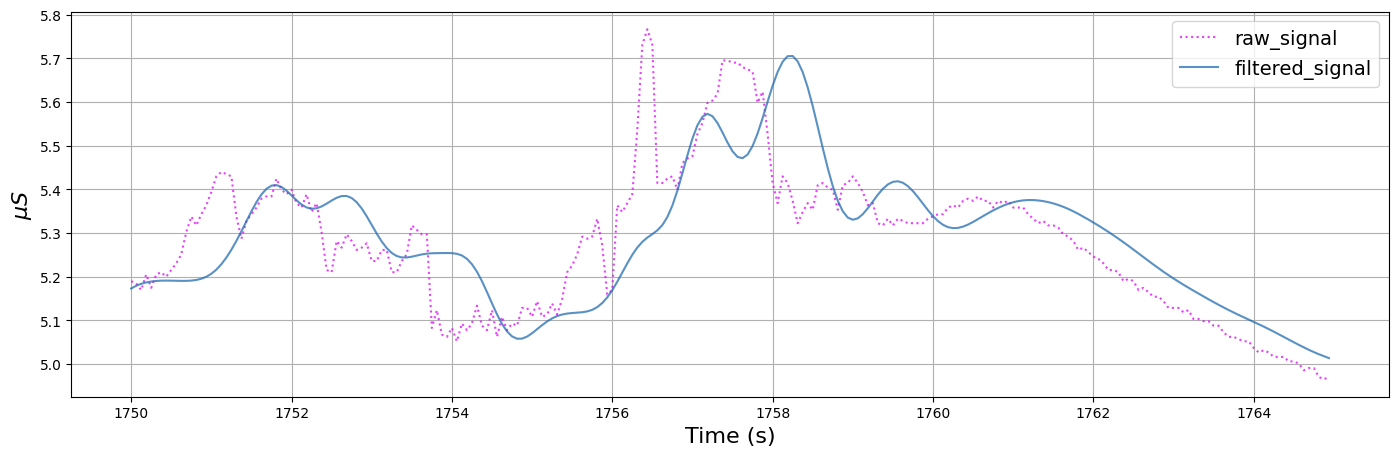

In [528]:
view_time_frame(new_akakip_eda_df_16hz, samp_freq=16, cols_to_use=['raw_signal', 'filtered_signal'])

## The next phase in Taylor et al. (2015) paper was to extract features from the dataframe that we have now interpolated to 8hz and which now inlcudes a filtered version of the raw eda signal

In [529]:
# note this samples per sec is not arbitrary and a
# user defined value but derived from our frequency
# value entirely i.e. because we've interpolated our
# raw data of 128hz to 8hz then that means that the
# samples of data we have per second would be 8
samples_per_sec = 8
secs_per_min = 60
min_per_hour = 60

# here we would be calculating how many samples we would have
# per hour given we want 8 samples per second
samples_per_hour = samples_per_sec * secs_per_min * min_per_hour

samples_per_5s = samples_per_sec * 5

In [530]:
samples_per_hour

28800

In [531]:
samples_per_5s

40

In [532]:
# get number of rows of 8hz timestamps and signals
n_rows = akakip_eda_df_8hz.shape[0]

# dividing the number of rows by samples per 5 seconds
# will allows us to get a sense how many segments of 5
# rows can we get from this time series dataframe of our signals
num_labels = int(math.ceil(n_rows / samples_per_5s))

#
hours = int(math.ceil(n_rows / samples_per_hour))

In [533]:
math.ceil(n_rows / samples_per_5s)

1205

In [534]:
math.ceil(n_rows / samples_per_hour)

2

In [535]:
num_labels

1205

In [536]:
hours

2

## What do all these mean??? Well say we had a certain number of rows in our dataframe, in this case our now 8hz dataframe of our timestamps and eda signals, which has **48176** rows in total. What we do when we calculate the `num_labels` is that we want to determine how many labels can we have per 5 seconds of our data, which in Taylor et al. (2015) paper is indicated that they used 5 second epochs/segments of their signals which are non-overlapping and that they collected **1560** of these segments all in all which was consequently also the number of their labels

## recall also that samples_per_hour are how many samples in our dataframe do we want to have every hour or per hour. In this case we want **28800** samples of our data per hour, and since we have **48176** rows or samples (the samples unit now cancel out each other) we are left with **48176samps** divided by **28800samps/hr** or **1.67hr** which when rounded up is roughly 2 hours. Hence we would roughly have 2 hours all in all if we had 28800 samples per hour

In [537]:
for hour in range(hours):
    start = hour * samples_per_hour
    end = min((hour + 1) * samples_per_hour, n_rows)
    print(f'start: {start} | end: {end}')

    curr_data = akakip_eda_df_8hz.iloc[start:end]
    print(curr_data)

start: 0 | end: 28800
                             time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000     0.000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.125     0.125    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.250     0.250    0.000222      0.000222    0.0   
1970-01-01 00:00:00.375     0.375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.500     0.500    0.000222      0.000222    0.0   
...                           ...         ...           ...    ...   
1970-01-01 00:59:59.375  3599.375    3.855678      3.855678    0.0   
1970-01-01 00:59:59.500  3599.500    3.860073      3.860073    0.0   
1970-01-01 00:59:59.625  3599.625    3.863004      3.863004    0.0   
1970-01-01 00:59:59.750  3599.750    3.861538      3.861538    0.0   
1970-01-01 00:59:59.875  3599.875    3.861538      3.861538    0.0   

                          auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000  2.106994e-20       1.0                 1.

## 40 is used as an increment value since we've indicated 8 samples per second and we know 5 second epochs/segments contain 40 samples all in all since each second has 8 samples

In [538]:
first_data = akakip_eda_df_8hz[0:28800]
first_data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000     0.000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.125     0.125    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.250     0.250    0.000222      0.000222    0.0   
1970-01-01 00:00:00.375     0.375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.500     0.500    0.000222      0.000222    0.0   
...                           ...         ...           ...    ...   
1970-01-01 00:59:59.375  3599.375    3.855678      3.855678    0.0   
1970-01-01 00:59:59.500  3599.500    3.860073      3.860073    0.0   
1970-01-01 00:59:59.625  3599.625    3.863004      3.863004    0.0   
1970-01-01 00:59:59.750  3599.750    3.861538      3.861538    0.0   
1970-01-01 00:59:59.875  3599.875    3.861538      3.861538    0.0   

                          auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.125  2.747785e-05       1.0                 1.0   
1970-01-01 00:00:00.250  1.260593e-04       1.0                 1.0   
1970-01-01 00:00:00.375  1.960738e-04       1.0                 1.0   
1970-01-01 00:00:00.500  2.196768e-04       0.0                 0.0   
...                               ...       ...                 ...   
1970-01-01 00:59:59.375  3.855678e+00       0.0                 0.0   
1970-01-01 00:59:59.500  3.860073e+00       0.0                 0.0   
1970-01-01 00:59:59.625  3.863004e+00       0.0                 0.0   
1970-01-01 00:59:59.750  3.861538e+00       0.0                 0.0   
1970-01-01 00:59:59.875  3.861538e+00       0.0                 0.0   

                         filtered_signal  
1970-01-01 00:00:00.000     0.000000e+00  
1970-01-01 00:00:00.125     0.000000e+00  
1970-01-01 00:00:00.250     2.334658e-07  
1970-01-01 00:00:00.375     2.329646e-06  
1970-01-01 00:00:00.500     1.110953e-05  
...                                  ...  
1970-01-01 00:59:59.375     3.857313e+00  
1970-01-01 00:59:59.500     3.859237e+00  
1970-01-01 00:59:59.625     3.860491e+00  
1970-01-01 00:59:59.750     3.861297e+00  
1970-01-01 00:59:59.875     3.861638e+00  

[28800 rows x 8 columns]

In [539]:
first_data['time'].iloc[39]

4.875

In [540]:
first_data['time'].iloc[40]

5.0

## Here we see that our time values increase by 5 seconds each row

In [541]:
first_timestamp_list = pd.to_datetime(first_data['time'].iloc[0::40], unit='s')
first_timestamp_list

1970-01-01 00:00:00   1970-01-01 00:00:00
1970-01-01 00:00:05   1970-01-01 00:00:05
1970-01-01 00:00:10   1970-01-01 00:00:10
1970-01-01 00:00:15   1970-01-01 00:00:15
1970-01-01 00:00:20   1970-01-01 00:00:20
                              ...        
1970-01-01 00:59:35   1970-01-01 00:59:35
1970-01-01 00:59:40   1970-01-01 00:59:40
1970-01-01 00:59:45   1970-01-01 00:59:45
1970-01-01 00:59:50   1970-01-01 00:59:50
1970-01-01 00:59:55   1970-01-01 00:59:55
Freq: 5000ms, Name: time, Length: 720, dtype: datetime64[ns]

In [542]:
first_timestamp_list_conv = first_timestamp_list.apply(lambda timestamp: timestamp.timestamp())
first_timestamp_list_conv

1970-01-01 00:00:00       0.0
1970-01-01 00:00:05       5.0
1970-01-01 00:00:10      10.0
1970-01-01 00:00:15      15.0
1970-01-01 00:00:20      20.0
                        ...  
1970-01-01 00:59:35    3575.0
1970-01-01 00:59:40    3580.0
1970-01-01 00:59:45    3585.0
1970-01-01 00:59:50    3590.0
1970-01-01 00:59:55    3595.0
Freq: 5000ms, Name: time, Length: 720, dtype: float64

## now we want to create both a dataframe that has timestamps increasing every second starting from the original start time of our 8hz data and another that has timestamps increasing every 500milliseconds starting from the original start time of our 8hz data

In [543]:
first_data_1s_inc_ts = pd.date_range(start=first_timestamp_list[0], periods=first_data.shape[0], freq='1s')
first_data_halfs_inc_ts = pd.date_range(start=first_timestamp_list[0], periods=first_data.shape[0], freq='500ms')

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\950005182.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_data_1s_inc_ts = pd.date_range(start=first_timestamp_list[0], periods=first_data.shape[0], freq='1s')
C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\950005182.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_data_halfs_inc_ts = pd.date_range(start=first_timestamp_list[0], periods=first_data.shape[0], freq='500ms')


In [544]:
first_data_1s_inc_ts

DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 00:00:01',
               '1970-01-01 00:00:02', '1970-01-01 00:00:03',
               '1970-01-01 00:00:04', '1970-01-01 00:00:05',
               '1970-01-01 00:00:06', '1970-01-01 00:00:07',
               '1970-01-01 00:00:08', '1970-01-01 00:00:09',
               ...
               '1970-01-01 07:59:50', '1970-01-01 07:59:51',
               '1970-01-01 07:59:52', '1970-01-01 07:59:53',
               '1970-01-01 07:59:54', '1970-01-01 07:59:55',
               '1970-01-01 07:59:56', '1970-01-01 07:59:57',
               '1970-01-01 07:59:58', '1970-01-01 07:59:59'],
              dtype='datetime64[ns]', length=28800, freq='s')

In [545]:
first_data_1s_inc_ts[:3600]

DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 00:00:01',
               '1970-01-01 00:00:02', '1970-01-01 00:00:03',
               '1970-01-01 00:00:04', '1970-01-01 00:00:05',
               '1970-01-01 00:00:06', '1970-01-01 00:00:07',
               '1970-01-01 00:00:08', '1970-01-01 00:00:09',
               ...
               '1970-01-01 00:59:50', '1970-01-01 00:59:51',
               '1970-01-01 00:59:52', '1970-01-01 00:59:53',
               '1970-01-01 00:59:54', '1970-01-01 00:59:55',
               '1970-01-01 00:59:56', '1970-01-01 00:59:57',
               '1970-01-01 00:59:58', '1970-01-01 00:59:59'],
              dtype='datetime64[ns]', length=3600, freq='s')

In [546]:
first_data_halfs_inc_ts

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.500000',
                      '1970-01-01 00:00:01', '1970-01-01 00:00:01.500000',
                      '1970-01-01 00:00:02', '1970-01-01 00:00:02.500000',
                      '1970-01-01 00:00:03', '1970-01-01 00:00:03.500000',
                      '1970-01-01 00:00:04', '1970-01-01 00:00:04.500000',
               ...
                      '1970-01-01 03:59:55', '1970-01-01 03:59:55.500000',
                      '1970-01-01 03:59:56', '1970-01-01 03:59:56.500000',
                      '1970-01-01 03:59:57', '1970-01-01 03:59:57.500000',
                      '1970-01-01 03:59:58', '1970-01-01 03:59:58.500000',
                      '1970-01-01 03:59:59', '1970-01-01 03:59:59.500000'],
              dtype='datetime64[ns]', length=28800, freq='500ms')

In [547]:
first_data_halfs_inc_ts[:7200]

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.500000',
                      '1970-01-01 00:00:01', '1970-01-01 00:00:01.500000',
                      '1970-01-01 00:00:02', '1970-01-01 00:00:02.500000',
                      '1970-01-01 00:00:03', '1970-01-01 00:00:03.500000',
                      '1970-01-01 00:00:04', '1970-01-01 00:00:04.500000',
               ...
                      '1970-01-01 00:59:55', '1970-01-01 00:59:55.500000',
                      '1970-01-01 00:59:56', '1970-01-01 00:59:56.500000',
                      '1970-01-01 00:59:57', '1970-01-01 00:59:57.500000',
                      '1970-01-01 00:59:58', '1970-01-01 00:59:58.500000',
                      '1970-01-01 00:59:59', '1970-01-01 00:59:59.500000'],
              dtype='datetime64[ns]', length=7200, freq='500ms')

## next is calculating the number of segments if each segment must contain 8 samples. Since we have 28800 rows or samples per hour, and we want 8 samples we would have a total of 3600 segments in total for this slice of data

In [548]:
first_data_n_segments = int(first_data.shape[0] / 8)
first_data_n_segments

3600

## we now apply discrete wavelet transform with a haar window of level three to the eda signals

In [549]:
# this returns an ordered list [cA_n, cD_n, cD_n-1, …, cD2, cD1]
# of coefficients arrays where n denotes the level of decomposition.
# The first element (cA_n) of the result is approximation
# coefficients array and the following elements (cD_n - cD_1) are
# details coefficients arrays. So for instance if I had a level of 3
# I would get the coefficients cA_3, cD_3, cD_2, cD_1, where cD_3 to cD_1
# would be the details coefficient arrays at each level
coeffs = pywt.wavedec(first_data['raw_signal'], wavelet='haar', level=3)
coeffs

[array([4.70933587e-04, 6.27911450e-04, 6.27911450e-04, ...,
        1.08153666e+01, 1.08650972e+01, 1.09205260e+01]),
 array([-0.00015698,  0.        ,  0.        , ...,  0.02072108,
        -0.03315372, -0.00155408]),
 array([-0.000222  ,  0.        ,  0.        , ..., -0.00805861,
        -0.0007326 ,  0.        ]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.00725238,
        -0.00207211,  0.        ])]

In [550]:
len(coeffs)

4

In [551]:
cA_3, cD_3, cD_2, cD_1 = coeffs

In [552]:
cA_3

array([4.70933587e-04, 6.27911450e-04, 6.27911450e-04, ...,
       1.08153666e+01, 1.08650972e+01, 1.09205260e+01])

In [553]:
cD_3

array([-0.00015698,  0.        ,  0.        , ...,  0.02072108,
       -0.03315372, -0.00155408])

In [554]:
cD_2

array([-0.000222  ,  0.        ,  0.        , ..., -0.00805861,
       -0.0007326 ,  0.        ])

In [555]:
cD_1

array([ 0.        ,  0.        ,  0.        , ...,  0.00725238,
       -0.00207211,  0.        ])

In [556]:
print(f'shapes of coefficients at each level:\ncD_3: {cD_3.shape}\ncD_2: {cD_2.shape}\ncD_1: {cD_1.shape}')

shapes of coefficients at each level:
cD_3: (3600,)
cD_2: (7200,)
cD_1: (14400,)


In [557]:
4 * first_data_n_segments

14400

In [558]:
cD_1[0:4 * first_data_n_segments]

array([ 0.        ,  0.        ,  0.        , ...,  0.00725238,
       -0.00207211,  0.        ])

In [559]:
2 * first_data_n_segments

7200

In [560]:
cD_2[0:2 * first_data_n_segments]

array([-0.000222  ,  0.        ,  0.        , ..., -0.00805861,
       -0.0007326 ,  0.        ])

In [561]:
first_data_n_segments

3600

In [562]:
cD_3[0:first_data_n_segments]

array([-0.00015698,  0.        ,  0.        , ...,  0.02072108,
       -0.03315372, -0.00155408])

In [563]:
cD_1_abs = np.absolute(np.reshape(cD_1, newshape=(first_data_n_segments, 4)))
cD_1_abs

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.01036054, 0.00310816, 0.00414422, 0.00310816],
       [0.00310816, 0.00207211, 0.00518027, 0.00621632],
       [0.00414422, 0.00725238, 0.00207211, 0.        ]])

In [564]:
cD_2_abs = np.absolute(np.reshape(cD_2, newshape=(first_data_n_segments, 2)))
cD_2_abs

array([[0.000222  , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.00952381, 0.00659341],
       [0.01684982, 0.00805861],
       [0.0007326 , 0.        ]])

In [565]:
# there is no need for reshaping since cd_3 already has 3600 8-samples/sec segments
cD_3_abs = np.absolute(cD_3)
cD_3_abs

array([0.00015698, 0.        , 0.        , ..., 0.02072108, 0.03315372,
       0.00155408])

In [566]:
# recall that getting the max along axis 1 of a matrix means
# getting the max along the x-axis
coeff_1 = np.max(cD_1_abs, axis=1)
coeff_1

array([0.        , 0.        , 0.        , ..., 0.01036054, 0.00621632,
       0.00725238])

In [567]:
coeff_2 = np.max(cD_2_abs, axis=1)
coeff_2

array([0.000222  , 0.        , 0.        , ..., 0.00952381, 0.01684982,
       0.0007326 ])

In [568]:
coeff_3 = cD_3_abs
coeff_3

array([0.00015698, 0.        , 0.        , ..., 0.02072108, 0.03315372,
       0.00155408])

In [569]:
first_data_n_segments_half = int((first_data.shape[0] / 8) * 2)
first_data_n_segments_half

7200

## `cD_1_abs_half` will now have shape of `(7200, 2)`

In [570]:
# recall that cD_1 has shape of 14400 which is first_data_n_segments * 2
cD_1_abs_half = np.absolute(np.reshape(cD_1, newshape=(first_data_n_segments_half, 2)))
cD_1_abs_half

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.00518027, 0.00621632],
       [0.00414422, 0.00725238],
       [0.00207211, 0.        ]])

In [571]:
cD_1_abs_half.shape

(7200, 2)

In [572]:
cD_2_abs_half = np.absolute(cD_2[:first_data_n_segments_half])
cD_2_abs_half

array([0.000222  , 0.        , 0.        , ..., 0.00805861, 0.0007326 ,
       0.        ])

In [573]:
cD_2_abs_half.shape

(7200,)

## now we obtain the max values of the `cD_1_abs_half` along the x-axis or 1 axis like we did earlier with `cD_1_abs`, and `cD_2_abs`, but leave out the last `cD` which for the half second would be `cD_2_abs_half`

In [574]:
coeff_1_half = cD_1_abs_half.max(axis=1)
coeff_1_half

array([0.        , 0.        , 0.        , ..., 0.00621632, 0.00725238,
       0.00207211])

In [575]:
coeff_2_half = cD_2_abs_half
coeff_2_half

array([0.000222  , 0.        , 0.        , ..., 0.00805861, 0.0007326 ,
       0.        ])

In [576]:
coeff_1_half.shape

(7200,)

In [577]:
coeff_2_half.shape

(7200,)

In [578]:
one_sec_wave_feats = pd.DataFrame({
    'first_one_sec_feat': coeff_1,
    'second_one_sec_feat': coeff_2,
    'third_one_sec_feat': coeff_3,
})
one_sec_wave_feats

first_one_sec_feat  second_one_sec_feat  third_one_sec_feat
0               0.000000             0.000222            0.000157
1               0.000000             0.000000            0.000000
2               0.000000             0.000000            0.000000
3               0.000000             0.000000            0.000000
4               0.000000             0.000000            0.000000
...                  ...                  ...                 ...
3595            0.047658             0.005128            0.024865
3596            0.013469             0.013919            0.039888
3597            0.010361             0.009524            0.020721
3598            0.006216             0.016850            0.033154
3599            0.007252             0.000733            0.001554

[3600 rows x 3 columns]

In [579]:
one_sec_wave_feats['time'] = first_data_1s_inc_ts[:one_sec_wave_feats.shape[0]]
one_sec_wave_feats

first_one_sec_feat  second_one_sec_feat  third_one_sec_feat  \
0               0.000000             0.000222            0.000157   
1               0.000000             0.000000            0.000000   
2               0.000000             0.000000            0.000000   
3               0.000000             0.000000            0.000000   
4               0.000000             0.000000            0.000000   
...                  ...                  ...                 ...   
3595            0.047658             0.005128            0.024865   
3596            0.013469             0.013919            0.039888   
3597            0.010361             0.009524            0.020721   
3598            0.006216             0.016850            0.033154   
3599            0.007252             0.000733            0.001554   

                    time  
0    1970-01-01 00:00:00  
1    1970-01-01 00:00:01  
2    1970-01-01 00:00:02  
3    1970-01-01 00:00:03  
4    1970-01-01 00:00:04  
...                  ...  
3595 1970-01-01 00:59:55  
3596 1970-01-01 00:59:56  
3597 1970-01-01 00:59:57  
3598 1970-01-01 00:59:58  
3599 1970-01-01 00:59:59  

[3600 rows x 4 columns]

## next is creating our dataframe that contains our half second wavelet features

In [580]:
half_sec_wave_feats = pd.DataFrame({
    'first_half_sec_feat': coeff_1_half,
    'second_half_sec_feat': coeff_2_half
})
half_sec_wave_feats

first_half_sec_feat  second_half_sec_feat
0                0.000000              0.000222
1                0.000000              0.000000
2                0.000000              0.000000
3                0.000000              0.000000
4                0.000000              0.000000
...                   ...                   ...
7195             0.004144              0.006593
7196             0.003108              0.016850
7197             0.006216              0.008059
7198             0.007252              0.000733
7199             0.002072              0.000000

[7200 rows x 2 columns]

In [581]:
half_sec_wave_feats['time'] = first_data_halfs_inc_ts[:half_sec_wave_feats.shape[0]]
half_sec_wave_feats

first_half_sec_feat  second_half_sec_feat                    time
0                0.000000              0.000222 1970-01-01 00:00:00.000
1                0.000000              0.000000 1970-01-01 00:00:00.500
2                0.000000              0.000000 1970-01-01 00:00:01.000
3                0.000000              0.000000 1970-01-01 00:00:01.500
4                0.000000              0.000000 1970-01-01 00:00:02.000
...                   ...                   ...                     ...
7195             0.004144              0.006593 1970-01-01 00:59:57.500
7196             0.003108              0.016850 1970-01-01 00:59:58.000
7197             0.006216              0.008059 1970-01-01 00:59:58.500
7198             0.007252              0.000733 1970-01-01 00:59:59.000
7199             0.002072              0.000000 1970-01-01 00:59:59.500

[7200 rows x 3 columns]

## hmm But we also need the time column be converted from HH:MM:SS to total seconds

In [582]:
half_sec_wave_feats.dtypes

first_half_sec_feat            float64
second_half_sec_feat           float64
time                    datetime64[ns]
dtype: object

In [583]:
type(half_sec_wave_feats['time'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [584]:
half_sec_wave_date = half_sec_wave_feats['time'].iloc[-1]
half_sec_wave_date.timestamp()

3599.5

In [585]:
half_sec_wave_feats['time'] = half_sec_wave_feats['time'].apply(lambda timestamp: timestamp.timestamp())
half_sec_wave_feats

first_half_sec_feat  second_half_sec_feat    time
0                0.000000              0.000222     0.0
1                0.000000              0.000000     0.5
2                0.000000              0.000000     1.0
3                0.000000              0.000000     1.5
4                0.000000              0.000000     2.0
...                   ...                   ...     ...
7195             0.004144              0.006593  3597.5
7196             0.003108              0.016850  3598.0
7197             0.006216              0.008059  3598.5
7198             0.007252              0.000733  3599.0
7199             0.002072              0.000000  3599.5

[7200 rows x 3 columns]

In [586]:
one_sec_wave_feats['time'] = one_sec_wave_feats['time'].apply(lambda timestamp: timestamp.timestamp())
one_sec_wave_feats

first_one_sec_feat  second_one_sec_feat  third_one_sec_feat    time
0               0.000000             0.000222            0.000157     0.0
1               0.000000             0.000000            0.000000     1.0
2               0.000000             0.000000            0.000000     2.0
3               0.000000             0.000000            0.000000     3.0
4               0.000000             0.000000            0.000000     4.0
...                  ...                  ...                 ...     ...
3595            0.047658             0.005128            0.024865  3595.0
3596            0.013469             0.013919            0.039888  3596.0
3597            0.010361             0.009524            0.020721  3597.0
3598            0.006216             0.016850            0.033154  3598.0
3599            0.007252             0.000733            0.001554  3599.0

[3600 rows x 4 columns]

## Now we just repeat the process to the second batch of data

In [587]:
second_data = akakip_eda_df_8hz[28800:48176]
second_data

time  raw_signal  clean_signal  label  \
1970-01-01 01:00:00.000  3600.000    3.863004      3.863004    0.0   
1970-01-01 01:00:00.125  3600.125    3.865934      3.865934    0.0   
1970-01-01 01:00:00.250  3600.250    3.870330      3.870330    0.0   
1970-01-01 01:00:00.375  3600.375    3.874725      3.874725    0.0   
1970-01-01 01:00:00.500  3600.500    3.877656      3.877656    0.0   
...                           ...         ...           ...    ...   
1970-01-01 01:40:21.375  6021.375    5.357941      5.357941    0.0   
1970-01-01 01:40:21.500  6021.500    5.322204      5.322204    0.0   
1970-01-01 01:40:21.625  6021.625    5.291573      5.291573    0.0   
1970-01-01 01:40:21.750  6021.750    5.255836      5.255836    0.0   
1970-01-01 01:40:21.875  6021.875    5.230310      5.230310    0.0   

                         auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 01:00:00.000     3.863004       0.0                 0.0   
1970-01-01 01:00:00.125     3.865934       0.0                 0.0   
1970-01-01 01:00:00.250     3.870330       0.0                 0.0   
1970-01-01 01:00:00.375     3.874725       0.0                 0.0   
1970-01-01 01:00:00.500     3.877656       0.0                 0.0   
...                              ...       ...                 ...   
1970-01-01 01:40:21.375     5.357941       0.0                 0.0   
1970-01-01 01:40:21.500     5.322204       0.0                 0.0   
1970-01-01 01:40:21.625     5.291573       0.0                 0.0   
1970-01-01 01:40:21.750     5.255836       0.0                 0.0   
1970-01-01 01:40:21.875     5.230310       0.0                 0.0   

                         filtered_signal  
1970-01-01 01:00:00.000         3.861558  
1970-01-01 01:00:00.125         3.861290  
1970-01-01 01:00:00.250         3.861167  
1970-01-01 01:00:00.375         3.861494  
1970-01-01 01:00:00.500         3.862507  
...                                  ...  
1970-01-01 01:40:21.375         5.548104  
1970-01-01 01:40:21.500         5.499107  
1970-01-01 01:40:21.625         5.453893  
1970-01-01 01:40:21.750         5.413261  
1970-01-01 01:40:21.875         5.376920  

[19376 rows x 8 columns]

In [588]:
second_timestamp_list = pd.to_datetime(second_data['time'].iloc[0::40], unit='s')
second_timestamp_list

1970-01-01 01:00:00   1970-01-01 01:00:00
1970-01-01 01:00:05   1970-01-01 01:00:05
1970-01-01 01:00:10   1970-01-01 01:00:10
1970-01-01 01:00:15   1970-01-01 01:00:15
1970-01-01 01:00:20   1970-01-01 01:00:20
                              ...        
1970-01-01 01:40:00   1970-01-01 01:40:00
1970-01-01 01:40:05   1970-01-01 01:40:05
1970-01-01 01:40:10   1970-01-01 01:40:10
1970-01-01 01:40:15   1970-01-01 01:40:15
1970-01-01 01:40:20   1970-01-01 01:40:20
Freq: 5000ms, Name: time, Length: 485, dtype: datetime64[ns]

In [589]:
second_timestamp_list_conv = second_timestamp_list.apply(lambda timestamp: timestamp.timestamp())
second_timestamp_list_conv

1970-01-01 01:00:00    3600.0
1970-01-01 01:00:05    3605.0
1970-01-01 01:00:10    3610.0
1970-01-01 01:00:15    3615.0
1970-01-01 01:00:20    3620.0
                        ...  
1970-01-01 01:40:00    6000.0
1970-01-01 01:40:05    6005.0
1970-01-01 01:40:10    6010.0
1970-01-01 01:40:15    6015.0
1970-01-01 01:40:20    6020.0
Freq: 5000ms, Name: time, Length: 485, dtype: float64

In [590]:
second_data_1s_inc_ts = pd.date_range(start=second_timestamp_list[0], periods=second_data.shape[0], freq='1s')
second_data_halfs_inc_ts = pd.date_range(start=second_timestamp_list[0], periods=second_data.shape[0], freq='500ms')

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\165518895.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  second_data_1s_inc_ts = pd.date_range(start=second_timestamp_list[0], periods=second_data.shape[0], freq='1s')
C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\165518895.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  second_data_halfs_inc_ts = pd.date_range(start=second_timestamp_list[0], periods=second_data.shape[0], freq='500ms')


In [591]:
second_data_1s_inc_ts

DatetimeIndex(['1970-01-01 01:00:00', '1970-01-01 01:00:01',
               '1970-01-01 01:00:02', '1970-01-01 01:00:03',
               '1970-01-01 01:00:04', '1970-01-01 01:00:05',
               '1970-01-01 01:00:06', '1970-01-01 01:00:07',
               '1970-01-01 01:00:08', '1970-01-01 01:00:09',
               ...
               '1970-01-01 06:22:46', '1970-01-01 06:22:47',
               '1970-01-01 06:22:48', '1970-01-01 06:22:49',
               '1970-01-01 06:22:50', '1970-01-01 06:22:51',
               '1970-01-01 06:22:52', '1970-01-01 06:22:53',
               '1970-01-01 06:22:54', '1970-01-01 06:22:55'],
              dtype='datetime64[ns]', length=19376, freq='s')

In [592]:
second_data_halfs_inc_ts

DatetimeIndex([       '1970-01-01 01:00:00', '1970-01-01 01:00:00.500000',
                      '1970-01-01 01:00:01', '1970-01-01 01:00:01.500000',
                      '1970-01-01 01:00:02', '1970-01-01 01:00:02.500000',
                      '1970-01-01 01:00:03', '1970-01-01 01:00:03.500000',
                      '1970-01-01 01:00:04', '1970-01-01 01:00:04.500000',
               ...
                      '1970-01-01 03:41:23', '1970-01-01 03:41:23.500000',
                      '1970-01-01 03:41:24', '1970-01-01 03:41:24.500000',
                      '1970-01-01 03:41:25', '1970-01-01 03:41:25.500000',
                      '1970-01-01 03:41:26', '1970-01-01 03:41:26.500000',
                      '1970-01-01 03:41:27', '1970-01-01 03:41:27.500000'],
              dtype='datetime64[ns]', length=19376, freq='500ms')

In [593]:
second_data_1s_inc_ts[:2422]

DatetimeIndex(['1970-01-01 01:00:00', '1970-01-01 01:00:01',
               '1970-01-01 01:00:02', '1970-01-01 01:00:03',
               '1970-01-01 01:00:04', '1970-01-01 01:00:05',
               '1970-01-01 01:00:06', '1970-01-01 01:00:07',
               '1970-01-01 01:00:08', '1970-01-01 01:00:09',
               ...
               '1970-01-01 01:40:12', '1970-01-01 01:40:13',
               '1970-01-01 01:40:14', '1970-01-01 01:40:15',
               '1970-01-01 01:40:16', '1970-01-01 01:40:17',
               '1970-01-01 01:40:18', '1970-01-01 01:40:19',
               '1970-01-01 01:40:20', '1970-01-01 01:40:21'],
              dtype='datetime64[ns]', length=2422, freq='s')

In [594]:
second_data_halfs_inc_ts[:4844]

DatetimeIndex([       '1970-01-01 01:00:00', '1970-01-01 01:00:00.500000',
                      '1970-01-01 01:00:01', '1970-01-01 01:00:01.500000',
                      '1970-01-01 01:00:02', '1970-01-01 01:00:02.500000',
                      '1970-01-01 01:00:03', '1970-01-01 01:00:03.500000',
                      '1970-01-01 01:00:04', '1970-01-01 01:00:04.500000',
               ...
                      '1970-01-01 01:40:17', '1970-01-01 01:40:17.500000',
                      '1970-01-01 01:40:18', '1970-01-01 01:40:18.500000',
                      '1970-01-01 01:40:19', '1970-01-01 01:40:19.500000',
                      '1970-01-01 01:40:20', '1970-01-01 01:40:20.500000',
                      '1970-01-01 01:40:21', '1970-01-01 01:40:21.500000'],
              dtype='datetime64[ns]', length=4844, freq='500ms')

In [595]:
second_data_n_segments = int(second_data.shape[0] / 8)
second_data_n_segments

2422

In [596]:
# this returns an ordered list [cA_n, cD_n, cD_n-1, …, cD2, cD1]
# of coefficients arrays where n denotes the level of decomposition.
# The first element (cA_n) of the result is approximation
# coefficients array and the following elements (cD_n - cD_1) are
# details coefficients arrays. So for instance if I had a level of 3
# I would get the coefficients cA_3, cD_3, cD_2, cD_1, where cD_3 to cD_1
# would be the details coefficient arrays at each level
coeffs = pywt.wavedec(second_data['raw_signal'], wavelet='haar', level=3)
coeffs

[array([10.95782399, 10.91482775, 10.82831725, ..., 16.25738224,
        16.06786018, 15.11303003]),
 array([-0.01605884,  0.02797346,  0.019167  , ..., -0.20757177,
         0.25991596,  0.193132  ]),
 array([-0.00805861, -0.0014652 ,  0.01025641, ...,  0.10465725,
         0.07147324,  0.06381539]),
 array([-0.00207211, -0.00310816, -0.00207211, ...,  0.02526961,
         0.02165966,  0.01804972])]

In [597]:
cA_3, cD_3, cD_2, cD_1 = coeffs

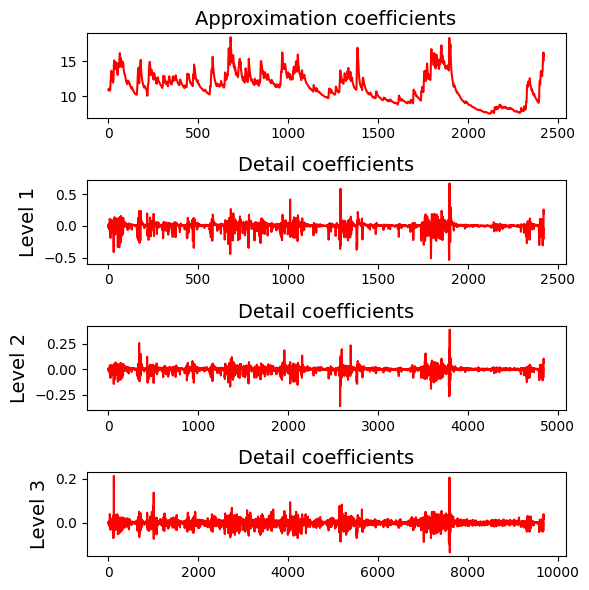

In [598]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 6))
for i, axis in enumerate(axes):
    axis.plot(coeffs[i], color='r')

    if i == 0:
        axis.set_title("Approximation coefficients", fontsize=14)
    else:
        axis.set_title("Detail coefficients", fontsize=14)
        axis.set_ylabel("Level {}".format(i), fontsize=14, rotation=90)

plt.tight_layout()
plt.show()

In [599]:
print(f'shapes of coefficients at each level:\ncD_3: {cD_3.shape}\ncD_2: {cD_2.shape}\ncD_1: {cD_1.shape}')

shapes of coefficients at each level:
cD_3: (2422,)
cD_2: (4844,)
cD_1: (9688,)


In [600]:
cD_1[0:4 * second_data_n_segments]

array([-0.00207211, -0.00310816, -0.00207211, ...,  0.02526961,
        0.02165966,  0.01804972])

In [601]:
cD_2[0:2 * second_data_n_segments]

array([-0.00805861, -0.0014652 ,  0.01025641, ...,  0.10465725,
        0.07147324,  0.06381539])

In [602]:
cD_3[0:second_data_n_segments]

array([-0.01605884,  0.02797346,  0.019167  , ..., -0.20757177,
        0.25991596,  0.193132  ])

In [603]:
4 * second_data_n_segments

9688

In [604]:
2 * second_data_n_segments

4844

In [605]:
coeff_1 = np.max(np.absolute(np.reshape(cD_1, newshape=(second_data_n_segments, 4))), axis=1)
coeff_2 = np.max(np.absolute(np.reshape(cD_2, newshape=(second_data_n_segments, 2))), axis=1)
coeff_3 = np.absolute(cD_3)
coeff_1, coeff_2, coeff_3

(array([0.00310816, 0.00621632, 0.00207211, ..., 0.03609944, 0.03970938,
        0.02526961]),
 array([0.00805861, 0.01318681, 0.0043956 , ..., 0.08168371, 0.10465725,
        0.07147324]),
 array([0.01605884, 0.02797346, 0.019167  , ..., 0.20757177, 0.25991596,
        0.193132  ]))

In [606]:
second_data_n_segments_half = int((second_data.shape[0] / 8) * 2)
second_data_n_segments_half

4844

In [607]:
# recall that cD_1 has shape of 9688 which is second_data_n_segments_half * 2
coeff_1_half = np.max(np.absolute(np.reshape(cD_1, newshape=(second_data_n_segments_half, 2))), axis=1)
coeff_2_half = np.absolute(cD_2)
coeff_1_half, coeff_2_half

(array([0.00310816, 0.00207211, 0.00518027, ..., 0.03970938, 0.02526961,
        0.02165966]),
 array([0.00805861, 0.0014652 , 0.01025641, ..., 0.10465725, 0.07147324,
        0.06381539]))

In [608]:
second_data_one_sec_wave_feats = pd.DataFrame({
    'first_one_sec_feat': coeff_1,
    'second_one_sec_feat': coeff_2,
    'third_one_sec_feat': coeff_3,
})
second_data_one_sec_wave_feats

first_one_sec_feat  second_one_sec_feat  third_one_sec_feat
0               0.003108             0.008059            0.016059
1               0.006216             0.013187            0.027973
2               0.002072             0.004396            0.019167
3               0.006216             0.013919            0.035744
4               0.003108             0.008791            0.023311
...                  ...                  ...                 ...
2417            0.021660             0.066368            0.108298
2418            0.014440             0.040842            0.025270
2419            0.036099             0.081684            0.207572
2420            0.039709             0.104657            0.259916
2421            0.025270             0.071473            0.193132

[2422 rows x 3 columns]

In [609]:
second_data_one_sec_wave_feats['time'] = second_data_1s_inc_ts[:second_data_one_sec_wave_feats.shape[0]]
second_data_one_sec_wave_feats

first_one_sec_feat  second_one_sec_feat  third_one_sec_feat  \
0               0.003108             0.008059            0.016059   
1               0.006216             0.013187            0.027973   
2               0.002072             0.004396            0.019167   
3               0.006216             0.013919            0.035744   
4               0.003108             0.008791            0.023311   
...                  ...                  ...                 ...   
2417            0.021660             0.066368            0.108298   
2418            0.014440             0.040842            0.025270   
2419            0.036099             0.081684            0.207572   
2420            0.039709             0.104657            0.259916   
2421            0.025270             0.071473            0.193132   

                    time  
0    1970-01-01 01:00:00  
1    1970-01-01 01:00:01  
2    1970-01-01 01:00:02  
3    1970-01-01 01:00:03  
4    1970-01-01 01:00:04  
...                  ...  
2417 1970-01-01 01:40:17  
2418 1970-01-01 01:40:18  
2419 1970-01-01 01:40:19  
2420 1970-01-01 01:40:20  
2421 1970-01-01 01:40:21  

[2422 rows x 4 columns]

In [610]:
second_data_half_sec_wave_feats = pd.DataFrame({
    'first_half_sec_feat': coeff_1_half,
    'second_half_sec_feat': coeff_2_half
})
second_data_half_sec_wave_feats

first_half_sec_feat  second_half_sec_feat
0                0.003108              0.008059
1                0.002072              0.001465
2                0.005180              0.010256
3                0.006216              0.013187
4                0.001036              0.004396
...                   ...                   ...
4839             0.014440              0.028079
4840             0.025270              0.068921
4841             0.039709              0.104657
4842             0.025270              0.071473
4843             0.021660              0.063815

[4844 rows x 2 columns]

In [611]:
second_data_half_sec_wave_feats['time'] = second_data_halfs_inc_ts[:second_data_half_sec_wave_feats.shape[0]]
second_data_half_sec_wave_feats

first_half_sec_feat  second_half_sec_feat                    time
0                0.003108              0.008059 1970-01-01 01:00:00.000
1                0.002072              0.001465 1970-01-01 01:00:00.500
2                0.005180              0.010256 1970-01-01 01:00:01.000
3                0.006216              0.013187 1970-01-01 01:00:01.500
4                0.001036              0.004396 1970-01-01 01:00:02.000
...                   ...                   ...                     ...
4839             0.014440              0.028079 1970-01-01 01:40:19.500
4840             0.025270              0.068921 1970-01-01 01:40:20.000
4841             0.039709              0.104657 1970-01-01 01:40:20.500
4842             0.025270              0.071473 1970-01-01 01:40:21.000
4843             0.021660              0.063815 1970-01-01 01:40:21.500

[4844 rows x 3 columns]

In [612]:
second_data_one_sec_wave_feats['time'] = second_data_one_sec_wave_feats['time'].apply(lambda timestamp: timestamp.timestamp())
second_data_half_sec_wave_feats['time'] = second_data_half_sec_wave_feats['time'].apply(lambda timestamp: timestamp.timestamp())

In [613]:
second_data_one_sec_wave_feats

first_one_sec_feat  second_one_sec_feat  third_one_sec_feat    time
0               0.003108             0.008059            0.016059  3600.0
1               0.006216             0.013187            0.027973  3601.0
2               0.002072             0.004396            0.019167  3602.0
3               0.006216             0.013919            0.035744  3603.0
4               0.003108             0.008791            0.023311  3604.0
...                  ...                  ...                 ...     ...
2417            0.021660             0.066368            0.108298  6017.0
2418            0.014440             0.040842            0.025270  6018.0
2419            0.036099             0.081684            0.207572  6019.0
2420            0.039709             0.104657            0.259916  6020.0
2421            0.025270             0.071473            0.193132  6021.0

[2422 rows x 4 columns]

In [614]:
second_data_half_sec_wave_feats

first_half_sec_feat  second_half_sec_feat    time
0                0.003108              0.008059  3600.0
1                0.002072              0.001465  3600.5
2                0.005180              0.010256  3601.0
3                0.006216              0.013187  3601.5
4                0.001036              0.004396  3602.0
...                   ...                   ...     ...
4839             0.014440              0.028079  6019.5
4840             0.025270              0.068921  6020.0
4841             0.039709              0.104657  6020.5
4842             0.025270              0.071473  6021.0
4843             0.021660              0.063815  6021.5

[4844 rows x 3 columns]

## Let's try extracting wavelets at 16hz

In [615]:
akakip_eda_df_16hz

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000     0.0000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.062500     0.0625    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.125000     0.1250    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.187500     0.1875    0.000000     -0.005128    0.0   
1970-01-01 00:00:00.250000     0.2500    0.000222      0.000222    0.0   
...                               ...         ...           ...    ...   
1970-01-01 01:40:21.687500  6021.6875    5.271152      5.271152    0.0   
1970-01-01 01:40:21.750000  6021.7500    5.255836      5.255836    0.0   
1970-01-01 01:40:21.812500  6021.8125    5.240520      5.240520    0.0   
1970-01-01 01:40:21.875000  6021.8750    5.230310      5.230310    0.0   
1970-01-01 01:40:21.937500  6021.9375    5.209889      5.209889    0.0   

                             auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.062500  1.357508e-05       1.0                 1.0   
1970-01-01 00:00:00.125000  2.747785e-05       1.0                 1.0   
1970-01-01 00:00:00.187500  5.611462e-05       1.0                 1.0   
1970-01-01 00:00:00.250000  1.260593e-04       1.0                 1.0   
...                                  ...       ...                 ...   
1970-01-01 01:40:21.687500  5.271152e+00       0.0                 0.0   
1970-01-01 01:40:21.750000  5.255836e+00       0.0                 0.0   
1970-01-01 01:40:21.812500  5.240520e+00       0.0                 0.0   
1970-01-01 01:40:21.875000  5.230310e+00       0.0                 0.0   
1970-01-01 01:40:21.937500  5.209889e+00       0.0                 0.0   

                            filtered_signal  
1970-01-01 00:00:00.000000     0.000000e+00  
1970-01-01 00:00:00.062500     0.000000e+00  
1970-01-01 00:00:00.125000     0.000000e+00  
1970-01-01 00:00:00.187500     0.000000e+00  
1970-01-01 00:00:00.250000     6.399354e-09  
...                                     ...  
1970-01-01 01:40:21.687500     5.441185e+00  
1970-01-01 01:40:21.750000     5.421049e+00  
1970-01-01 01:40:21.812500     5.401972e+00  
1970-01-01 01:40:21.875000     5.383830e+00  
1970-01-01 01:40:21.937500     5.366459e+00  

[96352 rows x 8 columns]

In [616]:
akakip_eda_df_16hz.iloc[16]

time                  1.000000
raw_signal            0.000222
clean_signal          0.000222
label                 0.000000
auto_signal           0.000222
pred_art              0.000000
post_proc_pred_art    0.000000
filtered_signal       0.000171
Name: 1970-01-01 00:00:01, dtype: float64

In [617]:
hertz = 16

In [618]:
# note this samples per sec is not arbitrary and a
# user defined value but derived from our frequency
# value entirely i.e. because we've recorded our
# raw data at 128hz then that means that the
# samples of data we have per second would be 128
samples_per_sec = hertz
secs_per_min = 60
min_per_hour = 60


# here we would be calculating how many samples we would have
# per hour given we have 128 samples per second
samples_per_hour = samples_per_sec * secs_per_min * min_per_hour

# we also need to specify how large our windows/epochs/segments
# would be in order to create the rows for our dataset and subsequently
# each feature of that window or row
window = 0.5
samples_per_05s = samples_per_sec * window

In [619]:
samples_per_hour

57600

In [620]:
samples_per_05s

8.0

In [621]:
# get number of rows of 128hz timestamps and signals
n_rows = akakip_eda_df_16hz.shape[0]
n_rows

96352

In [622]:
# dividing the number of rows by the number of samples per 0.5 seconds
# will allow us to get a sense how many segments or rows of 0.5 seconds
# can we get from this time series dataframe of our signals
num_labels = math.ceil(n_rows / samples_per_05s)
num_labels

12044

In [623]:
hours = math.ceil(n_rows / samples_per_hour)
hours

2

In [624]:
for hour in range(hours):
    start = hour * samples_per_hour
    end = min((hour + 1) * samples_per_hour, n_rows)
    print(f'start: {start} | end: {end}')

    curr_data = akakip_eda_df_16hz.iloc[start:end]
    print(curr_data)

start: 0 | end: 57600
                                 time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000     0.0000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.062500     0.0625    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.125000     0.1250    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.187500     0.1875    0.000000     -0.005128    0.0   
1970-01-01 00:00:00.250000     0.2500    0.000222      0.000222    0.0   
...                               ...         ...           ...    ...   
1970-01-01 00:59:59.687500  3599.6875    3.860073      3.860073    0.0   
1970-01-01 00:59:59.750000  3599.7500    3.861538      3.861538    0.0   
1970-01-01 00:59:59.812500  3599.8125    3.861538      3.861538    0.0   
1970-01-01 00:59:59.875000  3599.8750    3.861538      3.861538    0.0   
1970-01-01 00:59:59.937500  3599.9375    3.864469      3.864469    0.0   

                             auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:0

In [625]:
first_16hz_data = akakip_eda_df_16hz[0:57600]
first_16hz_data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000     0.0000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.062500     0.0625    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.125000     0.1250    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.187500     0.1875    0.000000     -0.005128    0.0   
1970-01-01 00:00:00.250000     0.2500    0.000222      0.000222    0.0   
...                               ...         ...           ...    ...   
1970-01-01 00:59:59.687500  3599.6875    3.860073      3.860073    0.0   
1970-01-01 00:59:59.750000  3599.7500    3.861538      3.861538    0.0   
1970-01-01 00:59:59.812500  3599.8125    3.861538      3.861538    0.0   
1970-01-01 00:59:59.875000  3599.8750    3.861538      3.861538    0.0   
1970-01-01 00:59:59.937500  3599.9375    3.864469      3.864469    0.0   

                             auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.062500  1.357508e-05       1.0                 1.0   
1970-01-01 00:00:00.125000  2.747785e-05       1.0                 1.0   
1970-01-01 00:00:00.187500  5.611462e-05       1.0                 1.0   
1970-01-01 00:00:00.250000  1.260593e-04       1.0                 1.0   
...                                  ...       ...                 ...   
1970-01-01 00:59:59.687500  3.860073e+00       0.0                 0.0   
1970-01-01 00:59:59.750000  3.861538e+00       0.0                 0.0   
1970-01-01 00:59:59.812500  3.861538e+00       0.0                 0.0   
1970-01-01 00:59:59.875000  3.861538e+00       0.0                 0.0   
1970-01-01 00:59:59.937500  3.864469e+00       0.0                 0.0   

                            filtered_signal  
1970-01-01 00:00:00.000000     0.000000e+00  
1970-01-01 00:00:00.062500     0.000000e+00  
1970-01-01 00:00:00.125000     0.000000e+00  
1970-01-01 00:00:00.187500     0.000000e+00  
1970-01-01 00:00:00.250000     6.399354e-09  
...                                     ...  
1970-01-01 00:59:59.687500     3.860706e+00  
1970-01-01 00:59:59.750000     3.861614e+00  
1970-01-01 00:59:59.812500     3.862303e+00  
1970-01-01 00:59:59.875000     3.862742e+00  
1970-01-01 00:59:59.937500     3.862928e+00  

[57600 rows x 8 columns]

In [626]:
first_16hz_data.iloc[::16]

time  raw_signal  clean_signal  label   auto_signal  \
1970-01-01 00:00:00     0.0    0.000000     -0.164015    0.0  2.106994e-20   
1970-01-01 00:00:01     1.0    0.000222      0.000222    0.0  2.220002e-04   
1970-01-01 00:00:02     2.0    0.000222      0.000222    0.0  2.220002e-04   
1970-01-01 00:00:03     3.0    0.000222      0.000222    0.0  2.220002e-04   
1970-01-01 00:00:04     4.0    0.000222      0.000222    0.0  2.220002e-04   
...                     ...         ...           ...    ...           ...   
1970-01-01 00:59:55  3595.0    3.845421      3.848897    1.0  3.845421e+00   
1970-01-01 00:59:56  3596.0    3.842491      3.850135    1.0  3.842491e+00   
1970-01-01 00:59:57  3597.0    3.819048      3.828657    1.0  3.819048e+00   
1970-01-01 00:59:58  3598.0    3.823443      3.826463    1.0  3.823443e+00   
1970-01-01 00:59:59  3599.0    3.857143      3.857143    0.0  3.857143e+00   

                     pred_art  post_proc_pred_art  filtered_signal  
1970-01-01 00:00:00       1.0                 1.0         0.000000  
1970-01-01 00:00:01       0.0                 0.0         0.000171  
1970-01-01 00:00:02       0.0                 0.0         0.000213  
1970-01-01 00:00:03       0.0                 0.0         0.000220  
1970-01-01 00:00:04       0.0                 0.0         0.000222  
...                       ...                 ...              ...  
1970-01-01 00:59:55       0.0                 0.0         3.804984  
1970-01-01 00:59:56       0.0                 0.0         3.844669  
1970-01-01 00:59:57       0.0                 0.0         3.811786  
1970-01-01 00:59:58       0.0                 0.0         3.830790  
1970-01-01 00:59:59       0.0                 0.0         3.840992  

[3600 rows x 8 columns]

In [627]:
first_16hz_data.iloc[::8]

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000     0.0    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.500     0.5    0.000222      0.000222    0.0   
1970-01-01 00:00:01.000     1.0    0.000222      0.000222    0.0   
1970-01-01 00:00:01.500     1.5    0.000222      0.000222    0.0   
1970-01-01 00:00:02.000     2.0    0.000222      0.000222    0.0   
...                         ...         ...           ...    ...   
1970-01-01 00:59:57.500  3597.5    3.816117      3.822525    1.0   
1970-01-01 00:59:58.000  3598.0    3.823443      3.826463    1.0   
1970-01-01 00:59:58.500  3598.5    3.845421      3.845421    0.0   
1970-01-01 00:59:59.000  3599.0    3.857143      3.857143    0.0   
1970-01-01 00:59:59.500  3599.5    3.860073      3.860073    0.0   

                          auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.500  2.196768e-04       0.0                 0.0   
1970-01-01 00:00:01.000  2.220002e-04       0.0                 0.0   
1970-01-01 00:00:01.500  2.220002e-04       0.0                 0.0   
1970-01-01 00:00:02.000  2.220002e-04       0.0                 0.0   
...                               ...       ...                 ...   
1970-01-01 00:59:57.500  3.816117e+00       0.0                 0.0   
1970-01-01 00:59:58.000  3.823443e+00       0.0                 0.0   
1970-01-01 00:59:58.500  3.845421e+00       0.0                 0.0   
1970-01-01 00:59:59.000  3.857143e+00       0.0                 0.0   
1970-01-01 00:59:59.500  3.860073e+00       0.0                 0.0   

                         filtered_signal  
1970-01-01 00:00:00.000         0.000000  
1970-01-01 00:00:00.500         0.000004  
1970-01-01 00:00:01.000         0.000171  
1970-01-01 00:00:01.500         0.000242  
1970-01-01 00:00:02.000         0.000213  
...                                  ...  
1970-01-01 00:59:57.500         3.803501  
1970-01-01 00:59:58.000         3.830790  
1970-01-01 00:59:58.500         3.816448  
1970-01-01 00:59:59.000         3.840992  
1970-01-01 00:59:59.500         3.857189  

[7200 rows x 8 columns]

In [628]:
second_16hz_data = akakip_eda_df_16hz[57600:96352]
second_16hz_data

time  raw_signal  clean_signal  label  \
1970-01-01 01:00:00.000000  3600.0000    3.863004      3.863004    0.0   
1970-01-01 01:00:00.062500  3600.0625    3.864469      3.864469    0.0   
1970-01-01 01:00:00.125000  3600.1250    3.865934      3.865934    0.0   
1970-01-01 01:00:00.187500  3600.1875    3.868864      3.868864    0.0   
1970-01-01 01:00:00.250000  3600.2500    3.870330      3.870330    0.0   
...                               ...         ...           ...    ...   
1970-01-01 01:40:21.687500  6021.6875    5.271152      5.271152    0.0   
1970-01-01 01:40:21.750000  6021.7500    5.255836      5.255836    0.0   
1970-01-01 01:40:21.812500  6021.8125    5.240520      5.240520    0.0   
1970-01-01 01:40:21.875000  6021.8750    5.230310      5.230310    0.0   
1970-01-01 01:40:21.937500  6021.9375    5.209889      5.209889    0.0   

                            auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 01:00:00.000000     3.863004       0.0                 0.0   
1970-01-01 01:00:00.062500     3.864469       0.0                 0.0   
1970-01-01 01:00:00.125000     3.865934       0.0                 0.0   
1970-01-01 01:00:00.187500     3.868864       0.0                 0.0   
1970-01-01 01:00:00.250000     3.870330       0.0                 0.0   
...                                 ...       ...                 ...   
1970-01-01 01:40:21.687500     5.271152       0.0                 0.0   
1970-01-01 01:40:21.750000     5.255836       0.0                 0.0   
1970-01-01 01:40:21.812500     5.240520       0.0                 0.0   
1970-01-01 01:40:21.875000     5.230310       0.0                 0.0   
1970-01-01 01:40:21.937500     5.209889       0.0                 0.0   

                            filtered_signal  
1970-01-01 01:00:00.000000         3.862887  
1970-01-01 01:00:00.062500         3.862668  
1970-01-01 01:00:00.125000         3.862339  
1970-01-01 01:00:00.187500         3.861977  
1970-01-01 01:00:00.250000         3.861660  
...                                     ...  
1970-01-01 01:40:21.687500         5.441185  
1970-01-01 01:40:21.750000         5.421049  
1970-01-01 01:40:21.812500         5.401972  
1970-01-01 01:40:21.875000         5.383830  
1970-01-01 01:40:21.937500         5.366459  

[38752 rows x 8 columns]

In [629]:
first_16hz_timestamp_list = pd.to_datetime(first_16hz_data['time'].iloc[0::8], unit='s')
first_16hz_timestamp_list

1970-01-01 00:00:00.000   1970-01-01 00:00:00.000
1970-01-01 00:00:00.500   1970-01-01 00:00:00.500
1970-01-01 00:00:01.000   1970-01-01 00:00:01.000
1970-01-01 00:00:01.500   1970-01-01 00:00:01.500
1970-01-01 00:00:02.000   1970-01-01 00:00:02.000
                                    ...          
1970-01-01 00:59:57.500   1970-01-01 00:59:57.500
1970-01-01 00:59:58.000   1970-01-01 00:59:58.000
1970-01-01 00:59:58.500   1970-01-01 00:59:58.500
1970-01-01 00:59:59.000   1970-01-01 00:59:59.000
1970-01-01 00:59:59.500   1970-01-01 00:59:59.500
Freq: 500000us, Name: time, Length: 7200, dtype: datetime64[ns]

In [630]:
first_16hz_data_halfas_inc_ts = pd.date_range(start=first_16hz_timestamp_list[0], periods=first_16hz_data.shape[0], freq='500ms')
first_16hz_data_quartofas_inc_ts = pd.date_range(start=first_16hz_timestamp_list[0], periods=first_16hz_data.shape[0], freq='250ms')
first_16hz_data_halfas_inc_ts, first_16hz_data_quartofas_inc_ts

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\1910629175.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_16hz_data_halfas_inc_ts = pd.date_range(start=first_16hz_timestamp_list[0], periods=first_16hz_data.shape[0], freq='500ms')
C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\1910629175.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_16hz_data_quartofas_inc_ts = pd.date_range(start=first_16hz_timestamp_list[0], periods=first_16hz_data.shape[0], freq='250ms')


(DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.500000',
                       '1970-01-01 00:00:01', '1970-01-01 00:00:01.500000',
                       '1970-01-01 00:00:02', '1970-01-01 00:00:02.500000',
                       '1970-01-01 00:00:03', '1970-01-01 00:00:03.500000',
                       '1970-01-01 00:00:04', '1970-01-01 00:00:04.500000',
                ...
                       '1970-01-01 07:59:55', '1970-01-01 07:59:55.500000',
                       '1970-01-01 07:59:56', '1970-01-01 07:59:56.500000',
                       '1970-01-01 07:59:57', '1970-01-01 07:59:57.500000',
                       '1970-01-01 07:59:58', '1970-01-01 07:59:58.500000',
                       '1970-01-01 07:59:59', '1970-01-01 07:59:59.500000'],
               dtype='datetime64[ns]', length=57600, freq='500ms'),
 DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.250000',
                '1970-01-01 00:00:00.500000', '1970-01-01 00:00:00.750000',

In [631]:
coeffs = pywt.wavedec(first_16hz_data['raw_signal'], wavelet='haar', level=3)
cA_3, cD_1, cD_2, cD_3 = coeffs
cD_3.shape, cD_2.shape, cD_1.shape

((28800,), (14400,), (7200,))

In [632]:
first_16hz_data_halfas_inc_ts[:7200]

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.500000',
                      '1970-01-01 00:00:01', '1970-01-01 00:00:01.500000',
                      '1970-01-01 00:00:02', '1970-01-01 00:00:02.500000',
                      '1970-01-01 00:00:03', '1970-01-01 00:00:03.500000',
                      '1970-01-01 00:00:04', '1970-01-01 00:00:04.500000',
               ...
                      '1970-01-01 00:59:55', '1970-01-01 00:59:55.500000',
                      '1970-01-01 00:59:56', '1970-01-01 00:59:56.500000',
                      '1970-01-01 00:59:57', '1970-01-01 00:59:57.500000',
                      '1970-01-01 00:59:58', '1970-01-01 00:59:58.500000',
                      '1970-01-01 00:59:59', '1970-01-01 00:59:59.500000'],
              dtype='datetime64[ns]', length=7200, freq='500ms')

In [633]:
first_16hz_data_quartofas_inc_ts[:14400]

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.250000',
               '1970-01-01 00:00:00.500000', '1970-01-01 00:00:00.750000',
                      '1970-01-01 00:00:01', '1970-01-01 00:00:01.250000',
               '1970-01-01 00:00:01.500000', '1970-01-01 00:00:01.750000',
                      '1970-01-01 00:00:02', '1970-01-01 00:00:02.250000',
               ...
               '1970-01-01 00:59:57.500000', '1970-01-01 00:59:57.750000',
                      '1970-01-01 00:59:58', '1970-01-01 00:59:58.250000',
               '1970-01-01 00:59:58.500000', '1970-01-01 00:59:58.750000',
                      '1970-01-01 00:59:59', '1970-01-01 00:59:59.250000',
               '1970-01-01 00:59:59.500000', '1970-01-01 00:59:59.750000'],
              dtype='datetime64[ns]', length=14400, freq='250ms')

## we know now how to extract the wavelet coefficients of signals at 8hz. How about now we do the official stuff of using now oiur 128hz signals to extract these wavelet coefficients, and also interpolating it to 16hz and then extracting then the wavelet coefficients

In [634]:
akakip_eda_df

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.164015    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:40:21.945312500  6021.945312    5.214994      5.214994    0.0   
1970-01-01 01:40:21.953125000  6021.953125    5.209889      5.209889    0.0   
1970-01-01 01:40:21.960937500  6021.960938    5.209889      5.209889    0.0   
1970-01-01 01:40:21.968750000  6021.968750    5.204784      5.204784    0.0   
1970-01-01 01:40:21.976562500  6021.976562    5.204784      5.204784    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 01:40:21.945312500  5.214994e+00       0.0                 0.0   
1970-01-01 01:40:21.953125000  5.209889e+00       0.0                 0.0   
1970-01-01 01:40:21.960937500  5.209889e+00       0.0                 0.0   
1970-01-01 01:40:21.968750000  5.204784e+00       0.0                 0.0   
1970-01-01 01:40:21.976562500  5.204784e+00       0.0                 0.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 01:40:21.945312500         5.368299  
1970-01-01 01:40:21.953125000         5.366143  
1970-01-01 01:40:21.960937500         5.363993  
1970-01-01 01:40:21.968750000         5.361849  
1970-01-01 01:40:21.976562500         5.359710  

[770814 rows x 8 columns]

In [635]:
akakip_eda_df.iloc[128]

time                  1.000000
raw_signal            0.000222
clean_signal          0.000222
label                 0.000000
auto_signal           0.000222
pred_art              0.000000
post_proc_pred_art    0.000000
filtered_signal       0.000163
Name: 1970-01-01 00:00:01, dtype: float64

## This is what we've calculated earlier and as we can see we in our 16hz downsampled version of our 128hz signals we increment by 0.0625 seconds each row, and increment by 16 rows before we get to a full second

In [636]:
hertz = 128

In [637]:
# note this samples per sec is not arbitrary and a
# user defined value but derived from our frequency
# value entirely i.e. because we've recorded our
# raw data at 128hz then that means that the
# samples of data we have per second would be 128
samples_per_sec = hertz
secs_per_min = 60
min_per_hour = 60


# here we would be calculating how many samples we would have
# per hour given we have 128 samples per second
samples_per_hour = samples_per_sec * secs_per_min * min_per_hour

# we also need to specify how large our windows/epochs/segments
# would be in order to create the rows for our dataset and subsequently
# each feature of that window or row
window = 0.5
samples_per_05s = samples_per_sec * window

In [638]:
samples_per_hour

460800

In [639]:
samples_per_05s

64.0

In [640]:
# get number of rows of 128hz timestamps and signals
n_rows = akakip_eda_df.shape[0]

In [641]:
math.ceil(n_rows / samples_per_05s)

12044

In [642]:
math.ceil(n_rows / samples_per_hour)

2

In [643]:
np.ceil(n_rows / samples_per_05s)

12044.0

In [644]:
# dividing the number of rows by the number of samples per 0.5 seconds
# will allow us to get a sense how many segments or rows of 0.5 seconds
# can we get from this time series dataframe of our signals
num_labels = math.ceil(n_rows / samples_per_05s)

#
hours = math.ceil(n_rows / samples_per_hour)

In [645]:
num_labels

12044

In [646]:
hours

2

In [647]:
for hour in range(hours):
    start = hour * samples_per_hour
    end = min((hour + 1) * samples_per_hour, n_rows)
    print(f'start: {start} | end: {end}')

    curr_data = akakip_eda_df.iloc[start:end]
    print(curr_data)

start: 0 | end: 460800
                                      time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.164015    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 00:59:59.960937500  3599.960938    3.858608      3.858608    0.0   
1970-01-01 00:59:59.968750000  3599.968750    3.864469      3.864469    0.0   
1970-01-01 00:59:59.976562500  3599.976562    3.848352      3.848352    0.0   
1970-01-01 00:59:59.984375000  3599.984375    3.861538      3.861538    0.0   
1970-01-01 00:59:59.992187500  3599.992188    3.868864      3.868864    0.0   

                            

start: 0 | end: 460800
[460800 rows x 8 columns]

start: 460800 | end: 770814
[310014 rows x 8 columns]

Now we commence calculating wavelet coefficients at each 1 hour slice of our signal data

with each slice of data let's create a timestamp Series that increases every 0.5s which we know is 64 rows

In [648]:
first_128hz_data = akakip_eda_df[0:460800]
first_128hz_data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.164015    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 00:59:59.960937500  3599.960938    3.858608      3.858608    0.0   
1970-01-01 00:59:59.968750000  3599.968750    3.864469      3.864469    0.0   
1970-01-01 00:59:59.976562500  3599.976562    3.848352      3.848352    0.0   
1970-01-01 00:59:59.984375000  3599.984375    3.861538      3.861538    0.0   
1970-01-01 00:59:59.992187500  3599.992188    3.868864      3.868864    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 00:59:59.960937500  3.858608e+00       0.0                 0.0   
1970-01-01 00:59:59.968750000  3.864469e+00       0.0                 0.0   
1970-01-01 00:59:59.976562500  3.848352e+00       0.0                 0.0   
1970-01-01 00:59:59.984375000  3.861538e+00       0.0                 0.0   
1970-01-01 00:59:59.992187500  3.868864e+00       0.0                 0.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 00:59:59.960937500         3.860749  
1970-01-01 00:59:59.968750000         3.860688  
1970-01-01 00:59:59.976562500         3.860622  
1970-01-01 00:59:59.984375000         3.860554  
1970-01-01 00:59:59.992187500         3.860481  

[460800 rows x 8 columns]

In [649]:
first_128hz_data[::64]

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000     0.0    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.500     0.5    0.000222      0.000222    0.0   
1970-01-01 00:00:01.000     1.0    0.000222      0.000222    0.0   
1970-01-01 00:00:01.500     1.5    0.000222      0.000222    0.0   
1970-01-01 00:00:02.000     2.0    0.000222      0.000222    0.0   
...                         ...         ...           ...    ...   
1970-01-01 00:59:57.500  3597.5    3.816117      3.822525    1.0   
1970-01-01 00:59:58.000  3598.0    3.823443      3.826463    1.0   
1970-01-01 00:59:58.500  3598.5    3.845421      3.845421    0.0   
1970-01-01 00:59:59.000  3599.0    3.857143      3.857143    0.0   
1970-01-01 00:59:59.500  3599.5    3.860073      3.860073    0.0   

                          auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.500  2.196768e-04       0.0                 0.0   
1970-01-01 00:00:01.000  2.220002e-04       0.0                 0.0   
1970-01-01 00:00:01.500  2.220002e-04       0.0                 0.0   
1970-01-01 00:00:02.000  2.220002e-04       0.0                 0.0   
...                               ...       ...                 ...   
1970-01-01 00:59:57.500  3.816117e+00       0.0                 0.0   
1970-01-01 00:59:58.000  3.823443e+00       0.0                 0.0   
1970-01-01 00:59:58.500  3.845421e+00       0.0                 0.0   
1970-01-01 00:59:59.000  3.857143e+00       0.0                 0.0   
1970-01-01 00:59:59.500  3.860073e+00       0.0                 0.0   

                         filtered_signal  
1970-01-01 00:00:00.000         0.000000  
1970-01-01 00:00:00.500         0.000003  
1970-01-01 00:00:01.000         0.000163  
1970-01-01 00:00:01.500         0.000243  
1970-01-01 00:00:02.000         0.000213  
...                                  ...  
1970-01-01 00:59:57.500         3.802394  
1970-01-01 00:59:58.000         3.828741  
1970-01-01 00:59:58.500         3.816479  
1970-01-01 00:59:59.000         3.841858  
1970-01-01 00:59:59.500         3.856896  

[7200 rows x 8 columns]

In [650]:
second_128hz_data = akakip_eda_df[460800:770814]
second_128hz_data

time  raw_signal  clean_signal  label  \
1970-01-01 01:00:00.000000000  3600.000000    3.863004      3.863004    0.0   
1970-01-01 01:00:00.007812500  3600.007812    3.842491      3.842491    0.0   
1970-01-01 01:00:00.015625000  3600.015625    3.861538      3.861538    0.0   
1970-01-01 01:00:00.023437500  3600.023438    3.858608      3.858608    0.0   
1970-01-01 01:00:00.031250000  3600.031250    3.867399      3.867399    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:40:21.945312500  6021.945312    5.214994      5.214994    0.0   
1970-01-01 01:40:21.953125000  6021.953125    5.209889      5.209889    0.0   
1970-01-01 01:40:21.960937500  6021.960938    5.209889      5.209889    0.0   
1970-01-01 01:40:21.968750000  6021.968750    5.204784      5.204784    0.0   
1970-01-01 01:40:21.976562500  6021.976562    5.204784      5.204784    0.0   

                               auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 01:00:00.000000000     3.863004       0.0                 0.0   
1970-01-01 01:00:00.007812500     3.842491       0.0                 0.0   
1970-01-01 01:00:00.015625000     3.861538       0.0                 0.0   
1970-01-01 01:00:00.023437500     3.858608       0.0                 0.0   
1970-01-01 01:00:00.031250000     3.867399       0.0                 0.0   
...                                    ...       ...                 ...   
1970-01-01 01:40:21.945312500     5.214994       0.0                 0.0   
1970-01-01 01:40:21.953125000     5.209889       0.0                 0.0   
1970-01-01 01:40:21.960937500     5.209889       0.0                 0.0   
1970-01-01 01:40:21.968750000     5.204784       0.0                 0.0   
1970-01-01 01:40:21.976562500     5.204784       0.0                 0.0   

                               filtered_signal  
1970-01-01 01:00:00.000000000         3.860405  
1970-01-01 01:00:00.007812500         3.860326  
1970-01-01 01:00:00.015625000         3.860244  
1970-01-01 01:00:00.023437500         3.860159  
1970-01-01 01:00:00.031250000         3.860072  
...                                        ...  
1970-01-01 01:40:21.945312500         5.368299  
1970-01-01 01:40:21.953125000         5.366143  
1970-01-01 01:40:21.960937500         5.363993  
1970-01-01 01:40:21.968750000         5.361849  
1970-01-01 01:40:21.976562500         5.359710  

[310014 rows x 8 columns]

In [651]:
second_128hz_data[0::64]

time  raw_signal  clean_signal  label  auto_signal  \
1970-01-01 01:00:00.000  3600.0    3.863004      3.863004    0.0     3.863004   
1970-01-01 01:00:00.500  3600.5    3.877656      3.877656    0.0     3.877656   
1970-01-01 01:00:01.000  3601.0    3.876190      3.876190    0.0     3.876190   
1970-01-01 01:00:01.500  3601.5    3.860073      3.860073    0.0     3.860073   
1970-01-01 01:00:02.000  3602.0    3.838095      3.838095    0.0     3.838095   
...                         ...         ...           ...    ...          ...   
1970-01-01 01:40:19.500  6019.5    5.796990      5.796990    0.0     5.796990   
1970-01-01 01:40:20.000  6020.0    5.822517      5.822517    0.0     5.822517   
1970-01-01 01:40:20.500  6020.5    5.669360      5.669360    0.0     5.669360   
1970-01-01 01:40:21.000  6021.0    5.465150      5.465150    0.0     5.465150   
1970-01-01 01:40:21.500  6021.5    5.322204      5.322204    0.0     5.322204   

                         pred_art  post_proc_pred_art  filtered_signal  
1970-01-01 01:00:00.000       0.0                 0.0         3.860405  
1970-01-01 01:00:00.500       0.0                 0.0         3.856753  
1970-01-01 01:00:01.000       0.0                 0.0         3.867677  
1970-01-01 01:00:01.500       0.0                 0.0         3.872410  
1970-01-01 01:00:02.000       0.0                 0.0         3.856372  
...                           ...                 ...              ...  
1970-01-01 01:40:19.500       0.0                 0.0         5.584995  
1970-01-01 01:40:20.000       0.0                 0.0         5.742156  
1970-01-01 01:40:20.500       0.0                 0.0         5.838199  
1970-01-01 01:40:21.000       0.0                 0.0         5.713530  
1970-01-01 01:40:21.500       0.0                 0.0         5.510652  

[4844 rows x 8 columns]

## now we create a timestamp that increments every 0.5 seconds

In [652]:
first_128hz_timestamp_list = pd.to_datetime(first_128hz_data['time'].iloc[0::64], unit='s')
first_128hz_timestamp_list

1970-01-01 00:00:00.000   1970-01-01 00:00:00.000
1970-01-01 00:00:00.500   1970-01-01 00:00:00.500
1970-01-01 00:00:01.000   1970-01-01 00:00:01.000
1970-01-01 00:00:01.500   1970-01-01 00:00:01.500
1970-01-01 00:00:02.000   1970-01-01 00:00:02.000
                                    ...          
1970-01-01 00:59:57.500   1970-01-01 00:59:57.500
1970-01-01 00:59:58.000   1970-01-01 00:59:58.000
1970-01-01 00:59:58.500   1970-01-01 00:59:58.500
1970-01-01 00:59:59.000   1970-01-01 00:59:59.000
1970-01-01 00:59:59.500   1970-01-01 00:59:59.500
Freq: 500000000ns, Name: time, Length: 7200, dtype: datetime64[ns]

In [653]:
first_128hz_data_16thofas_inc_ts = pd.date_range(start=first_128hz_timestamp_list[0], periods=first_128hz_data.shape[0], freq='62.5ms')
first_128hz_data_32thofas_inc_ts = pd.date_range(start=first_128hz_timestamp_list[0], periods=first_128hz_data.shape[0], freq='31.25ms')
first_128hz_data_16thofas_inc_ts, first_128hz_data_32thofas_inc_ts

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\355128833.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_128hz_data_16thofas_inc_ts = pd.date_range(start=first_128hz_timestamp_list[0], periods=first_128hz_data.shape[0], freq='62.5ms')
C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\355128833.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_128hz_data_32thofas_inc_ts = pd.date_range(start=first_128hz_timestamp_list[0], periods=first_128hz_data.shape[0], freq='31.25ms')


(DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.062500',
                '1970-01-01 00:00:00.125000', '1970-01-01 00:00:00.187500',
                '1970-01-01 00:00:00.250000', '1970-01-01 00:00:00.312500',
                '1970-01-01 00:00:00.375000', '1970-01-01 00:00:00.437500',
                '1970-01-01 00:00:00.500000', '1970-01-01 00:00:00.562500',
                ...
                '1970-01-01 07:59:59.375000', '1970-01-01 07:59:59.437500',
                '1970-01-01 07:59:59.500000', '1970-01-01 07:59:59.562500',
                '1970-01-01 07:59:59.625000', '1970-01-01 07:59:59.687500',
                '1970-01-01 07:59:59.750000', '1970-01-01 07:59:59.812500',
                '1970-01-01 07:59:59.875000', '1970-01-01 07:59:59.937500'],
               dtype='datetime64[ns]', length=460800, freq='62500us'),
 DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.031250',
                '1970-01-01 00:00:00.062500', '1970-01-01 00:00:00.09375

In [654]:
pd.date_range(start=first_128hz_timestamp_list[0], periods=first_128hz_data.shape[0], freq='125ms')[:57600]

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\2223505187.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.date_range(start=first_128hz_timestamp_list[0], periods=first_128hz_data.shape[0], freq='125ms')[:57600]


DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.125000',
               '1970-01-01 00:00:00.250000', '1970-01-01 00:00:00.375000',
               '1970-01-01 00:00:00.500000', '1970-01-01 00:00:00.625000',
               '1970-01-01 00:00:00.750000', '1970-01-01 00:00:00.875000',
                      '1970-01-01 00:00:01', '1970-01-01 00:00:01.125000',
               ...
               '1970-01-01 01:59:58.750000', '1970-01-01 01:59:58.875000',
                      '1970-01-01 01:59:59', '1970-01-01 01:59:59.125000',
               '1970-01-01 01:59:59.250000', '1970-01-01 01:59:59.375000',
               '1970-01-01 01:59:59.500000', '1970-01-01 01:59:59.625000',
               '1970-01-01 01:59:59.750000', '1970-01-01 01:59:59.875000'],
              dtype='datetime64[ns]', length=57600, freq='125ms')

## 57600 is the number of rows of our wavelet dataframe that we will create later therefore it is only right that we have a list of timestamps that end at 57600 rows at exactly one hour, which in this case when we index `first_128hz_data_16thofas_inc_ts[57600]` then we should get almost one hour. And this sets up our wvelet dataframe to be indeed

In [655]:
first_128hz_data_16thofas_inc_ts[:57600]

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.062500',
               '1970-01-01 00:00:00.125000', '1970-01-01 00:00:00.187500',
               '1970-01-01 00:00:00.250000', '1970-01-01 00:00:00.312500',
               '1970-01-01 00:00:00.375000', '1970-01-01 00:00:00.437500',
               '1970-01-01 00:00:00.500000', '1970-01-01 00:00:00.562500',
               ...
               '1970-01-01 00:59:59.375000', '1970-01-01 00:59:59.437500',
               '1970-01-01 00:59:59.500000', '1970-01-01 00:59:59.562500',
               '1970-01-01 00:59:59.625000', '1970-01-01 00:59:59.687500',
               '1970-01-01 00:59:59.750000', '1970-01-01 00:59:59.812500',
               '1970-01-01 00:59:59.875000', '1970-01-01 00:59:59.937500'],
              dtype='datetime64[ns]', length=57600, freq='62500us')

In [656]:
first_128hz_data_32thofas_inc_ts[:115200]

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.031250',
               '1970-01-01 00:00:00.062500', '1970-01-01 00:00:00.093750',
               '1970-01-01 00:00:00.125000', '1970-01-01 00:00:00.156250',
               '1970-01-01 00:00:00.187500', '1970-01-01 00:00:00.218750',
               '1970-01-01 00:00:00.250000', '1970-01-01 00:00:00.281250',
               ...
               '1970-01-01 00:59:59.687500', '1970-01-01 00:59:59.718750',
               '1970-01-01 00:59:59.750000', '1970-01-01 00:59:59.781250',
               '1970-01-01 00:59:59.812500', '1970-01-01 00:59:59.843750',
               '1970-01-01 00:59:59.875000', '1970-01-01 00:59:59.906250',
               '1970-01-01 00:59:59.937500', '1970-01-01 00:59:59.968750'],
              dtype='datetime64[ns]', length=115200, freq='31250us')

## now we calculate the wavelet features for both a second and a half second for the 128hz signals

In [657]:
# we know we have 128 samples per second and a total of 460800 samples per hour
# and we want to know how many in total there are 128 sample segments
first_128hz_data_n_segments = int(first_128hz_data.shape[0] / samples_per_sec)
first_128hz_data_n_segments

3600

In [658]:
first_128hz_data_n_segments

3600

In [659]:
# this returns an ordered list [cA_n, cD_n, cD_n-1, …, cD2, cD1]
# of coefficients arrays where n denotes the level of decomposition.
# The first element (cA_n) of the result is approximation
# coefficients array and the following elements (cD_n - cD_1) are
# details coefficients arrays. So for instance if I had a level of 3
# I would get the coefficients cA_3, cD_3, cD_2, cD_1, where cD_3 to cD_1
# would be the details coefficient arrays at each level
first_128hz_one_sec_coeffs = pywt.wavedec(first_128hz_data['raw_signal'], wavelet='haar', level=3)
first_128hz_one_sec_coeffs

[array([ 0.        ,  0.        ,  0.        , ..., 10.91793591,
        10.91068354, 10.9137917 ]),
 array([ 0.        ,  0.        ,  0.        , ..., -0.01450475,
        -0.00518027, -0.00621632]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.0029304 ,
        -0.0043956 , -0.00879121]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01139659, -0.00518027])]

In [660]:
first_128hz_one_sec_cA_3, first_128hz_one_sec_cD_3, first_128hz_one_sec_cD_2, first_128hz_one_sec_cD_1 = first_128hz_one_sec_coeffs
first_128hz_one_sec_cD_1.shape

(230400,)

In [661]:
first_128hz_one_sec_cD_2.shape

(115200,)

In [662]:
first_128hz_one_sec_cD_3.shape

(57600,)

In [663]:
n_rows_wavelet = first_128hz_one_sec_cD_3.shape[0]
n_rows_wavelet

57600

In [664]:
n_rows_wavelet * 4

230400

## The reason why we now had to get the absolute maximum of the third oen second coefficient was because unlike previously where our n_segments of 3600 for 8hz signals mathced also the shape of the 8hz signals of the third one second coefficient which was also 3600 we now have to reshape 57600 such that it becomes 3600 by some number. What matters is we still have

In [665]:
first_128hz_16thofa_sec_coeff_1 = np.max(np.absolute(np.reshape(first_128hz_one_sec_cD_1[:n_rows_wavelet * 4], newshape=(n_rows_wavelet, 4))), axis=1)
first_128hz_16thofa_sec_coeff_2 = np.max(np.absolute(np.reshape(first_128hz_one_sec_cD_2[:n_rows_wavelet * 2], newshape=(n_rows_wavelet, 2))), axis=1)
first_128hz_16thofa_sec_coeff_3 = np.absolute(first_128hz_one_sec_cD_3[:n_rows_wavelet])

In [666]:
first_128hz_16thofa_sec_coeff_1.shape, first_128hz_16thofa_sec_coeff_2.shape, first_128hz_16thofa_sec_coeff_3.shape

((57600,), (57600,), (57600,))

In [667]:
first_128hz_data_16thofa_sec_wave_feats = pd.DataFrame({
    'first_16thofa_sec_feat': first_128hz_16thofa_sec_coeff_1,
    'second_16thofa_sec_feat': first_128hz_16thofa_sec_coeff_2,
    'third_16thofa_sec_feat': first_128hz_16thofa_sec_coeff_3,
})
first_128hz_data_16thofa_sec_wave_feats

first_16thofa_sec_feat  second_16thofa_sec_feat  third_16thofa_sec_feat
0                    0.000000                 0.000000                0.000000
1                    0.000000                 0.000000                0.000000
2                    0.000000                 0.000000                0.000000
3                    0.000000                 0.000222                0.000157
4                    0.000000                 0.000000                0.000000
...                       ...                      ...                     ...
57595                0.013469                 0.010989                0.005180
57596                0.013469                 0.004396                0.001554
57597                0.014505                 0.005861                0.014505
57598                0.013469                 0.007326                0.005180
57599                0.014505                 0.008791                0.006216

[57600 rows x 3 columns]

In [668]:
first_128hz_data_16thofa_sec_wave_feats.set_index(first_128hz_data_16thofas_inc_ts[:first_128hz_data_16thofa_sec_wave_feats.shape[0]], inplace=True)
first_128hz_data_16thofa_sec_wave_feats

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 00:00:00.000000                0.000000                 0.000000   
1970-01-01 00:00:00.062500                0.000000                 0.000000   
1970-01-01 00:00:00.125000                0.000000                 0.000000   
1970-01-01 00:00:00.187500                0.000000                 0.000222   
1970-01-01 00:00:00.250000                0.000000                 0.000000   
...                                            ...                      ...   
1970-01-01 00:59:59.687500                0.013469                 0.010989   
1970-01-01 00:59:59.750000                0.013469                 0.004396   
1970-01-01 00:59:59.812500                0.014505                 0.005861   
1970-01-01 00:59:59.875000                0.013469                 0.007326   
1970-01-01 00:59:59.937500                0.014505                 0.008791   

                            third_16thofa_sec_feat  
1970-01-01 00:00:00.000000                0.000000  
1970-01-01 00:00:00.062500                0.000000  
1970-01-01 00:00:00.125000                0.000000  
1970-01-01 00:00:00.187500                0.000157  
1970-01-01 00:00:00.250000                0.000000  
...                                            ...  
1970-01-01 00:59:59.687500                0.005180  
1970-01-01 00:59:59.750000                0.001554  
1970-01-01 00:59:59.812500                0.014505  
1970-01-01 00:59:59.875000                0.005180  
1970-01-01 00:59:59.937500                0.006216  

[57600 rows x 3 columns]

In [669]:
first_128hz_data_16thofa_sec_wave_feats[0:16]

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 00:00:00.000000                     0.0                 0.000000   
1970-01-01 00:00:00.062500                     0.0                 0.000000   
1970-01-01 00:00:00.125000                     0.0                 0.000000   
1970-01-01 00:00:00.187500                     0.0                 0.000222   
1970-01-01 00:00:00.250000                     0.0                 0.000000   
1970-01-01 00:00:00.312500                     0.0                 0.000000   
1970-01-01 00:00:00.375000                     0.0                 0.000000   
1970-01-01 00:00:00.437500                     0.0                 0.000000   
1970-01-01 00:00:00.500000                     0.0                 0.000000   
1970-01-01 00:00:00.562500                     0.0                 0.000000   
1970-01-01 00:00:00.625000                     0.0                 0.000000   
1970-01-01 00:00:00.687500                     0.0                 0.000000   
1970-01-01 00:00:00.750000                     0.0                 0.000000   
1970-01-01 00:00:00.812500                     0.0                 0.000000   
1970-01-01 00:00:00.875000                     0.0                 0.000000   
1970-01-01 00:00:00.937500                     0.0                 0.000000   

                            third_16thofa_sec_feat  
1970-01-01 00:00:00.000000                0.000000  
1970-01-01 00:00:00.062500                0.000000  
1970-01-01 00:00:00.125000                0.000000  
1970-01-01 00:00:00.187500                0.000157  
1970-01-01 00:00:00.250000                0.000000  
1970-01-01 00:00:00.312500                0.000000  
1970-01-01 00:00:00.375000                0.000000  
1970-01-01 00:00:00.437500                0.000000  
1970-01-01 00:00:00.500000                0.000000  
1970-01-01 00:00:00.562500                0.000000  
1970-01-01 00:00:00.625000                0.000000  
1970-01-01 00:00:00.687500                0.000000  
1970-01-01 00:00:00.750000                0.000000  
1970-01-01 00:00:00.812500                0.000000  
1970-01-01 00:00:00.875000                0.000000  
1970-01-01 00:00:00.937500                0.000000

# so here we have about 16 rows of wavelet data per second that we can use. And per 0.5s we have 8 rows of wavelet data we can use

In [670]:
first_128hz_data_16thofa_sec_wave_feats[::16]

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 00:00:00                0.000000                 0.000000   
1970-01-01 00:00:01                0.000000                 0.000000   
1970-01-01 00:00:02                0.000000                 0.000000   
1970-01-01 00:00:03                0.000000                 0.000000   
1970-01-01 00:00:04                0.000000                 0.000000   
...                                     ...                      ...   
1970-01-01 00:59:55                0.006216                 0.002198   
1970-01-01 00:59:56                0.008288                 0.007326   
1970-01-01 00:59:57                0.011397                 0.005861   
1970-01-01 00:59:58                0.010361                 0.014652   
1970-01-01 00:59:59                0.010361                 0.009524   

                     third_16thofa_sec_feat  
1970-01-01 00:00:00                0.000000  
1970-01-01 00:00:01                0.000000  
1970-01-01 00:00:02                0.000000  
1970-01-01 00:00:03                0.000000  
1970-01-01 00:00:04                0.000000  
...                                     ...  
1970-01-01 00:59:55                0.000518  
1970-01-01 00:59:56                0.007770  
1970-01-01 00:59:57                0.005698  
1970-01-01 00:59:58                0.000518  
1970-01-01 00:59:59                0.001554  

[3600 rows x 3 columns]

In [671]:
first_128hz_data_16thofa_sec_wave_feats.iloc[16]

first_16thofa_sec_feat     0.0
second_16thofa_sec_feat    0.0
third_16thofa_sec_feat     0.0
Name: 1970-01-01 00:00:01, dtype: float64

## We do the same for calculations of the one and half second wavelet coefficients for our second batch of data,

In [672]:
first_128hz_data_n_segments_half = int(math.floor(first_128hz_data.shape[0] / samples_per_sec) * 2)
first_128hz_data_n_segments_half

7200

```# recall that cD_1 has shape of 9688 which is second_data_n_segments_half * 2
coeff_1_half = np.max(np.absolute(np.reshape(cD_1, newshape=(second_data_n_segments_half, 2))), axis=1)
coeff_2_half = np.absolute(cD_2)
coeff_1_half, coeff_2_half```

# We want earliers `n_row_wavelets` which is 57600 to double giving us 115200 which will be useful later when we finally use our 32th of a second timestamps since the length of 115200 when indexed to t hese timestamps must give us a time value approximating nearing 1 hour

In [673]:
# recall that cD_1 has shape of 9688 which is second_data_n_segments_half * 2
first_128hz_32thofa_sec_coeff_1 = np.max(np.absolute(np.reshape(first_128hz_one_sec_cD_1[:n_rows_wavelet * 4], newshape=(n_rows_wavelet * 2, 2))), axis=1)
first_128hz_32thofa_sec_coeff_2 = np.absolute(first_128hz_one_sec_cD_2[:n_rows_wavelet * 2])

In [674]:
first_128hz_32thofa_sec_coeff_1.shape

(115200,)

In [675]:
first_128hz_32thofa_sec_coeff_2.shape

(115200,)

In [676]:
first_128hz_data_32thofa_sec_wave_feats = pd.DataFrame({
    'first_32thofa_sec_feat': first_128hz_32thofa_sec_coeff_1,
    'second_32thofa_sec_feat': first_128hz_32thofa_sec_coeff_2,
})
first_128hz_data_32thofa_sec_wave_feats

first_32thofa_sec_feat  second_32thofa_sec_feat
0                     0.000000                 0.000000
1                     0.000000                 0.000000
2                     0.000000                 0.000000
3                     0.000000                 0.000000
4                     0.000000                 0.000000
...                        ...                      ...
115195                0.014505                 0.004396
115196                0.013469                 0.007326
115197                0.001036                 0.002930
115198                0.014505                 0.004396
115199                0.011397                 0.008791

[115200 rows x 2 columns]

In [677]:
first_128hz_data_32thofa_sec_wave_feats.shape[0]

115200

In [678]:
first_128hz_data_32thofa_sec_wave_feats.set_index(first_128hz_data_32thofas_inc_ts[:first_128hz_data_32thofa_sec_wave_feats.shape[0]], inplace=True)
first_128hz_data_32thofa_sec_wave_feats

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 00:00:00.000000                0.000000                 0.000000
1970-01-01 00:00:00.031250                0.000000                 0.000000
1970-01-01 00:00:00.062500                0.000000                 0.000000
1970-01-01 00:00:00.093750                0.000000                 0.000000
1970-01-01 00:00:00.125000                0.000000                 0.000000
...                                            ...                      ...
1970-01-01 00:59:59.843750                0.014505                 0.004396
1970-01-01 00:59:59.875000                0.013469                 0.007326
1970-01-01 00:59:59.906250                0.001036                 0.002930
1970-01-01 00:59:59.937500                0.014505                 0.004396
1970-01-01 00:59:59.968750                0.011397                 0.008791

[115200 rows x 2 columns]

In [679]:
first_128hz_data_32thofa_sec_wave_feats[:32]

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 00:00:00.000000                     0.0                 0.000000
1970-01-01 00:00:00.031250                     0.0                 0.000000
1970-01-01 00:00:00.062500                     0.0                 0.000000
1970-01-01 00:00:00.093750                     0.0                 0.000000
1970-01-01 00:00:00.125000                     0.0                 0.000000
1970-01-01 00:00:00.156250                     0.0                 0.000000
1970-01-01 00:00:00.187500                     0.0                 0.000000
1970-01-01 00:00:00.218750                     0.0                 0.000222
1970-01-01 00:00:00.250000                     0.0                 0.000000
1970-01-01 00:00:00.281250                     0.0                 0.000000
1970-01-01 00:00:00.312500                     0.0                 0.000000
1970-01-01 00:00:00.343750                     0.0                 0.000000
1970-01-01 00:00:00.375000                     0.0                 0.000000
1970-01-01 00:00:00.406250                     0.0                 0.000000
1970-01-01 00:00:00.437500                     0.0                 0.000000
1970-01-01 00:00:00.468750                     0.0                 0.000000
1970-01-01 00:00:00.500000                     0.0                 0.000000
1970-01-01 00:00:00.531250                     0.0                 0.000000
1970-01-01 00:00:00.562500                     0.0                 0.000000
1970-01-01 00:00:00.593750                     0.0                 0.000000
1970-01-01 00:00:00.625000                     0.0                 0.000000
1970-01-01 00:00:00.656250                     0.0                 0.000000
1970-01-01 00:00:00.687500                     0.0                 0.000000
1970-01-01 00:00:00.718750                     0.0                 0.000000
1970-01-01 00:00:00.750000                     0.0                 0.000000
1970-01-01 00:00:00.781250                     0.0                 0.000000
1970-01-01 00:00:00.812500                     0.0                 0.000000
1970-01-01 00:00:00.843750                     0.0                 0.000000
1970-01-01 00:00:00.875000                     0.0                 0.000000
1970-01-01 00:00:00.906250                     0.0                 0.000000
1970-01-01 00:00:00.937500                     0.0                 0.000000
1970-01-01 00:00:00.968750                     0.0                 0.000000

# here we would have 32 rows of wavelet data per second, but because our window will be 0.5s we will have 16 rows of wavelet data per 0.5s

In [680]:
first_128hz_data_32thofa_sec_wave_feats.iloc[::32]

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 00:00:00                0.000000                 0.000000
1970-01-01 00:00:01                0.000000                 0.000000
1970-01-01 00:00:02                0.000000                 0.000000
1970-01-01 00:00:03                0.000000                 0.000000
1970-01-01 00:00:04                0.000000                 0.000000
...                                     ...                      ...
1970-01-01 00:59:55                0.005180                 0.000000
1970-01-01 00:59:56                0.008288                 0.007326
1970-01-01 00:59:57                0.010361                 0.005861
1970-01-01 00:59:58                0.010361                 0.006593
1970-01-01 00:59:59                0.010361                 0.007326

[3600 rows x 2 columns]

# now we do this for the second batch of data or the second 1hr slice of data

In [681]:
second_128hz_data

time  raw_signal  clean_signal  label  \
1970-01-01 01:00:00.000000000  3600.000000    3.863004      3.863004    0.0   
1970-01-01 01:00:00.007812500  3600.007812    3.842491      3.842491    0.0   
1970-01-01 01:00:00.015625000  3600.015625    3.861538      3.861538    0.0   
1970-01-01 01:00:00.023437500  3600.023438    3.858608      3.858608    0.0   
1970-01-01 01:00:00.031250000  3600.031250    3.867399      3.867399    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:40:21.945312500  6021.945312    5.214994      5.214994    0.0   
1970-01-01 01:40:21.953125000  6021.953125    5.209889      5.209889    0.0   
1970-01-01 01:40:21.960937500  6021.960938    5.209889      5.209889    0.0   
1970-01-01 01:40:21.968750000  6021.968750    5.204784      5.204784    0.0   
1970-01-01 01:40:21.976562500  6021.976562    5.204784      5.204784    0.0   

                               auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 01:00:00.000000000     3.863004       0.0                 0.0   
1970-01-01 01:00:00.007812500     3.842491       0.0                 0.0   
1970-01-01 01:00:00.015625000     3.861538       0.0                 0.0   
1970-01-01 01:00:00.023437500     3.858608       0.0                 0.0   
1970-01-01 01:00:00.031250000     3.867399       0.0                 0.0   
...                                    ...       ...                 ...   
1970-01-01 01:40:21.945312500     5.214994       0.0                 0.0   
1970-01-01 01:40:21.953125000     5.209889       0.0                 0.0   
1970-01-01 01:40:21.960937500     5.209889       0.0                 0.0   
1970-01-01 01:40:21.968750000     5.204784       0.0                 0.0   
1970-01-01 01:40:21.976562500     5.204784       0.0                 0.0   

                               filtered_signal  
1970-01-01 01:00:00.000000000         3.860405  
1970-01-01 01:00:00.007812500         3.860326  
1970-01-01 01:00:00.015625000         3.860244  
1970-01-01 01:00:00.023437500         3.860159  
1970-01-01 01:00:00.031250000         3.860072  
...                                        ...  
1970-01-01 01:40:21.945312500         5.368299  
1970-01-01 01:40:21.953125000         5.366143  
1970-01-01 01:40:21.960937500         5.363993  
1970-01-01 01:40:21.968750000         5.361849  
1970-01-01 01:40:21.976562500         5.359710  

[310014 rows x 8 columns]

In [682]:
second_128hz_timestamp_list = pd.to_datetime(second_128hz_data['time'].iloc[0::64], unit='s')
second_128hz_timestamp_list

1970-01-01 01:00:00.000   1970-01-01 01:00:00.000
1970-01-01 01:00:00.500   1970-01-01 01:00:00.500
1970-01-01 01:00:01.000   1970-01-01 01:00:01.000
1970-01-01 01:00:01.500   1970-01-01 01:00:01.500
1970-01-01 01:00:02.000   1970-01-01 01:00:02.000
                                    ...          
1970-01-01 01:40:19.500   1970-01-01 01:40:19.500
1970-01-01 01:40:20.000   1970-01-01 01:40:20.000
1970-01-01 01:40:20.500   1970-01-01 01:40:20.500
1970-01-01 01:40:21.000   1970-01-01 01:40:21.000
1970-01-01 01:40:21.500   1970-01-01 01:40:21.500
Freq: 500000000ns, Name: time, Length: 4844, dtype: datetime64[ns]

In [683]:
second_128hz_data_16thofas_inc_ts = pd.date_range(start=second_128hz_timestamp_list[0], periods=second_128hz_data.shape[0], freq='62.5ms')
second_128hz_data_32thofas_inc_ts = pd.date_range(start=second_128hz_timestamp_list[0], periods=second_128hz_data.shape[0], freq='31.25ms')
second_128hz_data_16thofas_inc_ts, second_128hz_data_32thofas_inc_ts

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\2490047994.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  second_128hz_data_16thofas_inc_ts = pd.date_range(start=second_128hz_timestamp_list[0], periods=second_128hz_data.shape[0], freq='62.5ms')
C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\2490047994.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  second_128hz_data_32thofas_inc_ts = pd.date_range(start=second_128hz_timestamp_list[0], periods=second_128hz_data.shape[0], freq='31.25ms')


(DatetimeIndex([       '1970-01-01 01:00:00', '1970-01-01 01:00:00.062500',
                '1970-01-01 01:00:00.125000', '1970-01-01 01:00:00.187500',
                '1970-01-01 01:00:00.250000', '1970-01-01 01:00:00.312500',
                '1970-01-01 01:00:00.375000', '1970-01-01 01:00:00.437500',
                '1970-01-01 01:00:00.500000', '1970-01-01 01:00:00.562500',
                ...
                '1970-01-01 06:22:55.250000', '1970-01-01 06:22:55.312500',
                '1970-01-01 06:22:55.375000', '1970-01-01 06:22:55.437500',
                '1970-01-01 06:22:55.500000', '1970-01-01 06:22:55.562500',
                '1970-01-01 06:22:55.625000', '1970-01-01 06:22:55.687500',
                '1970-01-01 06:22:55.750000', '1970-01-01 06:22:55.812500'],
               dtype='datetime64[ns]', length=310014, freq='62500us'),
 DatetimeIndex([       '1970-01-01 01:00:00', '1970-01-01 01:00:00.031250',
                '1970-01-01 01:00:00.062500', '1970-01-01 01:00:00.09375

In [684]:
second_128hz_data_16thofas_inc_ts[:38752]

DatetimeIndex([       '1970-01-01 01:00:00', '1970-01-01 01:00:00.062500',
               '1970-01-01 01:00:00.125000', '1970-01-01 01:00:00.187500',
               '1970-01-01 01:00:00.250000', '1970-01-01 01:00:00.312500',
               '1970-01-01 01:00:00.375000', '1970-01-01 01:00:00.437500',
               '1970-01-01 01:00:00.500000', '1970-01-01 01:00:00.562500',
               ...
               '1970-01-01 01:40:21.375000', '1970-01-01 01:40:21.437500',
               '1970-01-01 01:40:21.500000', '1970-01-01 01:40:21.562500',
               '1970-01-01 01:40:21.625000', '1970-01-01 01:40:21.687500',
               '1970-01-01 01:40:21.750000', '1970-01-01 01:40:21.812500',
               '1970-01-01 01:40:21.875000', '1970-01-01 01:40:21.937500'],
              dtype='datetime64[ns]', length=38752, freq='62500us')

In [685]:
second_128hz_data_32thofas_inc_ts[:77504]

DatetimeIndex([       '1970-01-01 01:00:00', '1970-01-01 01:00:00.031250',
               '1970-01-01 01:00:00.062500', '1970-01-01 01:00:00.093750',
               '1970-01-01 01:00:00.125000', '1970-01-01 01:00:00.156250',
               '1970-01-01 01:00:00.187500', '1970-01-01 01:00:00.218750',
               '1970-01-01 01:00:00.250000', '1970-01-01 01:00:00.281250',
               ...
               '1970-01-01 01:40:21.687500', '1970-01-01 01:40:21.718750',
               '1970-01-01 01:40:21.750000', '1970-01-01 01:40:21.781250',
               '1970-01-01 01:40:21.812500', '1970-01-01 01:40:21.843750',
               '1970-01-01 01:40:21.875000', '1970-01-01 01:40:21.906250',
               '1970-01-01 01:40:21.937500', '1970-01-01 01:40:21.968750'],
              dtype='datetime64[ns]', length=77504, freq='31250us')

In [686]:
second_128hz_data = akakip_eda_df[460800:770814]
second_128hz_data

time  raw_signal  clean_signal  label  \
1970-01-01 01:00:00.000000000  3600.000000    3.863004      3.863004    0.0   
1970-01-01 01:00:00.007812500  3600.007812    3.842491      3.842491    0.0   
1970-01-01 01:00:00.015625000  3600.015625    3.861538      3.861538    0.0   
1970-01-01 01:00:00.023437500  3600.023438    3.858608      3.858608    0.0   
1970-01-01 01:00:00.031250000  3600.031250    3.867399      3.867399    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:40:21.945312500  6021.945312    5.214994      5.214994    0.0   
1970-01-01 01:40:21.953125000  6021.953125    5.209889      5.209889    0.0   
1970-01-01 01:40:21.960937500  6021.960938    5.209889      5.209889    0.0   
1970-01-01 01:40:21.968750000  6021.968750    5.204784      5.204784    0.0   
1970-01-01 01:40:21.976562500  6021.976562    5.204784      5.204784    0.0   

                               auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 01:00:00.000000000     3.863004       0.0                 0.0   
1970-01-01 01:00:00.007812500     3.842491       0.0                 0.0   
1970-01-01 01:00:00.015625000     3.861538       0.0                 0.0   
1970-01-01 01:00:00.023437500     3.858608       0.0                 0.0   
1970-01-01 01:00:00.031250000     3.867399       0.0                 0.0   
...                                    ...       ...                 ...   
1970-01-01 01:40:21.945312500     5.214994       0.0                 0.0   
1970-01-01 01:40:21.953125000     5.209889       0.0                 0.0   
1970-01-01 01:40:21.960937500     5.209889       0.0                 0.0   
1970-01-01 01:40:21.968750000     5.204784       0.0                 0.0   
1970-01-01 01:40:21.976562500     5.204784       0.0                 0.0   

                               filtered_signal  
1970-01-01 01:00:00.000000000         3.860405  
1970-01-01 01:00:00.007812500         3.860326  
1970-01-01 01:00:00.015625000         3.860244  
1970-01-01 01:00:00.023437500         3.860159  
1970-01-01 01:00:00.031250000         3.860072  
...                                        ...  
1970-01-01 01:40:21.945312500         5.368299  
1970-01-01 01:40:21.953125000         5.366143  
1970-01-01 01:40:21.960937500         5.363993  
1970-01-01 01:40:21.968750000         5.361849  
1970-01-01 01:40:21.976562500         5.359710  

[310014 rows x 8 columns]

In [687]:
samples_per_05s

64.0

In [688]:
second_128hz_data.iloc[0:64]

time  raw_signal  clean_signal  label  \
1970-01-01 01:00:00.000000000  3600.000000    3.863004      3.863004    0.0   
1970-01-01 01:00:00.007812500  3600.007812    3.842491      3.842491    0.0   
1970-01-01 01:00:00.015625000  3600.015625    3.861538      3.861538    0.0   
1970-01-01 01:00:00.023437500  3600.023438    3.858608      3.858608    0.0   
1970-01-01 01:00:00.031250000  3600.031250    3.867399      3.867399    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:00:00.460937500  3600.460938    3.865934      3.865934    0.0   
1970-01-01 01:00:00.468750000  3600.468750    3.874725      3.874725    0.0   
1970-01-01 01:00:00.476562500  3600.476562    3.857143      3.857143    0.0   
1970-01-01 01:00:00.484375000  3600.484375    3.873260      3.873260    0.0   
1970-01-01 01:00:00.492187500  3600.492188    3.870330      3.870330    0.0   

                               auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 01:00:00.000000000     3.863004       0.0                 0.0   
1970-01-01 01:00:00.007812500     3.842491       0.0                 0.0   
1970-01-01 01:00:00.015625000     3.861538       0.0                 0.0   
1970-01-01 01:00:00.023437500     3.858608       0.0                 0.0   
1970-01-01 01:00:00.031250000     3.867399       0.0                 0.0   
...                                    ...       ...                 ...   
1970-01-01 01:00:00.460937500     3.865934       0.0                 0.0   
1970-01-01 01:00:00.468750000     3.874725       0.0                 0.0   
1970-01-01 01:00:00.476562500     3.857143       0.0                 0.0   
1970-01-01 01:00:00.484375000     3.873260       0.0                 0.0   
1970-01-01 01:00:00.492187500     3.870330       0.0                 0.0   

                               filtered_signal  
1970-01-01 01:00:00.000000000         3.860405  
1970-01-01 01:00:00.007812500         3.860326  
1970-01-01 01:00:00.015625000         3.860244  
1970-01-01 01:00:00.023437500         3.860159  
1970-01-01 01:00:00.031250000         3.860072  
...                                        ...  
1970-01-01 01:00:00.460937500         3.856500  
1970-01-01 01:00:00.468750000         3.856540  
1970-01-01 01:00:00.476562500         3.856585  
1970-01-01 01:00:00.484375000         3.856635  
1970-01-01 01:00:00.492187500         3.856692  

[64 rows x 8 columns]

In [689]:
window_size = int(samples_per_05s)
for i in range(0, second_128hz_data.shape[0], window_size):
    print(f"start: {i}, end: {i + window_size}")

start: 0, end: 64
start: 64, end: 128
start: 128, end: 192
start: 192, end: 256
start: 256, end: 320
start: 320, end: 384
start: 384, end: 448
start: 448, end: 512
start: 512, end: 576
start: 576, end: 640
start: 640, end: 704
start: 704, end: 768
start: 768, end: 832
start: 832, end: 896
start: 896, end: 960
start: 960, end: 1024
start: 1024, end: 1088
start: 1088, end: 1152
start: 1152, end: 1216
start: 1216, end: 1280
start: 1280, end: 1344
start: 1344, end: 1408
start: 1408, end: 1472
start: 1472, end: 1536
start: 1536, end: 1600
start: 1600, end: 1664
start: 1664, end: 1728
start: 1728, end: 1792
start: 1792, end: 1856
start: 1856, end: 1920
start: 1920, end: 1984
start: 1984, end: 2048
start: 2048, end: 2112
start: 2112, end: 2176
start: 2176, end: 2240
start: 2240, end: 2304
start: 2304, end: 2368
start: 2368, end: 2432
start: 2432, end: 2496
start: 2496, end: 2560
start: 2560, end: 2624
start: 2624, end: 2688
start: 2688, end: 2752
start: 2752, end: 2816
start: 2816, end: 2880


In [690]:
window_size = int(samples_per_05s)
for i in range(0, second_128hz_data.shape[0], window_size):
    start_idx, end_idx = i, i + window_size
    print(f"start index: {start_idx}, end index: {end_idx}")

    curr_data = second_128hz_data.iloc[start_idx: end_idx]['raw_signal']
    curr_128hz_one_sec_coeffs = pywt.wavedec(curr_data, 'haar', level=3)
    curr_128hz_one_sec_cA_3, curr_128hz_one_sec_cD_3, curr_128hz_one_sec_cD_2, curr_128hz_one_sec_cD_1 = curr_128hz_one_sec_coeffs
    print(f"level 1: {curr_128hz_one_sec_cD_1.shape}, level 2: {curr_128hz_one_sec_cD_2.shape}, level 3: {curr_128hz_one_sec_cD_3.shape}")

start index: 0, end index: 64
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 64, end index: 128
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 128, end index: 192
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 192, end index: 256
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 256, end index: 320
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 320, end index: 384
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 384, end index: 448
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 448, end index: 512
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 512, end index: 576
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 576, end index: 640
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 640, end index: 704
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 704, end index: 768
level 1: (32,), level 2: (16,), level 3: (8,)
start index: 768, end index: 832
level 1: (32,), level 2

In [691]:
# second_128hz_data = second_128hz_data[:-4]

In [692]:
# we know we have 128 samples per second and a total of 460800 samples per hour
# and we want to know how many in total there are 128 sample segments
second_128hz_data_n_segments = int((second_128hz_data.shape[0] / samples_per_sec))
second_128hz_data_n_segments

2421

In [693]:
# this returns an ordered list [cA_n, cD_n, cD_n-1, …, cD2, cD1]
# of coefficients arrays where n denotes the level of decomposition.
# The first element (cA_n) of the result is approximation
# coefficients array and the following elements (cD_n - cD_1) are
# details coefficients arrays. So for instance if I had a level of 3
# I would get the coefficients cA_3, cD_3, cD_2, cD_1, where cD_3 to cD_1
# would be the details coefficient arrays at each level
second_128hz_one_sec_coeffs = pywt.wavedec(second_128hz_data['raw_signal'], wavelet='haar', level=3)
second_128hz_one_sec_coeffs

[array([10.91068354, 10.91223762, 10.93295869, ..., 14.80979474,
        14.76828039, 14.73037598]),
 array([-0.00310816, -0.00259013, -0.00362619, ...,  0.00902486,
         0.01082983,  0.00902486]),
 array([-0.00732601, -0.0043956 , -0.0043956 , ...,  0.        ,
         0.00255262,  0.        ]),
 array([ 0.01450475,  0.00207211,  0.01554081, ..., -0.00360994,
         0.        ,  0.        ])]

In [694]:
second_128hz_one_sec_cA_3, second_128hz_one_sec_cD_3, second_128hz_one_sec_cD_2, second_128hz_one_sec_cD_1 = second_128hz_one_sec_coeffs
second_128hz_one_sec_cD_1.shape, second_128hz_one_sec_cD_2.shape, second_128hz_one_sec_cD_3.shape

((155007,), (77504,), (38752,))

Here because one of our wavelets has a lenght of an odd number we must find a way to somehow augment this wavelet such that it is able to be reshaped. I.e. 155007 is an odd number and we know we must always the new shape of these wavelets based on the 3rd level wavelets shape which in this case is 38572 but 155007 cannot be reshaped to (38572, 4) since it results in elements

if we had 310012 we would have 3 wavelets having shapes 155006, 77503 (which is an odd number), and 38751.5 or 38752 so we somehow must add to our wavelets such that 38572 can be applied to both 155006 and 77503 when rehspaed

In [695]:
second_128hz_one_sec_cD_1

array([ 0.01450475,  0.00207211,  0.01554081, ..., -0.00360994,
        0.        ,  0.        ])

In [696]:
second_128hz_one_sec_cD_2

array([-0.00732601, -0.0043956 , -0.0043956 , ...,  0.        ,
        0.00255262,  0.        ])

In [697]:
second_128hz_one_sec_cD_3

array([-0.00310816, -0.00259013, -0.00362619, ...,  0.00902486,
        0.01082983,  0.00902486])

In [698]:
n_rows_wavelet = second_128hz_one_sec_cD_3.shape[0]
n_rows_wavelet

38752

In [699]:
n_rows_wavelet * 4

155008

In [700]:
# second_128hz_16thofa_sec_coeff_1 = np.max(np.absolute(np.reshape(second_128hz_one_sec_cD_1[:n_rows_wavelet * 4], newshape=(n_rows_wavelet, 4))), axis=1)
# second_128hz_16thofa_sec_coeff_2 = np.max(np.absolute(np.reshape(second_128hz_one_sec_cD_2[:n_rows_wavelet * 2], newshape=(n_rows_wavelet, 2))), axis=1)
# second_128hz_16thofa_sec_coeff_3 = np.absolute(second_128hz_one_sec_cD_3[:n_rows_wavelet])

In [701]:
# first_128hz_16thofa_sec_coeff_1.shape, first_128hz_16thofa_sec_coeff_2.shape, first_128hz_16thofa_sec_coeff_3.shape

## Above code will basically raise: ```ValueError: cannot reshape array of size 155007 into shape (38752,4)```

#### (310008 / 2) -> (155004 / 2) -> (77502 / 2) -> (38751)
#### (310009 / 2) -> ({155004.5} 155005 / 2) -> ({77502.5} 77503 / 2) -> ({38751.5} 38752)
#### (310010 / 2) -> (155005 / 2) -> ({77502.5} 77503 / 2) -> ({38751.5} 38752)
#### (310011 / 2) -> ({155005.5} 155006 / 2) -> (77503 / 2) -> ({38751.5} 38752)
#### (310012 / 2) -> (155006 / 2) -> (77503 / 2) -> ({38751.5} 38752)
#### (310013 / 2) -> ({155006.5} 155007 / 2) -> ({77503.5} 77504 / 2) -> (38752)
#### (310014 / 2) -> (155007 / 2) -> ({77503.5} 77504 / 2) -> (38752)
#### (310015 / 2) -> ({155007.5} 155008 / 2) -> (77504 / 2) -> (38752)
#### (310016 / 2) -> (155008 / 2) -> (77504 / 2) -> (38752)

if 3rd level coefficient (which is the smallest size) is odd add 1 zero, 2nd level coeff add 1 zero, and 1st level coeff add 2 zeroes

ahh if the 3rd level coeff is indeed odd add a zero first then use its new size to multiply it by 2 and 4 and subtract it by the shape of the 2nd and 1st level coeffs respectively to see how many zeroes to append

e.g. if 38751 is the shape add 1 zero first then get shape which is 38752, then multiply to 2 and 4 i.e. 38752 * 2 = 77504  & 38752 * 4 = 155008

then subtract to 2nd and 1st level coeffs shapes i.e. 77504 - 77502 = 2nd level coeff needs 2 zeroes, 155008 - 155005 = 1st level coeff needs 3 zeroes

another exception to this also is if 3rd level coeff is odd but when multiplied to 2 and 4 yields numbers that when subtracted to shapes of 2nd and 1st level coeffs is 0 then that means this
so check also if shape of 3rd level * 2 and * 4 yields zero and , then leave it be

because we only accept a 3rd level shape that is odd if also ((3rd level shape * 2) - 2nd level shape) == 0 and ((3rd level shape * 4) - 1st level shape == 0)

alternatively if 3rd level shape * 2 - 2nd level shape < 0 (meaning it is a yields negative value i.e. (38751 * 2) 77502 - 77503 = -1) and 3rd level shape * 4 - 1st level shape < 0 (meaning it yields a negative value i.e. (38751 * 4) 155004 - 155007 = -3)


310008 -> 38751, 77502, 155004 -> 38751 * 4 - 155004 = 0,

310009 -> 38752, 77503, 155005 -> 38752 * 4 - 155005 = 3, 38752 * 2 - 77503 = 1
310010 -> 38752, 77503, 155005 -> 38752 * 4 - 155005 = 3

310011 -> 38752, 77503, 155006
310012 -> 38752, 77503, 155006

310013 -> 38752, 77504, 155007
310014 -> 38572, 77504, 155007

310015 -> 38752, 77504, 155008
310016 -> 38752, 77504, 155008

310017 -> 38753, 77505, 155009 -> 38753 * 4 - 155009 = 3, 38753 * 2 - 77505 = 1

In [702]:
test_zeros = np.zeros(shape=(155004,))
test_zeros.shape

(155004,)

In [703]:
test_zeros.reshape((38751, 4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [704]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310008,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38751,), (77502,), (155004,))

In [705]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310009,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38752,), (77503,), (155005,))

In [706]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310010,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38752,), (77503,), (155005,))

In [707]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310011,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38752,), (77503,), (155006,))

In [708]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310012,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38752,), (77503,), (155006,))

In [709]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310013,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38752,), (77504,), (155007,))

In [710]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310014,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38752,), (77504,), (155007,))

In [711]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310015,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38752,), (77504,), (155008,))

In [712]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310016,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38752,), (77504,), (155008,))

In [713]:
cA_1, cD_3, cD_2, cD_1 = pywt.wavedec(np.zeros(shape=(310017,)), wavelet='haar', level=3)
cD_3.shape, cD_2.shape, cD_1.shape

((38753,), (77505,), (155009,))

In [714]:
def reconstitute(wavelet_coeffs):
    """
    takes in the calculated wavelet coefficients and
    appends zeroes if needed to match the 3rd level
    wavelet coefficients shape so it can later be reshaped
    e.g. signal data of 310004 rows yields wavelet coefficients
    from a level 3 discrete haar wavelet transform of shapes
    155007, 77504, and 38752, as we can see 155007 is odd so we
    append a zero at the end so that it has now 155008 elements
    and so it can be reshaped to
    """

    cA_1, cD_3, cD_2, cD_1 = wavelet_coeffs

    third_lvl_shape = cD_3.shape[0]
    second_lvl_shape = cD_2.shape[0]
    first_lvl_shape = cD_1.shape[0]
    print(third_lvl_shape)
    print(second_lvl_shape)
    print(first_lvl_shape)

    if (((third_lvl_shape * 2) - second_lvl_shape) > 0) or (((third_lvl_shape * 4) - first_lvl_shape) > 0) or (third_lvl_shape % 2 != 0):
        # calculate amount of zeros to append to 1st and 2nd level coefficients
        n_zeros_second_lvl = (third_lvl_shape * 2) - second_lvl_shape
        n_zeros_first_lvl = (third_lvl_shape * 4) - first_lvl_shape
        print(n_zeros_first_lvl, n_zeros_second_lvl)

        # append the amount of calculated zeros to the 1st and 2nd level coefficients
        second_lvl_zeros = np.zeros(shape=(n_zeros_second_lvl, ))
        first_lvl_zeros = np.zeros(shape=(n_zeros_first_lvl, ))
        cD_2 = np.hstack((cD_2, second_lvl_zeros))
        cD_1 = np.hstack((cD_1, first_lvl_zeros))

    return cA_1, cD_3, cD_2, cD_1

In [715]:
cA_1, cD_1, cD_2, cD_3 = reconstitute(pywt.wavedec(np.zeros(shape=(310008,)), wavelet='haar', level=3))
cD_1.shape, cD_2.shape, cD_3.shape

38751
77502
155004
0 0


((38751,), (77502,), (155004,))

In [716]:
cA_1, cD_1, cD_2, cD_3 = reconstitute(pywt.wavedec(np.zeros(shape=(310009,)), wavelet='haar', level=3))
cD_1.shape, cD_2.shape, cD_3.shape

38752
77503
155005
3 1


((38752,), (77504,), (155008,))

In [717]:
cA_1, cD_1, cD_2, cD_3 = reconstitute(pywt.wavedec(np.zeros(shape=(310013,)), wavelet='haar', level=3))
cD_1.shape, cD_2.shape, cD_3.shape

38752
77504
155007
1 0


((38752,), (77504,), (155008,))

In [718]:
cA_1, cD_1, cD_2, cD_3 = reconstitute(pywt.wavedec(np.zeros(shape=(310017,)), wavelet='haar', level=3))
cD_1.shape, cD_2.shape, cD_3.shape

38753
77505
155009
3 1


((38753,), (77506,), (155012,))

In [719]:
second_128hz_one_sec_coeffs = reconstitute(second_128hz_one_sec_coeffs)

38752
77504
155007
1 0


In [720]:
second_128hz_one_sec_cA_3, second_128hz_one_sec_cD_3, second_128hz_one_sec_cD_2, second_128hz_one_sec_cD_1 = second_128hz_one_sec_coeffs
second_128hz_one_sec_cD_1.shape, second_128hz_one_sec_cD_2.shape, second_128hz_one_sec_cD_3.shape

((155008,), (77504,), (38752,))

In [721]:
second_128hz_one_sec_cD_1

array([0.01450475, 0.00207211, 0.01554081, ..., 0.        , 0.        ,
       0.        ])

In [722]:
second_128hz_one_sec_cD_2

array([-0.00732601, -0.0043956 , -0.0043956 , ...,  0.        ,
        0.00255262,  0.        ])

In [723]:
second_128hz_one_sec_cD_3

array([-0.00310816, -0.00259013, -0.00362619, ...,  0.00902486,
        0.01082983,  0.00902486])

In [724]:
second_128hz_16thofa_sec_coeff_1 = np.max(np.absolute(np.reshape(second_128hz_one_sec_cD_1[:n_rows_wavelet * 4], newshape=(n_rows_wavelet, 4))), axis=1)
second_128hz_16thofa_sec_coeff_2 = np.max(np.absolute(np.reshape(second_128hz_one_sec_cD_2[:n_rows_wavelet * 2], newshape=(n_rows_wavelet, 2))), axis=1)
second_128hz_16thofa_sec_coeff_3 = np.absolute(second_128hz_one_sec_cD_3[:n_rows_wavelet])

In [725]:
second_128hz_16thofa_sec_coeff_1

array([0.01554081, 0.0134687 , 0.00207211, ..., 0.00360994, 0.00360994,
       0.00360994])

In [726]:
second_128hz_16thofa_sec_coeff_2

array([0.00732601, 0.00512821, 0.00586081, ..., 0.00510523, 0.00510523,
       0.00255262])

In [727]:
second_128hz_16thofa_sec_coeff_3

array([0.00310816, 0.00259013, 0.00362619, ..., 0.00902486, 0.01082983,
       0.00902486])

In [728]:
second_128hz_data_16thofa_sec_wave_feats = pd.DataFrame({
    'first_16thofa_sec_feat': second_128hz_16thofa_sec_coeff_1,
    'second_16thofa_sec_feat': second_128hz_16thofa_sec_coeff_2,
    'third_16thofa_sec_feat': second_128hz_16thofa_sec_coeff_3,
})
second_128hz_data_16thofa_sec_wave_feats

first_16thofa_sec_feat  second_16thofa_sec_feat  third_16thofa_sec_feat
0                    0.015541                 0.007326                0.003108
1                    0.013469                 0.005128                0.002590
2                    0.002072                 0.005861                0.003626
3                    0.012433                 0.005861                0.006734
4                    0.012433                 0.005861                0.000518
...                       ...                      ...                     ...
38747                0.003610                 0.005105                0.012635
38748                0.007220                 0.005105                0.007220
38749                0.003610                 0.005105                0.009025
38750                0.003610                 0.005105                0.010830
38751                0.003610                 0.002553                0.009025

[38752 rows x 3 columns]

In [729]:
second_128hz_data_16thofa_sec_wave_feats.set_index(second_128hz_data_16thofas_inc_ts[:second_128hz_data_16thofa_sec_wave_feats.shape[0]], inplace=True)
second_128hz_data_16thofa_sec_wave_feats

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 01:00:00.000000                0.015541                 0.007326   
1970-01-01 01:00:00.062500                0.013469                 0.005128   
1970-01-01 01:00:00.125000                0.002072                 0.005861   
1970-01-01 01:00:00.187500                0.012433                 0.005861   
1970-01-01 01:00:00.250000                0.012433                 0.005861   
...                                            ...                      ...   
1970-01-01 01:40:21.687500                0.003610                 0.005105   
1970-01-01 01:40:21.750000                0.007220                 0.005105   
1970-01-01 01:40:21.812500                0.003610                 0.005105   
1970-01-01 01:40:21.875000                0.003610                 0.005105   
1970-01-01 01:40:21.937500                0.003610                 0.002553   

                            third_16thofa_sec_feat  
1970-01-01 01:00:00.000000                0.003108  
1970-01-01 01:00:00.062500                0.002590  
1970-01-01 01:00:00.125000                0.003626  
1970-01-01 01:00:00.187500                0.006734  
1970-01-01 01:00:00.250000                0.000518  
...                                            ...  
1970-01-01 01:40:21.687500                0.012635  
1970-01-01 01:40:21.750000                0.007220  
1970-01-01 01:40:21.812500                0.009025  
1970-01-01 01:40:21.875000                0.010830  
1970-01-01 01:40:21.937500                0.009025  

[38752 rows x 3 columns]

In [730]:
# recall that cD_1 has shape of 9688 which is second_data_n_segments_half * 2
second_128hz_32thofa_sec_coeff_1 = np.max(np.absolute(np.reshape(second_128hz_one_sec_cD_1[:n_rows_wavelet * 4], newshape=(n_rows_wavelet * 2, 2))), axis=1)
second_128hz_32thofa_sec_coeff_2 = np.absolute(second_128hz_one_sec_cD_2[:n_rows_wavelet * 2])
second_128hz_32thofa_sec_coeff_1.shape, second_128hz_32thofa_sec_coeff_2.shape

((77504,), (77504,))

In [731]:
second_128hz_32thofa_sec_coeff_1

array([0.01450475, 0.01554081, 0.0134687 , ..., 0.00360994, 0.00360994,
       0.        ])

In [732]:
second_128hz_32thofa_sec_coeff_2

array([0.00732601, 0.0043956 , 0.0043956 , ..., 0.        , 0.00255262,
       0.        ])

In [733]:
second_128hz_data_32thofa_sec_wave_feats = pd.DataFrame({
    'first_32thofa_sec_feat': second_128hz_32thofa_sec_coeff_1,
    'second_32thofa_sec_feat': second_128hz_32thofa_sec_coeff_2,
})
second_128hz_data_32thofa_sec_wave_feats

first_32thofa_sec_feat  second_32thofa_sec_feat
0                    0.014505                 0.007326
1                    0.015541                 0.004396
2                    0.013469                 0.004396
3                    0.013469                 0.005128
4                    0.002072                 0.002198
...                       ...                      ...
77499                0.000000                 0.005105
77500                0.003610                 0.005105
77501                0.003610                 0.000000
77502                0.003610                 0.002553
77503                0.000000                 0.000000

[77504 rows x 2 columns]

In [734]:
second_128hz_data_32thofa_sec_wave_feats.set_index(second_128hz_data_32thofas_inc_ts[:second_128hz_data_32thofa_sec_wave_feats.shape[0]], inplace=True)
second_128hz_data_32thofa_sec_wave_feats

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 01:00:00.000000                0.014505                 0.007326
1970-01-01 01:00:00.031250                0.015541                 0.004396
1970-01-01 01:00:00.062500                0.013469                 0.004396
1970-01-01 01:00:00.093750                0.013469                 0.005128
1970-01-01 01:00:00.125000                0.002072                 0.002198
...                                            ...                      ...
1970-01-01 01:40:21.843750                0.000000                 0.005105
1970-01-01 01:40:21.875000                0.003610                 0.005105
1970-01-01 01:40:21.906250                0.003610                 0.000000
1970-01-01 01:40:21.937500                0.003610                 0.002553
1970-01-01 01:40:21.968750                0.000000                 0.000000

[77504 rows x 2 columns]

## Now that we've resolved wavelet shapes that have odd shapes we move on to feature extraction the most important aspect of all of this

In [735]:
feature_names = [
    "raw_amp", "raw_1d_max", "raw_1d_min", "raw_1d_max_abs", "raw_1d_avg_abs", "raw_2d_max", "raw_2d_min", "raw_2d_max_abs", "raw_2d_avg_abs",
    "filt_amp", "filt_1d_max", "filt_1d_min", "filt_1d_max_abs", "filt_1d_avg_abs", "filt_2d_max", "filt_2d_min", "filt_2d_max_abs", "filt_2d_avg_abs",
    "first_16thoas_max", "second_16thoas_max", "third_16thoas_max", "first_16thoas_mean", "second_16thoas_mean", "third_16thoas_mean",
    "first_16thoas_std", "second_16thoas_std", "third_16thoas_std", "first_16thoas_median", "second_16thoas_median", "third_16thoas_median",
    "first_16thoas_n_coeffs_above_zero", "second_16thoas_n_coeffs_above_zero", "third_16thoas_n_coeffs_above_zero",
    "first_32thoas_max", "second_32thoas_max", "first_32thoas_mean", "second_32thoas_mean",
    "first_32thoas_std", "second_32thoas_std", "first_32thoas_median", "second_32thoas_median",
    "first_32thoas_n_coeffs_above_zero", "second_32thoas_n_coeffs_above_zero"]

In [736]:
X = pd.DataFrame(columns=feature_names)
X

Empty DataFrame
Columns: [raw_amp, raw_1d_max, raw_1d_min, raw_1d_max_abs, raw_1d_avg_abs, raw_2d_max, raw_2d_min, raw_2d_max_abs, raw_2d_avg_abs, filt_amp, filt_1d_max, filt_1d_min, filt_1d_max_abs, filt_1d_avg_abs, filt_2d_max, filt_2d_min, filt_2d_max_abs, filt_2d_avg_abs, first_16thoas_max, second_16thoas_max, third_16thoas_max, first_16thoas_mean, second_16thoas_mean, third_16thoas_mean, first_16thoas_std, second_16thoas_std, third_16thoas_std, first_16thoas_median, second_16thoas_median, third_16thoas_median, first_16thoas_n_coeffs_above_zero, second_16thoas_n_coeffs_above_zero, third_16thoas_n_coeffs_above_zero, first_32thoas_max, second_32thoas_max, first_32thoas_mean, second_32thoas_mean, first_32thoas_std, second_32thoas_std, first_32thoas_median, second_32thoas_median, first_32thoas_n_coeffs_above_zero, second_32thoas_n_coeffs_above_zero]
Index: []

[0 rows x 43 columns]

In [737]:
first_row = pd.DataFrame(columns=feature_names)
for i, col in enumerate(feature_names):
    print(col)
    first_row[col] = [i]
first_row

raw_amp
raw_1d_max
raw_1d_min
raw_1d_max_abs
raw_1d_avg_abs
raw_2d_max
raw_2d_min
raw_2d_max_abs
raw_2d_avg_abs
filt_amp
filt_1d_max
filt_1d_min
filt_1d_max_abs
filt_1d_avg_abs
filt_2d_max
filt_2d_min
filt_2d_max_abs
filt_2d_avg_abs
first_16thoas_max
second_16thoas_max
third_16thoas_max
first_16thoas_mean
second_16thoas_mean
third_16thoas_mean
first_16thoas_std
second_16thoas_std
third_16thoas_std
first_16thoas_median
second_16thoas_median
third_16thoas_median
first_16thoas_n_coeffs_above_zero
second_16thoas_n_coeffs_above_zero
third_16thoas_n_coeffs_above_zero
first_32thoas_max
second_32thoas_max
first_32thoas_mean
second_32thoas_mean
first_32thoas_std
second_32thoas_std
first_32thoas_median
second_32thoas_median
first_32thoas_n_coeffs_above_zero
second_32thoas_n_coeffs_above_zero


raw_amp  raw_1d_max  raw_1d_min  raw_1d_max_abs  raw_1d_avg_abs  \
0        0           1           2               3               4   

   raw_2d_max  raw_2d_min  raw_2d_max_abs  raw_2d_avg_abs  filt_amp  ...  \
0           5           6               7               8         9  ...   

   first_32thoas_max  second_32thoas_max  first_32thoas_mean  \
0                 33                  34                  35   

   second_32thoas_mean  first_32thoas_std  second_32thoas_std  \
0                   36                 37                  38   

   first_32thoas_median  second_32thoas_median  \
0                    39                     40   

   first_32thoas_n_coeffs_above_zero  second_32thoas_n_coeffs_above_zero  
0                                 41                                  42  

[1 rows x 43 columns]

In [738]:
X = pd.concat([X, first_row], axis=0)
X

raw_amp raw_1d_max raw_1d_min raw_1d_max_abs raw_1d_avg_abs raw_2d_max  \
0       0          1          2              3              4          5   

  raw_2d_min raw_2d_max_abs raw_2d_avg_abs filt_amp  ... first_32thoas_max  \
0          6              7              8        9  ...                33   

  second_32thoas_max first_32thoas_mean second_32thoas_mean first_32thoas_std  \
0                 34                 35                  36                37   

  second_32thoas_std first_32thoas_median second_32thoas_median  \
0                 38                   39                    40   

  first_32thoas_n_coeffs_above_zero second_32thoas_n_coeffs_above_zero  
0                                41                                 42  

[1 rows x 43 columns]

In [739]:
X = pd.concat([X, first_row], axis=0, ignore_index=True)
X

raw_amp raw_1d_max raw_1d_min raw_1d_max_abs raw_1d_avg_abs raw_2d_max  \
0       0          1          2              3              4          5   
1       0          1          2              3              4          5   

  raw_2d_min raw_2d_max_abs raw_2d_avg_abs filt_amp  ... first_32thoas_max  \
0          6              7              8        9  ...                33   
1          6              7              8        9  ...                33   

  second_32thoas_max first_32thoas_mean second_32thoas_mean first_32thoas_std  \
0                 34                 35                  36                37   
1                 34                 35                  36                37   

  second_32thoas_std first_32thoas_median second_32thoas_median  \
0                 38                   39                    40   
1                 38                   39                    40   

  first_32thoas_n_coeffs_above_zero second_32thoas_n_coeffs_above_zero  
0                                41                                 42  
1                                41                                 42  

[2 rows x 43 columns]

In [740]:
first_128hz_data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.164015    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 00:59:59.960937500  3599.960938    3.858608      3.858608    0.0   
1970-01-01 00:59:59.968750000  3599.968750    3.864469      3.864469    0.0   
1970-01-01 00:59:59.976562500  3599.976562    3.848352      3.848352    0.0   
1970-01-01 00:59:59.984375000  3599.984375    3.861538      3.861538    0.0   
1970-01-01 00:59:59.992187500  3599.992188    3.868864      3.868864    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 00:59:59.960937500  3.858608e+00       0.0                 0.0   
1970-01-01 00:59:59.968750000  3.864469e+00       0.0                 0.0   
1970-01-01 00:59:59.976562500  3.848352e+00       0.0                 0.0   
1970-01-01 00:59:59.984375000  3.861538e+00       0.0                 0.0   
1970-01-01 00:59:59.992187500  3.868864e+00       0.0                 0.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 00:59:59.960937500         3.860749  
1970-01-01 00:59:59.968750000         3.860688  
1970-01-01 00:59:59.976562500         3.860622  
1970-01-01 00:59:59.984375000         3.860554  
1970-01-01 00:59:59.992187500         3.860481  

[460800 rows x 8 columns]

In [741]:
first_128hz_timestamp_list

1970-01-01 00:00:00.000   1970-01-01 00:00:00.000
1970-01-01 00:00:00.500   1970-01-01 00:00:00.500
1970-01-01 00:00:01.000   1970-01-01 00:00:01.000
1970-01-01 00:00:01.500   1970-01-01 00:00:01.500
1970-01-01 00:00:02.000   1970-01-01 00:00:02.000
                                    ...          
1970-01-01 00:59:57.500   1970-01-01 00:59:57.500
1970-01-01 00:59:58.000   1970-01-01 00:59:58.000
1970-01-01 00:59:58.500   1970-01-01 00:59:58.500
1970-01-01 00:59:59.000   1970-01-01 00:59:59.000
1970-01-01 00:59:59.500   1970-01-01 00:59:59.500
Freq: 500000000ns, Name: time, Length: 7200, dtype: datetime64[ns]

In [742]:
second_128hz_data

time  raw_signal  clean_signal  label  \
1970-01-01 01:00:00.000000000  3600.000000    3.863004      3.863004    0.0   
1970-01-01 01:00:00.007812500  3600.007812    3.842491      3.842491    0.0   
1970-01-01 01:00:00.015625000  3600.015625    3.861538      3.861538    0.0   
1970-01-01 01:00:00.023437500  3600.023438    3.858608      3.858608    0.0   
1970-01-01 01:00:00.031250000  3600.031250    3.867399      3.867399    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:40:21.945312500  6021.945312    5.214994      5.214994    0.0   
1970-01-01 01:40:21.953125000  6021.953125    5.209889      5.209889    0.0   
1970-01-01 01:40:21.960937500  6021.960938    5.209889      5.209889    0.0   
1970-01-01 01:40:21.968750000  6021.968750    5.204784      5.204784    0.0   
1970-01-01 01:40:21.976562500  6021.976562    5.204784      5.204784    0.0   

                               auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 01:00:00.000000000     3.863004       0.0                 0.0   
1970-01-01 01:00:00.007812500     3.842491       0.0                 0.0   
1970-01-01 01:00:00.015625000     3.861538       0.0                 0.0   
1970-01-01 01:00:00.023437500     3.858608       0.0                 0.0   
1970-01-01 01:00:00.031250000     3.867399       0.0                 0.0   
...                                    ...       ...                 ...   
1970-01-01 01:40:21.945312500     5.214994       0.0                 0.0   
1970-01-01 01:40:21.953125000     5.209889       0.0                 0.0   
1970-01-01 01:40:21.960937500     5.209889       0.0                 0.0   
1970-01-01 01:40:21.968750000     5.204784       0.0                 0.0   
1970-01-01 01:40:21.976562500     5.204784       0.0                 0.0   

                               filtered_signal  
1970-01-01 01:00:00.000000000         3.860405  
1970-01-01 01:00:00.007812500         3.860326  
1970-01-01 01:00:00.015625000         3.860244  
1970-01-01 01:00:00.023437500         3.860159  
1970-01-01 01:00:00.031250000         3.860072  
...                                        ...  
1970-01-01 01:40:21.945312500         5.368299  
1970-01-01 01:40:21.953125000         5.366143  
1970-01-01 01:40:21.960937500         5.363993  
1970-01-01 01:40:21.968750000         5.361849  
1970-01-01 01:40:21.976562500         5.359710  

[310014 rows x 8 columns]

In [743]:
second_128hz_timestamp_list

1970-01-01 01:00:00.000   1970-01-01 01:00:00.000
1970-01-01 01:00:00.500   1970-01-01 01:00:00.500
1970-01-01 01:00:01.000   1970-01-01 01:00:01.000
1970-01-01 01:00:01.500   1970-01-01 01:00:01.500
1970-01-01 01:00:02.000   1970-01-01 01:00:02.000
                                    ...          
1970-01-01 01:40:19.500   1970-01-01 01:40:19.500
1970-01-01 01:40:20.000   1970-01-01 01:40:20.000
1970-01-01 01:40:20.500   1970-01-01 01:40:20.500
1970-01-01 01:40:21.000   1970-01-01 01:40:21.000
1970-01-01 01:40:21.500   1970-01-01 01:40:21.500
Freq: 500000000ns, Name: time, Length: 4844, dtype: datetime64[ns]

In [744]:
first_128hz_data_16thofa_sec_wave_feats

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 00:00:00.000000                0.000000                 0.000000   
1970-01-01 00:00:00.062500                0.000000                 0.000000   
1970-01-01 00:00:00.125000                0.000000                 0.000000   
1970-01-01 00:00:00.187500                0.000000                 0.000222   
1970-01-01 00:00:00.250000                0.000000                 0.000000   
...                                            ...                      ...   
1970-01-01 00:59:59.687500                0.013469                 0.010989   
1970-01-01 00:59:59.750000                0.013469                 0.004396   
1970-01-01 00:59:59.812500                0.014505                 0.005861   
1970-01-01 00:59:59.875000                0.013469                 0.007326   
1970-01-01 00:59:59.937500                0.014505                 0.008791   

                            third_16thofa_sec_feat  
1970-01-01 00:00:00.000000                0.000000  
1970-01-01 00:00:00.062500                0.000000  
1970-01-01 00:00:00.125000                0.000000  
1970-01-01 00:00:00.187500                0.000157  
1970-01-01 00:00:00.250000                0.000000  
...                                            ...  
1970-01-01 00:59:59.687500                0.005180  
1970-01-01 00:59:59.750000                0.001554  
1970-01-01 00:59:59.812500                0.014505  
1970-01-01 00:59:59.875000                0.005180  
1970-01-01 00:59:59.937500                0.006216  

[57600 rows x 3 columns]

In [745]:
first_128hz_data_32thofa_sec_wave_feats

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 00:00:00.000000                0.000000                 0.000000
1970-01-01 00:00:00.031250                0.000000                 0.000000
1970-01-01 00:00:00.062500                0.000000                 0.000000
1970-01-01 00:00:00.093750                0.000000                 0.000000
1970-01-01 00:00:00.125000                0.000000                 0.000000
...                                            ...                      ...
1970-01-01 00:59:59.843750                0.014505                 0.004396
1970-01-01 00:59:59.875000                0.013469                 0.007326
1970-01-01 00:59:59.906250                0.001036                 0.002930
1970-01-01 00:59:59.937500                0.014505                 0.004396
1970-01-01 00:59:59.968750                0.011397                 0.008791

[115200 rows x 2 columns]

In [746]:
start_time = first_128hz_timestamp_list[0]
start_time

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\1104859005.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start_time = first_128hz_timestamp_list[0]


Timestamp('1970-01-01 00:00:00')

In [747]:
end_time = first_128hz_timestamp_list[1]
end_time

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\2359772749.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_time = first_128hz_timestamp_list[1]


Timestamp('1970-01-01 00:00:00.500000')

## gets the rows starting from 0.0 to 0.5 inclusively that is why we need to chop of the row that contains the 0.5 timestamp by indexing again but only up until the last element index which is -1

In [748]:
data = first_128hz_data[start_time:end_time].iloc[:-1]
data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000  0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500  0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000  0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500  0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000  0.031250    0.000000     -0.164015    0.0   
...                                 ...         ...           ...    ...   
1970-01-01 00:00:00.460937500  0.460938    0.000222      0.000222    0.0   
1970-01-01 00:00:00.468750000  0.468750    0.000222      0.000222    0.0   
1970-01-01 00:00:00.476562500  0.476562    0.000222      0.000222    0.0   
1970-01-01 00:00:00.484375000  0.484375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.492187500  0.492188    0.000222      0.000222    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 00:00:00.460937500  2.148349e-04       1.0                 1.0   
1970-01-01 00:00:00.468750000  2.160503e-04       1.0                 1.0   
1970-01-01 00:00:00.476562500  2.171323e-04       1.0                 1.0   
1970-01-01 00:00:00.484375000  2.180917e-04       1.0                 1.0   
1970-01-01 00:00:00.492187500  2.189376e-04       1.0                 1.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 00:00:00.460937500         0.000001  
1970-01-01 00:00:00.468750000         0.000001  
1970-01-01 00:00:00.476562500         0.000002  
1970-01-01 00:00:00.484375000         0.000002  
1970-01-01 00:00:00.492187500         0.000002  

[64 rows x 8 columns]

In [749]:
whole_wave = first_128hz_data_16thofa_sec_wave_feats[start_time:end_time].iloc[:-1]
whole_wave

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 00:00:00.000000                     0.0                 0.000000   
1970-01-01 00:00:00.062500                     0.0                 0.000000   
1970-01-01 00:00:00.125000                     0.0                 0.000000   
1970-01-01 00:00:00.187500                     0.0                 0.000222   
1970-01-01 00:00:00.250000                     0.0                 0.000000   
1970-01-01 00:00:00.312500                     0.0                 0.000000   
1970-01-01 00:00:00.375000                     0.0                 0.000000   
1970-01-01 00:00:00.437500                     0.0                 0.000000   

                            third_16thofa_sec_feat  
1970-01-01 00:00:00.000000                0.000000  
1970-01-01 00:00:00.062500                0.000000  
1970-01-01 00:00:00.125000                0.000000  
1970-01-01 00:00:00.187500                0.000157  
1970-01-01 00:00:00.250000                0.000000  
1970-01-01 00:00:00.312500                0.000000  
1970-01-01 00:00:00.375000                0.000000  
1970-01-01 00:00:00.437500                0.000000

In [750]:
half_wave = first_128hz_data_32thofa_sec_wave_feats[start_time:end_time].iloc[:-1]
half_wave

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 00:00:00.000000                     0.0                 0.000000
1970-01-01 00:00:00.031250                     0.0                 0.000000
1970-01-01 00:00:00.062500                     0.0                 0.000000
1970-01-01 00:00:00.093750                     0.0                 0.000000
1970-01-01 00:00:00.125000                     0.0                 0.000000
1970-01-01 00:00:00.156250                     0.0                 0.000000
1970-01-01 00:00:00.187500                     0.0                 0.000000
1970-01-01 00:00:00.218750                     0.0                 0.000222
1970-01-01 00:00:00.250000                     0.0                 0.000000
1970-01-01 00:00:00.281250                     0.0                 0.000000
1970-01-01 00:00:00.312500                     0.0                 0.000000
1970-01-01 00:00:00.343750                     0.0                 0.000000
1970-01-01 00:00:00.375000                     0.0                 0.000000
1970-01-01 00:00:00.406250                     0.0                 0.000000
1970-01-01 00:00:00.437500                     0.0                 0.000000
1970-01-01 00:00:00.468750                     0.0                 0.000000

In [751]:
second_128hz_data_16thofa_sec_wave_feats

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 01:00:00.000000                0.015541                 0.007326   
1970-01-01 01:00:00.062500                0.013469                 0.005128   
1970-01-01 01:00:00.125000                0.002072                 0.005861   
1970-01-01 01:00:00.187500                0.012433                 0.005861   
1970-01-01 01:00:00.250000                0.012433                 0.005861   
...                                            ...                      ...   
1970-01-01 01:40:21.687500                0.003610                 0.005105   
1970-01-01 01:40:21.750000                0.007220                 0.005105   
1970-01-01 01:40:21.812500                0.003610                 0.005105   
1970-01-01 01:40:21.875000                0.003610                 0.005105   
1970-01-01 01:40:21.937500                0.003610                 0.002553   

                            third_16thofa_sec_feat  
1970-01-01 01:00:00.000000                0.003108  
1970-01-01 01:00:00.062500                0.002590  
1970-01-01 01:00:00.125000                0.003626  
1970-01-01 01:00:00.187500                0.006734  
1970-01-01 01:00:00.250000                0.000518  
...                                            ...  
1970-01-01 01:40:21.687500                0.012635  
1970-01-01 01:40:21.750000                0.007220  
1970-01-01 01:40:21.812500                0.009025  
1970-01-01 01:40:21.875000                0.010830  
1970-01-01 01:40:21.937500                0.009025  

[38752 rows x 3 columns]

In [752]:
second_128hz_data_32thofa_sec_wave_feats

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 01:00:00.000000                0.014505                 0.007326
1970-01-01 01:00:00.031250                0.015541                 0.004396
1970-01-01 01:00:00.062500                0.013469                 0.004396
1970-01-01 01:00:00.093750                0.013469                 0.005128
1970-01-01 01:00:00.125000                0.002072                 0.002198
...                                            ...                      ...
1970-01-01 01:40:21.843750                0.000000                 0.005105
1970-01-01 01:40:21.875000                0.003610                 0.005105
1970-01-01 01:40:21.906250                0.003610                 0.000000
1970-01-01 01:40:21.937500                0.003610                 0.002553
1970-01-01 01:40:21.968750                0.000000                 0.000000

[77504 rows x 2 columns]

In [753]:
half_wave

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 00:00:00.000000                     0.0                 0.000000
1970-01-01 00:00:00.031250                     0.0                 0.000000
1970-01-01 00:00:00.062500                     0.0                 0.000000
1970-01-01 00:00:00.093750                     0.0                 0.000000
1970-01-01 00:00:00.125000                     0.0                 0.000000
1970-01-01 00:00:00.156250                     0.0                 0.000000
1970-01-01 00:00:00.187500                     0.0                 0.000000
1970-01-01 00:00:00.218750                     0.0                 0.000222
1970-01-01 00:00:00.250000                     0.0                 0.000000
1970-01-01 00:00:00.281250                     0.0                 0.000000
1970-01-01 00:00:00.312500                     0.0                 0.000000
1970-01-01 00:00:00.343750                     0.0                 0.000000
1970-01-01 00:00:00.375000                     0.0                 0.000000
1970-01-01 00:00:00.406250                     0.0                 0.000000
1970-01-01 00:00:00.437500                     0.0                 0.000000
1970-01-01 00:00:00.468750                     0.0                 0.000000

In [754]:
def differentiate(data):
    """
    computes the 1st and 2nd order derivative values
    of the eda signal
    """

    F1_prime = (data[1:-1] + data[2:]) / 2 - data[1:-1] + data[:-2] / 2
    F2_prime = data[2:] - (2 * data[1:-1]) + data[:-2]

    return F1_prime, F2_prime


In [755]:
def compute_stat_feats(data):
    raw_signal = data['raw_signal']
    filt_signal = data['filtered_signal']

    raw_1d_signal, raw_2d_signal = differentiate(raw_signal)
    filt_1d_signal, filt_2d_signal = differentiate(filt_signal)

    raw_amp = np.mean(raw_signal)
    raw_1d_max = np.max(raw_1d_signal)
    raw_1d_min = np.min(raw_1d_signal)
    raw_1d_max_abs = np.max(np.absolute(raw_1d_signal))
    raw_1d_avg_abs = np.mean(np.absolute(raw_1d_signal))
    raw_2d_max = np.max(raw_2d_signal)
    raw_2d_min = np.min(raw_2d_signal)
    raw_2d_max_abs = np.max(np.absolute(raw_2d_signal))
    raw_2d_avg_abs = np.mean(np.absolute(raw_1d_signal))

    filt_amp = np.mean(filt_signal)
    filt_1d_max = np.max(filt_1d_signal)
    filt_1d_min = np.min(filt_1d_signal)
    filt_1d_max_abs = np.max(np.absolute(filt_1d_signal))
    filt_1d_avg_abs = np.mean(np.absolute(filt_1d_signal))
    filt_2d_max = np.max(filt_2d_signal)
    filt_2d_min = np.min(filt_2d_signal)
    filt_2d_max_abs = np.max(np.absolute(filt_2d_signal))
    filt_2d_avg_abs = np.mean(np.absolute(filt_1d_signal))

    return raw_amp, raw_1d_max, raw_1d_min, raw_1d_max_abs, raw_1d_avg_abs, raw_2d_max, raw_2d_min, raw_2d_max_abs, raw_2d_avg_abs, filt_amp, filt_1d_max, filt_1d_min, filt_1d_max_abs, filt_1d_avg_abs, filt_2d_max, filt_2d_min, filt_2d_max_abs, filt_2d_avg_abs


In [756]:
def compute_wave_feats(wave: pd.DataFrame | np.ndarray):
    """
    computes the maximum, mean, standard deviation, median, and
    no. of coefficients above zero values of the given wavelet
    dataframe
    """

    wavelet_feats_max = wave.max(axis=0).tolist()
    wavelet_feats_mean = wave.mean(axis=0).tolist()
    wavelet_feats_std = wave.std(axis=0).tolist()
    wavelet_feats_median = wave.median(axis=0).tolist()
    wavelet_feats_n_coeffs_above_zero = (wave > 0).astype('int').sum(axis=0)

    return wavelet_feats_max, wavelet_feats_mean, wavelet_feats_std, wavelet_feats_median, wavelet_feats_n_coeffs_above_zero

In [757]:
def compute_features(data: pd.DataFrame | np.ndarray, whole_wave: pd.DataFrame | np.ndarray, half_wave: pd.DataFrame | np.ndarray):
    """
    computes the ff. features given the 0.5s segment/window dataframe or numpy matrix 'data'

    raw_amp - the amplitude of the raw/unfiltered 128hz eda signal
    raw_1d_max - the maximum value of the first order derivative of the unfiltered 128hz eda signal
    raw_1d_min - the minimum value of the first order derivative of the unfiltered 128hz eda signal
    raw_1d_max_abs - the maximum value out of the absolute values of the first order derivative of the unfiltered 128hz eda signal
    raw_1d_avg_abs - the average/mean value out of the absolute values of the first order derivative of the unfiltered 128hz eda signal
    raw_2d_max - the maximum value of the second order derivative of the unfiltered 128hz eda signal
    raw_2d_min - the minimum value of the second order derivative of the unfiltered 128hz eda signal
    raw_2d_max_abs - the maximum value out of the absolute values of the second order derivative of the unfiltered 128hz eda signal
    raw_2d_avg_abs - the average/mean value out of the absolute values of the second order derivative of the unfiltered 128hz eda signal

    filt_amp - the amplitude of the low-pass filtered 16hz eda signal
    filt_1d_max - the maximum value of the first order derivative of the low-pass filtered 16hz eda signal
    filt_1d_min - the minimum value of the first order derivative of the low-pass filtered 16hz eda signal
    filt_1d_max_abs - the maximum value out of the absolute values of the first order derivative of the low-pass filtered 16hz eda signal
    filt_1d_avg_abs - the average/mean value out of the absolute values of the first order derivative of the low-pass filtered 16hz eda signal
    filt_2d_max - the maximum value of the second order derivative of the low-pass filtered 16hz eda signal
    filt_2d_min - the minimum value of the second order derivative of the low-pass filtered 16hz eda signal
    filt_2d_max_abs - the maximum value out of the absolute values of the second order derivative of the low-pass filtered 16hz eda signal
    filt_2d_avg_abs - the average/mean value out of the absolute values of the second order derivative of the low-pass filtered 16hz eda signal

    first_16thoas_max - the maximum value of the 0.5s segment/window/epoch from the 1st wavelet feature of the whole/16th of a second wavelet dataframe
    second_16thoas_max - the maximum value of the 0.5s segment/window/epoch from the 2nd wavelet feature of the whole wavelet dataframe
    third_16thoas_max - the maximum value of the 0.5s segment/window/epoch from the 3rd wavelet feature of the whole wavelet dataframe
    first_16thoas_mean - the average/mean value of the 0.5s segment/window/epoch from the 1st wavelet feature of the whole wavelet dataframe
    second_16thoas_mean - the average/mean value of the 0.5s segment/window/epoch from the 2nd wavelet feature of the whole wavelet dataframe
    third_16thoas_mean  - the average/mean value of the 0.5s segment/window/epoch from the 3rd wavelet feature of the whole wavelet dataframe
    first_16thoas_std - the standard deviation of the 0.5s segment/window/epoch from the 1st wavelet feature of the whole wavelet dataframe
    second_16thoas_std - the standard deviation of the 0.5s segment/window/epoch from the 2nd wavelet feature of the whole wavelet dataframe
    third_16thoas_std - the standard deviation of the 0.5s segment/window/epoch from the 3rd wavelet feature of the whole wavelet dataframe
    first_16thoas_median - the median value of the 0.5s segment/window/epoch from the 1st wavelet feature of the whole wavelet dataframe
    second_16thoas_median - the median value of the 0.5s segment/window/epoch from the 2nd wavelet feature of the whole wavelet dataframe
    third_16thoas_median - the median value of the 0.5s segment/window/epoch from the 3rd wavelet feature of the whole wavelet dataframe
    first_16thoas_n_coeffs_above_zero - the number/count of wavelet coefficients above zero of the 0.5s segment/window/epoch from the 1st wavelet feature of the whole wavelet dataframe
    second_16thoas_n_coeffs_above_zero - the the number/count of wavelet coefficients above zero of the 0.5s segment/window/epoch from the 2nd wavelet feature of the whole wavelet dataframe
    third_16thoas_n_coeffs_above_zero - the the number/count of wavelet coefficients above zero of the 0.5s segment/window/epoch from the 3rd wavelet feature of the whole wavelet dataframe

    first_32thoas_max - the maximum value of the 0.5s segment/window/epoch from the 1st wavelet feature of the half/32th of a second wavelet dataframe
    second_32thoas_max - the maximum value of the 0.5s segment/window/epoch from the 2nd wavelet feature of the half/32th of a second wavelet dataframe
    third_32thoas_max - the maximum value of the 0.5s segment/window/epoch from the 3rd wavelet feature of the half/32th of a second wavelet dataframe
    first_32thoas_mean - the average/mean value of the 0.5s segment/window/epoch from the 1st wavelet feature of the half/32th of a second wavelet dataframe
    second_32thoas_mean - the average/mean value of the 0.5s segment/window/epoch from the 2nd wavelet feature of the half/32th of a second wavelet dataframe
    third_32thoas_mean  - the average/mean value of the 0.5s segment/window/epoch from the 3rd wavelet feature of the half/32th of a second wavelet dataframe
    first_32thoas_std - the standard deviation of the 0.5s segment/window/epoch from the 1st wavelet feature of the half/32th of a second wavelet dataframe
    second_32thoas_std - the standard deviation of the 0.5s segment/window/epoch from the 2nd wavelet feature of the half/32th of a second wavelet dataframe
    third_32thoas_std - the standard deviation of the 0.5s segment/window/epoch from the 3rd wavelet feature of the half/32th of a second wavelet dataframe
    first_32thoas_median - the median value of the 0.5s segment/window/epoch from the 1st wavelet feature of the half/32th of a second wavelet dataframe
    second_32thoas_median - the median value of the 0.5s segment/window/epoch from the 2nd wavelet feature of the half/32th of a second wavelet dataframe
    third_32thoas_median - the median value of the 0.5s segment/window/epoch from the 3rd wavelet feature of the half/32th of a second wavelet dataframe
    first_32thoas_n_coeffs_above_zero - the number/count of wavelet coefficients above zero of the 0.5s segment/window/epoch from the 1st wavelet feature of the half/32th of a second wavelet dataframe
    second_32thoas_n_coeffs_above_zero - the the number/count of wavelet coefficients above zero of the 0.5s segment/window/epoch from the 2nd wavelet feature of the half/32th of a second wavelet dataframe
    third_32thoas_n_coeffs_above_zero - the the number/count of wavelet coefficients above zero of the 0.5s segment/window/epoch from the 3rd wavelet feature of the half/32th of a second wavelet dataframe

    args:
        data - data slice/segment/window of 0.5s
        whole_wave - 16th of a second wavelet coefficients
        half_wave - 32th of a second wavelet coefficients
    """

    # compute statistical features
    raw_amp, raw_1d_max, raw_1d_min, raw_1d_max_abs, raw_1d_avg_abs, raw_2d_max, raw_2d_min, raw_2d_max_abs, raw_2d_avg_abs, filt_amp, filt_1d_max, filt_1d_min, filt_1d_max_abs, filt_1d_avg_abs, filt_2d_max, filt_2d_min, filt_2d_max_abs, filt_2d_avg_abs = compute_stat_feats(data)

    # compute wavelet features
    wavelet_feats_16thofas_max, wavelet_feats_16thofas_mean, wavelet_feats_16thofas_std, wavelet_feats_16thofas_median, wavelet_feats_16thofas_n_coeffs_above_zero = compute_wave_feats(whole_wave)
    wavelet_feats_32thofas_max, wavelet_feats_32thofas_mean, wavelet_feats_32thofas_std, wavelet_feats_32thofas_median, wavelet_feats_32thofas_n_coeffs_above_zero = compute_wave_feats(half_wave)

    features = np.hstack([
        raw_amp, raw_1d_max, raw_1d_min, raw_1d_max_abs, raw_1d_avg_abs, raw_2d_max, raw_2d_min, raw_2d_max_abs, raw_2d_avg_abs, filt_amp, filt_1d_max, filt_1d_min, filt_1d_max_abs, filt_1d_avg_abs, filt_2d_max, filt_2d_min, filt_2d_max_abs, filt_2d_avg_abs,
        wavelet_feats_16thofas_max, wavelet_feats_16thofas_mean, wavelet_feats_16thofas_std, wavelet_feats_16thofas_median, wavelet_feats_16thofas_n_coeffs_above_zero,
        wavelet_feats_32thofas_max, wavelet_feats_32thofas_mean, wavelet_feats_32thofas_std, wavelet_feats_32thofas_median, wavelet_feats_32thofas_n_coeffs_above_zero,
        ])

    return features


In [758]:
first_row_features = compute_features(data, whole_wave, half_wave)
first_row_features

array([1.17937618e-04, 1.11000111e-04, 0.00000000e+00, 1.11000111e-04,
       5.92000592e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.92000592e-05, 2.19713368e-07, 8.61933218e-07, 0.00000000e+00,
       8.61933218e-07, 8.08396724e-08, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.08396724e-08, 0.00000000e+00, 2.22000222e-04,
       1.56977862e-04, 0.00000000e+00, 2.77500278e-05, 1.96222328e-05,
       0.00000000e+00, 7.84889312e-05, 5.55000555e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 2.22000222e-04, 0.00000000e+00,
       1.38750139e-05, 0.00000000e+00, 5.55000555e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00])

In [759]:
first_row_features.shape

(43,)

In [760]:
X = pd.DataFrame(columns=feature_names)
X

Empty DataFrame
Columns: [raw_amp, raw_1d_max, raw_1d_min, raw_1d_max_abs, raw_1d_avg_abs, raw_2d_max, raw_2d_min, raw_2d_max_abs, raw_2d_avg_abs, filt_amp, filt_1d_max, filt_1d_min, filt_1d_max_abs, filt_1d_avg_abs, filt_2d_max, filt_2d_min, filt_2d_max_abs, filt_2d_avg_abs, first_16thoas_max, second_16thoas_max, third_16thoas_max, first_16thoas_mean, second_16thoas_mean, third_16thoas_mean, first_16thoas_std, second_16thoas_std, third_16thoas_std, first_16thoas_median, second_16thoas_median, third_16thoas_median, first_16thoas_n_coeffs_above_zero, second_16thoas_n_coeffs_above_zero, third_16thoas_n_coeffs_above_zero, first_32thoas_max, second_32thoas_max, first_32thoas_mean, second_32thoas_mean, first_32thoas_std, second_32thoas_std, first_32thoas_median, second_32thoas_median, first_32thoas_n_coeffs_above_zero, second_32thoas_n_coeffs_above_zero]
Index: []

[0 rows x 43 columns]

In [761]:
first_row_features = pd.DataFrame(first_row_features.reshape((1, -1)), columns=feature_names)
first_row_features

raw_amp  raw_1d_max  raw_1d_min  raw_1d_max_abs  raw_1d_avg_abs  \
0  0.000118    0.000111         0.0        0.000111        0.000059   

   raw_2d_max  raw_2d_min  raw_2d_max_abs  raw_2d_avg_abs      filt_amp  ...  \
0         0.0         0.0             0.0        0.000059  2.197134e-07  ...   

   first_32thoas_max  second_32thoas_max  first_32thoas_mean  \
0                0.0            0.000222                 0.0   

   second_32thoas_mean  first_32thoas_std  second_32thoas_std  \
0             0.000014                0.0            0.000056   

   first_32thoas_median  second_32thoas_median  \
0                   0.0                    0.0   

   first_32thoas_n_coeffs_above_zero  second_32thoas_n_coeffs_above_zero  
0                                0.0                                 1.0  

[1 rows x 43 columns]

In [762]:
X = pd.concat([X, first_row_features], axis=0, ignore_index=True)
X

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\2339049445.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X = pd.concat([X, first_row_features], axis=0, ignore_index=True)


raw_amp  raw_1d_max  raw_1d_min  raw_1d_max_abs  raw_1d_avg_abs  \
0  0.000118    0.000111         0.0        0.000111        0.000059   

   raw_2d_max  raw_2d_min  raw_2d_max_abs  raw_2d_avg_abs      filt_amp  ...  \
0         0.0         0.0             0.0        0.000059  2.197134e-07  ...   

   first_32thoas_max  second_32thoas_max  first_32thoas_mean  \
0                0.0            0.000222                 0.0   

   second_32thoas_mean  first_32thoas_std  second_32thoas_std  \
0             0.000014                0.0            0.000056   

   first_32thoas_median  second_32thoas_median  \
0                   0.0                    0.0   

   first_32thoas_n_coeffs_above_zero  second_32thoas_n_coeffs_above_zero  
0                                0.0                                 1.0  

[1 rows x 43 columns]

In [763]:
X = pd.concat([X, first_row_features], axis=0, ignore_index=True)
X

raw_amp  raw_1d_max  raw_1d_min  raw_1d_max_abs  raw_1d_avg_abs  \
0  0.000118    0.000111         0.0        0.000111        0.000059   
1  0.000118    0.000111         0.0        0.000111        0.000059   

   raw_2d_max  raw_2d_min  raw_2d_max_abs  raw_2d_avg_abs      filt_amp  ...  \
0         0.0         0.0             0.0        0.000059  2.197134e-07  ...   
1         0.0         0.0             0.0        0.000059  2.197134e-07  ...   

   first_32thoas_max  second_32thoas_max  first_32thoas_mean  \
0                0.0            0.000222                 0.0   
1                0.0            0.000222                 0.0   

   second_32thoas_mean  first_32thoas_std  second_32thoas_std  \
0             0.000014                0.0            0.000056   
1             0.000014                0.0            0.000056   

   first_32thoas_median  second_32thoas_median  \
0                   0.0                    0.0   
1                   0.0                    0.0   

   first_32thoas_n_coeffs_above_zero  second_32thoas_n_coeffs_above_zero  
0                                0.0                                 1.0  
1                                0.0                                 1.0  

[2 rows x 43 columns]

In [764]:
X.columns

Index(['raw_amp', 'raw_1d_max', 'raw_1d_min', 'raw_1d_max_abs',
       'raw_1d_avg_abs', 'raw_2d_max', 'raw_2d_min', 'raw_2d_max_abs',
       'raw_2d_avg_abs', 'filt_amp', 'filt_1d_max', 'filt_1d_min',
       'filt_1d_max_abs', 'filt_1d_avg_abs', 'filt_2d_max', 'filt_2d_min',
       'filt_2d_max_abs', 'filt_2d_avg_abs', 'first_16thoas_max',
       'second_16thoas_max', 'third_16thoas_max', 'first_16thoas_mean',
       'second_16thoas_mean', 'third_16thoas_mean', 'first_16thoas_std',
       'second_16thoas_std', 'third_16thoas_std', 'first_16thoas_median',
       'second_16thoas_median', 'third_16thoas_median',
       'first_16thoas_n_coeffs_above_zero',
       'second_16thoas_n_coeffs_above_zero',
       'third_16thoas_n_coeffs_above_zero', 'first_32thoas_max',
       'second_32thoas_max', 'first_32thoas_mean', 'second_32thoas_mean',
       'first_32thoas_std', 'second_32thoas_std', 'first_32thoas_median',
       'second_32thoas_median', 'first_32thoas_n_coeffs_above_zero',
       'sec

# Gouverneur et al. (2023) Review

In [765]:
ahixac_eda_df.columns = ['time', 'raw_signal', 'clean_signal', 'label', 'auto_signal', 'pred_art', 'post_proc_pred_art']

In [766]:
# get start time of subjects eda signals
ahixac_start_time = ahixac_eda_df['time'].iloc[0]
ahixac_start_time


0.0

In [767]:
# to convert this to a pandas datetime object we need to specify the unit of the original object which is our start time
ahixac_start_time = pd.to_datetime(ahixac_start_time, unit='s')
ahixac_start_time

Timestamp('1970-01-01 00:00:00')

In [768]:
ahixac_eda_df = interpolate_signals(ahixac_eda_df, sample_rate=128, start_time=ahixac_start_time, target_hz=128)
ahixac_eda_df['filtered_signal'] = butter_lowpass_filter(ahixac_eda_df['raw_signal'], cutoff=1.0, samp_freq=8, order=6)

7.8125ms


In [769]:
ahixac_eda_df

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.127567    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.127567    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.127567    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.127567    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:48:26.445312500  6506.445312    2.591209      2.591209    0.0   
1970-01-01 01:48:26.453125000  6506.453125    2.585348      2.585348    0.0   
1970-01-01 01:48:26.460937500  6506.460938    2.602930      2.602930    0.0   
1970-01-01 01:48:26.468750000  6506.468750    2.570696      2.570696    0.0   
1970-01-01 01:48:26.476562500  6506.476562    2.589744      2.589744    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 01:48:26.445312500  2.591209e+00       0.0                 0.0   
1970-01-01 01:48:26.453125000  2.585348e+00       0.0                 0.0   
1970-01-01 01:48:26.460937500  2.602930e+00       0.0                 0.0   
1970-01-01 01:48:26.468750000  2.570696e+00       0.0                 0.0   
1970-01-01 01:48:26.476562500  2.589744e+00       0.0                 0.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 01:48:26.445312500         2.599985  
1970-01-01 01:48:26.453125000         2.597887  
1970-01-01 01:48:26.460937500         2.594933  
1970-01-01 01:48:26.468750000         2.591806  
1970-01-01 01:48:26.476562500         2.589267  

[832830 rows x 8 columns]

In [770]:
akakip_eda_df

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.164015    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:40:21.945312500  6021.945312    5.214994      5.214994    0.0   
1970-01-01 01:40:21.953125000  6021.953125    5.209889      5.209889    0.0   
1970-01-01 01:40:21.960937500  6021.960938    5.209889      5.209889    0.0   
1970-01-01 01:40:21.968750000  6021.968750    5.204784      5.204784    0.0   
1970-01-01 01:40:21.976562500  6021.976562    5.204784      5.204784    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 01:40:21.945312500  5.214994e+00       0.0                 0.0   
1970-01-01 01:40:21.953125000  5.209889e+00       0.0                 0.0   
1970-01-01 01:40:21.960937500  5.209889e+00       0.0                 0.0   
1970-01-01 01:40:21.968750000  5.204784e+00       0.0                 0.0   
1970-01-01 01:40:21.976562500  5.204784e+00       0.0                 0.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 01:40:21.945312500         5.368299  
1970-01-01 01:40:21.953125000         5.366143  
1970-01-01 01:40:21.960937500         5.363993  
1970-01-01 01:40:21.968750000         5.361849  
1970-01-01 01:40:21.976562500         5.359710  

[770814 rows x 8 columns]

## eda signal decomposition into phasic and tonic

In [771]:
def moving_average(data: np.ndarray | pd.DataFrame | pd.Series, window_size: int | float):
    """
    args:
        data - vector which will be modified
        window_size - window size is in seconds
    """

    pad_width = (window_size // 2, window_size // 2 - 1)

    first_val = data[0]
    last_val = data[-1]
    const_values = (first_val, last_val)

    data = np.pad(data, pad_width=pad_width, mode="constant", constant_values=const_values)
    ma = np.convolve(data, np.ones(window_size) / window_size, mode="valid")

    return ma

def decompose_signal(raw_signal, samp_freq: int=128, method: str="highpass"):
    """
    decomposes raw eda signal into phasic and tonic components
    either using highpass or median method
    """

    if method == "highpass":
        # calculate tonic component
        lowpass_sos = butter(2, 0.05, btype="lowpass", output="sos", fs=samp_freq)
        tonic_component = sosfiltfilt(lowpass_sos, raw_signal)

        # calculate phasic component
        highpass_sos = butter(2, 0.05, btype="highpass", output="sos", fs=samp_freq)
        phasic_component = sosfiltfilt(highpass_sos, raw_signal)

        return tonic_component, phasic_component

    elif method == "median":
        tonic_component = moving_average(raw_signal, 4 * samp_freq)
        phasic_component = raw_signal - tonic_component

        return tonic_component, phasic_component

In [772]:
ahixac_eda_df['tonic_component'], ahixac_eda_df['phasic_component'] = decompose_signal(ahixac_eda_df['raw_signal'], method="median")
ahixac_eda_df

C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\20542791.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_val = data[0]
C:\Users\LARRY\AppData\Local\Temp\ipykernel_29684\20542791.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_val = data[-1]


time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.127567    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.127567    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.127567    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.127567    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:48:26.445312500  6506.445312    2.591209      2.591209    0.0   
1970-01-01 01:48:26.453125000  6506.453125    2.585348      2.585348    0.0   
1970-01-01 01:48:26.460937500  6506.460938    2.602930      2.602930    0.0   
1970-01-01 01:48:26.468750000  6506.468750    2.570696      2.570696    0.0   
1970-01-01 01:48:26.476562500  6506.476562    2.589744      2.589744    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 01:48:26.445312500  2.591209e+00       0.0                 0.0   
1970-01-01 01:48:26.453125000  2.585348e+00       0.0                 0.0   
1970-01-01 01:48:26.460937500  2.602930e+00       0.0                 0.0   
1970-01-01 01:48:26.468750000  2.570696e+00       0.0                 0.0   
1970-01-01 01:48:26.476562500  2.589744e+00       0.0                 0.0   

                               filtered_signal  tonic_component  \
1970-01-01 00:00:00.000000000         0.000000         0.000098   
1970-01-01 00:00:00.007812500         0.000000         0.000098   
1970-01-01 00:00:00.015625000         0.000000         0.000099   
1970-01-01 00:00:00.023437500         0.000000         0.000099   
1970-01-01 00:00:00.031250000         0.000000         0.000100   
...                                        ...              ...   
1970-01-01 01:48:26.445312500         2.599985         2.616667   
1970-01-01 01:48:26.453125000         2.597887         2.616441   
1970-01-01 01:48:26.460937500         2.594933         2.616240   
1970-01-01 01:48:26.468750000         2.591806         2.616008   
1970-01-01 01:48:26.476562500         2.589267         2.615814   

                               phasic_component  
1970-01-01 00:00:00.000000000         -0.000098  
1970-01-01 00:00:00.007812500         -0.000098  
1970-01-01 00:00:00.015625000         -0.000099  
1970-01-01 00:00:00.023437500         -0.000099  
1970-01-01 00:00:00.031250000         -0.000100  
...                                         ...  
1970-01-01 01:48:26.445312500         -0.025458  
1970-01-01 01:48:26.453125000         -0.031093  
1970-01-01 01:48:26.460937500         -0.013310  
1970-01-01 01:48:26.468750000         -0.045313  
1970-01-01 01:48:26.476562500         -0.026070  

[832830 rows x 10 columns]

In [773]:
begin_time_s

0

In [774]:
end_time_s = round(ahixac_eda_df['time'].iloc[-1])
end_time_s

6506

# skin conductance level is the tonic component
# skin conductance response is the phasic component

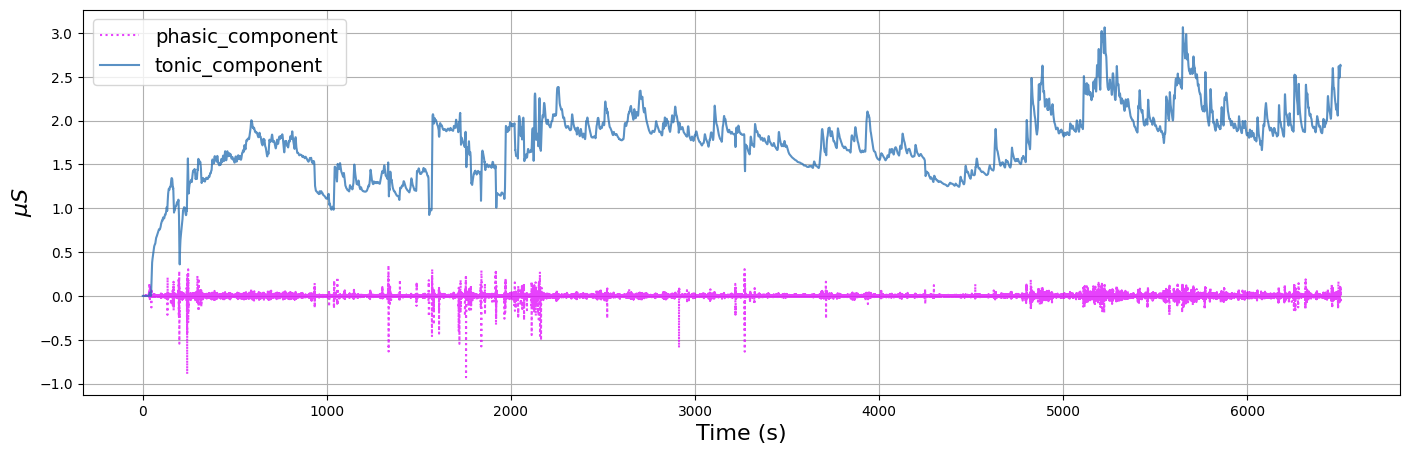

In [775]:
view_time_frame(ahixac_eda_df, samp_freq=128, begin_time_s=begin_time_s, end_time_s=end_time_s, cols_to_use=['phasic_component', 'tonic_component'])

In [776]:
stacked_subjects = np.stack([ahixac_eda_df, ahixac_eda_df], axis=0)
stacked_subjects

array([[[ 0.00000000e+00,  0.00000000e+00, -1.64015089e-01, ...,
          0.00000000e+00,  9.79922855e-05, -9.79922855e-05],
        [ 7.81250000e-03,  0.00000000e+00, -1.27567292e-01, ...,
          0.00000000e+00,  9.84258797e-05, -9.84258797e-05],
        [ 1.56250000e-02,  0.00000000e+00, -1.27567292e-01, ...,
          0.00000000e+00,  9.88594739e-05, -9.88594739e-05],
        ...,
        [ 6.50646094e+03,  2.60293040e+00,  2.60293040e+00, ...,
          2.59493280e+00,  2.61624027e+00, -1.33098672e-02],
        [ 6.50646875e+03,  2.57069597e+00,  2.57069597e+00, ...,
          2.59180626e+00,  2.61600847e+00, -4.53125000e-02],
        [ 6.50647656e+03,  2.58974359e+00,  2.58974359e+00, ...,
          2.58926707e+00,  2.61581387e+00, -2.60702839e-02]],

       [[ 0.00000000e+00,  0.00000000e+00, -1.64015089e-01, ...,
          0.00000000e+00,  9.79922855e-05, -9.79922855e-05],
        [ 7.81250000e-03,  0.00000000e+00, -1.27567292e-01, ...,
          0.00000000e+00,  9.84258797e

In [777]:
stacked_subjects.shape

(2, 832830, 10)

In [778]:
np.nan_to_num(stacked_subjects).shape

(2, 832830, 10)

In [779]:
exp_stacked_subs = stacked_subjects[..., np.newaxis]
exp_stacked_subs

array([[[[ 0.00000000e+00],
         [ 0.00000000e+00],
         [-1.64015089e-01],
         ...,
         [ 0.00000000e+00],
         [ 9.79922855e-05],
         [-9.79922855e-05]],

        [[ 7.81250000e-03],
         [ 0.00000000e+00],
         [-1.27567292e-01],
         ...,
         [ 0.00000000e+00],
         [ 9.84258797e-05],
         [-9.84258797e-05]],

        [[ 1.56250000e-02],
         [ 0.00000000e+00],
         [-1.27567292e-01],
         ...,
         [ 0.00000000e+00],
         [ 9.88594739e-05],
         [-9.88594739e-05]],

        ...,

        [[ 6.50646094e+03],
         [ 2.60293040e+00],
         [ 2.60293040e+00],
         ...,
         [ 2.59493280e+00],
         [ 2.61624027e+00],
         [-1.33098672e-02]],

        [[ 6.50646875e+03],
         [ 2.57069597e+00],
         [ 2.57069597e+00],
         ...,
         [ 2.59180626e+00],
         [ 2.61600847e+00],
         [-4.53125000e-02]],

        [[ 6.50647656e+03],
         [ 2.58974359e+00],
         [

In [780]:
# (3 subjects, 2 rows, 43 features, 1) this is the shape of our data
exp_stacked_subs.shape

(2, 832830, 10, 1)

## Applying Gouverneur et al. (2023)'s data formatting the time series data they had of the different sensor modalities i.e. GSR, EMG, ECG were resampled to a common frequency of 512 Hz. Samples of the finalised dataset consist of 5.5 s windows with a delay of 3 s after the onset stimulus. data format for the dataset is (subjects × stimuli × repetitions, sampling rate × windows length, sensors) = (87 × 5 × 20, 512 × 5.5, 3) = (8700, 2816, 3). Applying this to our own signal data via simulation by acting as if ahixac_eda_df is one subjects recorded raw signals, the columns representing its sensor modalities which fortunately includes the raw eda signal column stacking two ahixac_eda_df's as if they are 2 different subject data, and we indeed see that when stacked we have 2 subjects, 832830 rows, and 8 "sensor modalities" or in this case just are the raw eda signals, timestamps, labels, etc.

In [781]:
# selects the datasets specific column now that it is a 4D matrix
for index, col, in enumerate(ahixac_eda_df.columns):
    print(exp_stacked_subs[:, :, index, 0].shape)

(2, 832830)
(2, 832830)
(2, 832830)
(2, 832830)
(2, 832830)
(2, 832830)
(2, 832830)
(2, 832830)
(2, 832830)
(2, 832830)


## say we wanted to select the eda "sensor" modality

In [782]:
raw_eda_signal = exp_stacked_subs[:, :, 1, 0]
raw_eda_signal

array([[0.        , 0.        , 0.        , ..., 2.6029304 , 2.57069597,
        2.58974359],
       [0.        , 0.        , 0.        , ..., 2.6029304 , 2.57069597,
        2.58974359]])

## the above would be our eda signals for instance for each of our subjects

In [783]:
print([f'shape of i: {i.shape}' for i in tqdm(raw_eda_signal)])

100%|██████████| 2/2 [00:00<?, ?it/s]

['shape of i: (832830,)', 'shape of i: (832830,)']


In [784]:
def resample_by_interpolation(signal, input_freq, output_freq):
    n_rows = signal.shape[0]

    scale = output_freq / input_freq

    # calculate new length of sample
    resamp_n_rows = round(n_rows * scale)

    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, resamp_n_rows, endpoint=False),
        np.linspace(0.0, 1.0, n_rows, endpoint=False),
        signal
    )

    return resampled_signal

def resample_axis(raw_signal: np.ndarray | pd.DataFrame, input_freq: int, output_freq: int, axis: int):
    # arr is the first argument to the callback, input_freq
    # is a keyword argument which must be the same as the
    # 2nd argument to the callback, output_freq is a keyword
    # argument which must be the same as teh 3rd argument to the
    # callback. Definition of function is below
    # numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)
    resampled_signal = np.apply_along_axis(func1d=resample_by_interpolation, axis=axis, arr=raw_signal, input_freq=input_freq, output_freq=output_freq)

    return resampled_signal

## as we can see when we divide our one subject data's number of rows by the sampling rate its signals were recorded at which is 128 we geet almost if not the same exact seconds where the recording of the signals of this subject ended

In [785]:
total_seconds = raw_eda_signal.shape[1] / 128
total_seconds

6506.484375

In [786]:
first_resample = resample_axis(raw_eda_signal, input_freq=128, output_freq=4, axis=1)
first_resample

array([[0.00000000e+00, 2.22000222e-04, 2.22000222e-04, ...,
        2.60293648e+00, 2.58095576e+00, 2.55458067e+00],
       [0.00000000e+00, 2.22000222e-04, 2.22000222e-04, ...,
        2.60293648e+00, 2.58095576e+00, 2.55458067e+00]])

In [787]:
first_resample.shape

(2, 26026)

In [788]:
ahixac_eda_df_4hz = interpolate_signals(ahixac_eda_df, sample_rate=128, start_time=ahixac_start_time, target_hz=4)
ahixac_eda_df_4hz

250.0ms


time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000     0.00    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.250     0.25    0.000222      0.000222    0.0   
1970-01-01 00:00:00.500     0.50    0.000222      0.000222    0.0   
1970-01-01 00:00:00.750     0.75    0.000222      0.000222    0.0   
1970-01-01 00:00:01.000     1.00    0.000222      0.000222    0.0   
...                          ...         ...           ...    ...   
1970-01-01 01:48:25.250  6505.25    2.636630      2.636630    0.0   
1970-01-01 01:48:25.500  6505.50    2.667399      2.667399    0.0   
1970-01-01 01:48:25.750  6505.75    2.592674      2.592674    0.0   
1970-01-01 01:48:26.000  6506.00    2.570696      2.570696    0.0   
1970-01-01 01:48:26.250  6506.25    2.554579      2.554579    0.0   

                          auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.250  1.260593e-04       1.0                 1.0   
1970-01-01 00:00:00.500  2.196768e-04       0.0                 0.0   
1970-01-01 00:00:00.750  2.220002e-04       0.0                 0.0   
1970-01-01 00:00:01.000  2.220002e-04       0.0                 0.0   
...                               ...       ...                 ...   
1970-01-01 01:48:25.250  2.636630e+00       0.0                 0.0   
1970-01-01 01:48:25.500  2.667399e+00       0.0                 0.0   
1970-01-01 01:48:25.750  2.592674e+00       0.0                 0.0   
1970-01-01 01:48:26.000  2.570696e+00       0.0                 0.0   
1970-01-01 01:48:26.250  2.554579e+00       0.0                 0.0   

                         filtered_signal  tonic_component  phasic_component  
1970-01-01 00:00:00.000         0.000000         0.000098         -0.000098  
1970-01-01 00:00:00.250         0.000011         0.000112          0.000110  
1970-01-01 00:00:00.500         0.000222         0.000126          0.000096  
1970-01-01 00:00:00.750         0.000222         0.000140          0.000082  
1970-01-01 00:00:01.000         0.000222         0.000153          0.000069  
...                                  ...              ...               ...  
1970-01-01 01:48:25.250         2.654690         2.637563         -0.000933  
1970-01-01 01:48:25.500         2.685382         2.636719          0.030681  
1970-01-01 01:48:25.750         2.606833         2.633471         -0.040797  
1970-01-01 01:48:26.000         2.587230         2.628365         -0.057669  
1970-01-01 01:48:26.250         2.557202         2.621998         -0.067419  

[26026 rows x 10 columns]

## So indeed that upon using also another version of an interpolation function defined atop earlier which is from Taylor et al. (2015), it yields still the same number of rows as with another version of an interpolation function by Gouverneur et al. (2023)

In [789]:
# reduces noise in the downsampled data
median_filtered = np.array([median_filter(subject_signal, size=4) for subject_signal in first_resample])
median_filtered

array([[2.22000222e-04, 2.22000222e-04, 2.22000222e-04, ...,
        2.64835615e+00, 2.60293648e+00, 2.58095576e+00],
       [2.22000222e-04, 2.22000222e-04, 2.22000222e-04, ...,
        2.64835615e+00, 2.60293648e+00, 2.58095576e+00]])

In [790]:
median_filtered.shape

(2, 26026)

In [791]:
second_resample = resample_axis(median_filtered, input_freq=4, output_freq=2, axis=1)
second_resample

array([[2.22000222e-04, 2.22000222e-04, 2.22000222e-04, ...,
        2.69231715e+00, 2.67326368e+00, 2.60293648e+00],
       [2.22000222e-04, 2.22000222e-04, 2.22000222e-04, ...,
        2.69231715e+00, 2.67326368e+00, 2.60293648e+00]])

In [792]:
second_resample.shape

(2, 13013)

In [793]:
ahixac_eda_df_2hz = interpolate_signals(ahixac_eda_df, sample_rate=128, start_time=ahixac_start_time, target_hz=2)
ahixac_eda_df_2hz

500.0ms


time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000     0.0    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.500     0.5    0.000222      0.000222    0.0   
1970-01-01 00:00:01.000     1.0    0.000222      0.000222    0.0   
1970-01-01 00:00:01.500     1.5    0.000222      0.000222    0.0   
1970-01-01 00:00:02.000     2.0    0.000222      0.000222    0.0   
...                         ...         ...           ...    ...   
1970-01-01 01:48:24.000  6504.0    2.673260      2.673260    0.0   
1970-01-01 01:48:24.500  6504.5    2.693773      2.693773    0.0   
1970-01-01 01:48:25.000  6505.0    2.665934      2.665934    0.0   
1970-01-01 01:48:25.500  6505.5    2.667399      2.667399    0.0   
1970-01-01 01:48:26.000  6506.0    2.570696      2.570696    0.0   

                          auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.500  2.196768e-04       0.0                 0.0   
1970-01-01 00:00:01.000  2.220002e-04       0.0                 0.0   
1970-01-01 00:00:01.500  2.220002e-04       0.0                 0.0   
1970-01-01 00:00:02.000  2.220002e-04       0.0                 0.0   
...                               ...       ...                 ...   
1970-01-01 01:48:24.000  2.673260e+00       0.0                 0.0   
1970-01-01 01:48:24.500  2.693773e+00       0.0                 0.0   
1970-01-01 01:48:25.000  2.665934e+00       0.0                 0.0   
1970-01-01 01:48:25.500  2.667399e+00       0.0                 0.0   
1970-01-01 01:48:26.000  2.570696e+00       0.0                 0.0   

                         filtered_signal  tonic_component  phasic_component  
1970-01-01 00:00:00.000         0.000000         0.000098         -0.000098  
1970-01-01 00:00:00.500         0.000222         0.000126          0.000096  
1970-01-01 00:00:01.000         0.000222         0.000153          0.000069  
1970-01-01 00:00:01.500         0.000222         0.000181          0.000041  
1970-01-01 00:00:02.000         0.000222         0.000209          0.000013  
...                                  ...              ...               ...  
1970-01-01 01:48:24.000         2.681847         2.623795          0.049465  
1970-01-01 01:48:24.500         2.699251         2.628855          0.064918  
1970-01-01 01:48:25.000         2.685873         2.636043          0.029891  
1970-01-01 01:48:25.500         2.685382         2.636719          0.030681  
1970-01-01 01:48:26.000         2.587230         2.628365         -0.057669  

[13013 rows x 10 columns]

In [794]:
def butter_highpass(cutoff, samp_freq, order, btype):
    """
    implementation of Gouverneur et al. (2023)'s butter_highpass
    function
    """
    normal_cutoff = 2. * cutoff / float(samp_freq)
    b, a = butter(order, normal_cutoff, btype=btype)
    return b, a

def butter_highpass_filter(data, cutoff, samp_freq, order, btype):
    """
    implementation of Gouverneur et al. (2023)'s butter_highpass_filter
    function
    """
    b, a = butter_highpass(cutoff, samp_freq, order=order, btype=btype)
    y = filtfilt(b, a, data, padlen=2)
    return y

In [795]:
highpass_filtered = np.array([butter_highpass_filter(subject_signal, cutoff=0.05, samp_freq=128, order=8, btype='highpass') for subject_signal in second_resample])
highpass_filtered

array([[-3.24350973e+170, -3.21325216e+170, -3.18300826e+170, ...,
         9.08293548e+084,  8.96030268e+084,  8.83458282e+084],
       [-3.24350973e+170, -3.21325216e+170, -3.18300826e+170, ...,
         9.08293548e+084,  8.96030268e+084,  8.83458282e+084]])

In [796]:
highpass_filtered.shape

(2, 13013)

## Variable frequency complex demodulation

In [797]:
data_length = raw_eda_signal[0].shape[0]
data_length

832830

In [798]:
# center_freqs = [0.04, 0.12, 0.2, 0.28, 0.36, 0.44, 0.52, 0.6, 0.68, 0.76, 0.84, 0.92]
center_freqs = [64, 48, 32, 16]

In [799]:
bandwidth = 0.04

In [800]:
length = data_length // 2
length

416415

In [801]:
# components = []
# for center_freq in center_freqs:
#     # finite-impulse response (FIR)
#     fir = firwin(numtaps=length, cutoff=center_freq, width=bandwidth)

#     # adaptive lowpass filter (LPF)
#     component = [lfilter(fir, 1, subject_signal) for subject_signal in highpass_filtered]
#     components.append(component)

In [802]:
# components

# output of components is
```
[[array([nan, nan, nan, ..., nan, nan, nan]),
  array([nan, nan, nan, ..., nan, nan, nan])],
 [array([nan, nan, nan, ..., nan, nan, nan]),
  array([nan, nan, nan, ..., nan, nan, nan])]]
```
# could it be that the we need to have compatible center frequencies, bandwidth, cutoff frequency, order values etc. for signals recorded at 128hz. Problem moreover occurs in lfilter but could it be that the values before using lfilter could have been such that it contributed if not outright caused the division problem in lfilter?

```
>>> import numpy as np
>>>
>>>
>>> y = np.array([0, -1, -1, -1, -1, 1])
>>> indices = [False] * y.shape[0]
>>> d = {0: 0, 4: 1}
>>>
>>> set(d.values())
{0, 1}
>>>
>>> for c in list(set(d.values())):
...     print(indices | (y == c))
...
[ True False False False False False]
[False False False False False  True]
>>>
>>> d.values()
dict_values([0, 1])
>>>
```

```
>>> import numpy as np
>>> from tqdm import tqdm
>>>
>>> subjects = pd.arange(87) + 1
>>> subjects
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87])
>>>
>>> tqdm(subjects)
  0%|                                                                                           | 0/87 [00:00<?, ?it/s]<tqdm.std.tqdm object at 0x000002186ED63350>
>>>
>>> (pbar := tqdm(subjects))
  0%|                                                                                           | 0/87 [00:28<?, ?it/s]
<tqdm.std.tqdm object at 0x000002187F2CECF0>                                                    | 0/87 [00:00<?, ?it/s]
>>>
>>> for subject in (pbar := tqdm(subjects)):
...     print(subject)
...
  0%|                                                                                           | 0/87 [00:00<?, ?it/s]
1
2
3
.
.
.
87
100%|████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 2604.51it/s]
>>>
```

## Ok so tried variable frequency complex demodulation feature extraction didn't work for some reason, I'll just move on to autoregressive feature extraction now

In [803]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error

In [804]:
data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000  0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500  0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000  0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500  0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000  0.031250    0.000000     -0.164015    0.0   
...                                 ...         ...           ...    ...   
1970-01-01 00:00:00.460937500  0.460938    0.000222      0.000222    0.0   
1970-01-01 00:00:00.468750000  0.468750    0.000222      0.000222    0.0   
1970-01-01 00:00:00.476562500  0.476562    0.000222      0.000222    0.0   
1970-01-01 00:00:00.484375000  0.484375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.492187500  0.492188    0.000222      0.000222    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 00:00:00.460937500  2.148349e-04       1.0                 1.0   
1970-01-01 00:00:00.468750000  2.160503e-04       1.0                 1.0   
1970-01-01 00:00:00.476562500  2.171323e-04       1.0                 1.0   
1970-01-01 00:00:00.484375000  2.180917e-04       1.0                 1.0   
1970-01-01 00:00:00.492187500  2.189376e-04       1.0                 1.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 00:00:00.460937500         0.000001  
1970-01-01 00:00:00.468750000         0.000001  
1970-01-01 00:00:00.476562500         0.000002  
1970-01-01 00:00:00.484375000         0.000002  
1970-01-01 00:00:00.492187500         0.000002  

[64 rows x 8 columns]

<Axes: xlabel='time'>

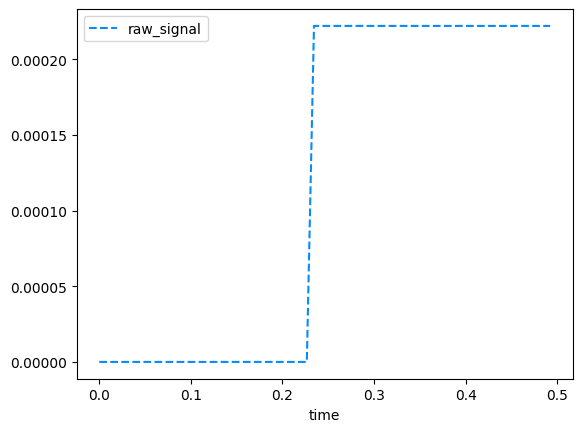

In [805]:
data.plot(kind='line', x='time', y='raw_signal', linestyle='--', color='#078bf7')

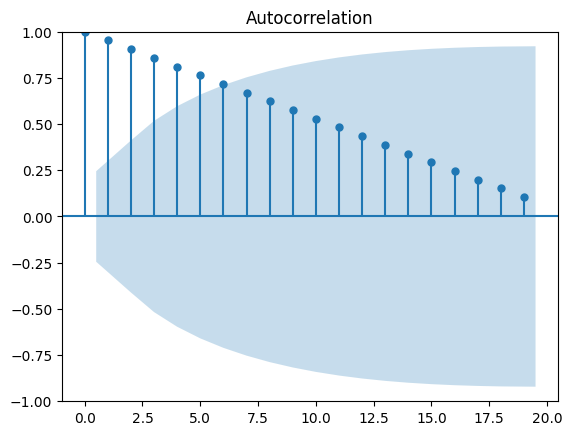

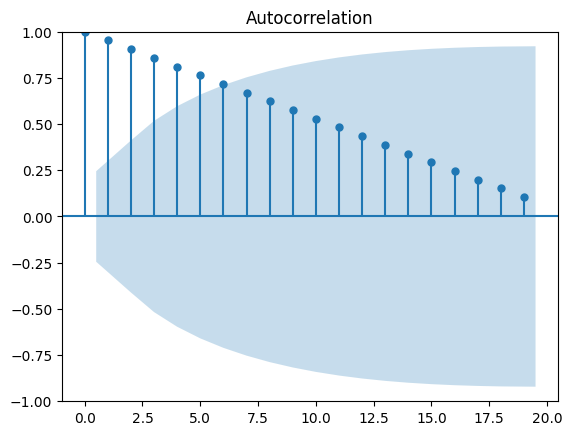

In [806]:
plot_acf(data['raw_signal'])

In [807]:
data['raw_signal+1'] = data['raw_signal'].shift(1)
data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000  0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500  0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000  0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500  0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000  0.031250    0.000000     -0.164015    0.0   
...                                 ...         ...           ...    ...   
1970-01-01 00:00:00.460937500  0.460938    0.000222      0.000222    0.0   
1970-01-01 00:00:00.468750000  0.468750    0.000222      0.000222    0.0   
1970-01-01 00:00:00.476562500  0.476562    0.000222      0.000222    0.0   
1970-01-01 00:00:00.484375000  0.484375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.492187500  0.492188    0.000222      0.000222    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 00:00:00.460937500  2.148349e-04       1.0                 1.0   
1970-01-01 00:00:00.468750000  2.160503e-04       1.0                 1.0   
1970-01-01 00:00:00.476562500  2.171323e-04       1.0                 1.0   
1970-01-01 00:00:00.484375000  2.180917e-04       1.0                 1.0   
1970-01-01 00:00:00.492187500  2.189376e-04       1.0                 1.0   

                               filtered_signal  raw_signal+1  
1970-01-01 00:00:00.000000000         0.000000           NaN  
1970-01-01 00:00:00.007812500         0.000000      0.000000  
1970-01-01 00:00:00.015625000         0.000000      0.000000  
1970-01-01 00:00:00.023437500         0.000000      0.000000  
1970-01-01 00:00:00.031250000         0.000000      0.000000  
...                                        ...           ...  
1970-01-01 00:00:00.460937500         0.000001      0.000222  
1970-01-01 00:00:00.468750000         0.000001      0.000222  
1970-01-01 00:00:00.476562500         0.000002      0.000222  
1970-01-01 00:00:00.484375000         0.000002      0.000222  
1970-01-01 00:00:00.492187500         0.000002      0.000222  

[64 rows x 9 columns]

In [808]:
train_size = 0.8
partition_index = int(train_size * data.shape[0])
train_data = data.iloc[:partition_index]
test_data = data.iloc[partition_index:]
train_data.shape

(51, 9)

In [809]:
train_data.head()

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000  0.000000         0.0     -0.164015    0.0   
1970-01-01 00:00:00.007812500  0.007812         0.0     -0.164015    0.0   
1970-01-01 00:00:00.015625000  0.015625         0.0     -0.164015    0.0   
1970-01-01 00:00:00.023437500  0.023438         0.0     -0.164015    0.0   
1970-01-01 00:00:00.031250000  0.031250         0.0     -0.164015    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   

                               filtered_signal  raw_signal+1  
1970-01-01 00:00:00.000000000              0.0           NaN  
1970-01-01 00:00:00.007812500              0.0           0.0  
1970-01-01 00:00:00.015625000              0.0           0.0  
1970-01-01 00:00:00.023437500              0.0           0.0  
1970-01-01 00:00:00.031250000              0.0           0.0

In [810]:
test_data.shape

(13, 9)

In [811]:
test_data.head()

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.398437500  0.398438    0.000222      0.000222    0.0   
1970-01-01 00:00:00.406250000  0.406250    0.000222      0.000222    0.0   
1970-01-01 00:00:00.414062500  0.414062    0.000222      0.000222    0.0   
1970-01-01 00:00:00.421875000  0.421875    0.000222      0.000222    0.0   
1970-01-01 00:00:00.429687500  0.429688    0.000222      0.000222    0.0   

                               auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.398437500     0.000201       1.0                 1.0   
1970-01-01 00:00:00.406250000     0.000203       1.0                 1.0   
1970-01-01 00:00:00.414062500     0.000205       1.0                 1.0   
1970-01-01 00:00:00.421875000     0.000207       1.0                 1.0   
1970-01-01 00:00:00.429687500     0.000208       1.0                 1.0   

                               filtered_signal  raw_signal+1  
1970-01-01 00:00:00.398437500     2.373969e-07      0.000222  
1970-01-01 00:00:00.406250000     3.022446e-07      0.000222  
1970-01-01 00:00:00.414062500     3.803331e-07      0.000222  
1970-01-01 00:00:00.421875000     4.734798e-07      0.000222  
1970-01-01 00:00:00.429687500     5.836236e-07      0.000222

In [812]:
ar_model = AutoReg(train_data['raw_signal'], lags=4)
ar_results = ar_model.fit()

In [813]:
preds = ar_results.predict(start=train_data.shape[0], end=train_data.shape[0] + test_data.shape[0] - 1, dynamic=False)
preds

1970-01-01 00:00:00.398437500    0.000222
1970-01-01 00:00:00.406250000    0.000222
1970-01-01 00:00:00.414062500    0.000222
1970-01-01 00:00:00.421875000    0.000222
1970-01-01 00:00:00.429687500    0.000222
1970-01-01 00:00:00.437500000    0.000222
1970-01-01 00:00:00.445312500    0.000222
1970-01-01 00:00:00.453125000    0.000222
1970-01-01 00:00:00.460937500    0.000222
1970-01-01 00:00:00.468750000    0.000222
1970-01-01 00:00:00.476562500    0.000222
1970-01-01 00:00:00.484375000    0.000222
1970-01-01 00:00:00.492187500    0.000222
Freq: 7812500ns, dtype: float64

In [814]:
preds.shape

(13,)

In [815]:
for real, pred in zip(preds, test_data['raw_signal']):
    print(f'predicted value: {pred} | target value: {real}')

predicted value: 0.0002220002220002 | target value: 0.0002220002220002002
predicted value: 0.0002220002220002 | target value: 0.0002220002220002004
predicted value: 0.0002220002220002 | target value: 0.0002220002220002006
predicted value: 0.0002220002220002 | target value: 0.00022200022200020078
predicted value: 0.0002220002220002 | target value: 0.00022200022200020097
predicted value: 0.0002220002220002 | target value: 0.00022200022200020113
predicted value: 0.0002220002220002 | target value: 0.0002220002220002013
predicted value: 0.0002220002220002 | target value: 0.00022200022200020145
predicted value: 0.0002220002220002 | target value: 0.00022200022200020162
predicted value: 0.0002220002220002 | target value: 0.00022200022200020175
predicted value: 0.0002220002220002 | target value: 0.0002220002220002019
predicted value: 0.0002220002220002 | target value: 0.00022200022200020202
predicted value: 0.0002220002220002 | target value: 0.00022200022200020216


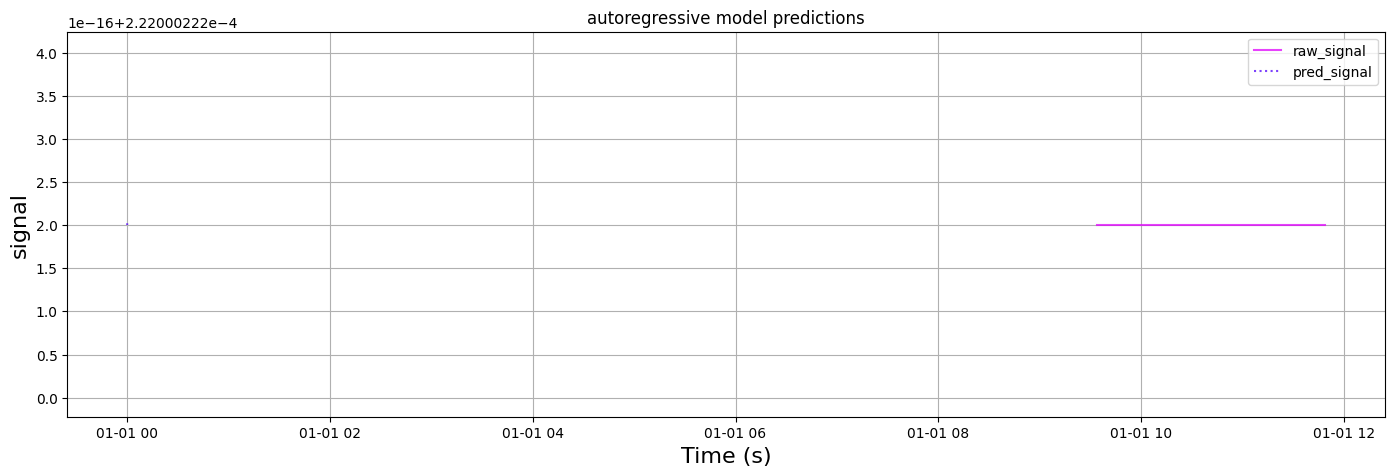

In [816]:
fig = plt.figure(figsize=(17, 5))
axis = fig.add_subplot()

# colors and linestyles to use
colors = ['#df03fc', '#5203fc', '#fc034e', '#fc8003', '#3dfc03']
lines = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3))]

axis.plot(test_data['time'], test_data['raw_signal'], label='raw_signal', alpha=0.75, linestyle=lines[0], c=colors[0])
axis.plot(preds.index, preds.values, label='pred_signal', alpha=0.75, linestyle=lines[1], c=colors[1])

axis.legend()

axis.grid()

axis.set_title("autoregressive model predictions")
axis.set_ylabel("signal", fontsize=16)
axis.set_xlabel("Time (s)", fontsize=16)
plt.show()

In [817]:
rmse = math.sqrt(mean_squared_error(test_data['raw_signal'], preds))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


## because our lag order was 4 our number of coefficients excluding our bias coefficient is 4

In [818]:
ar_coeffs = ar_results.params
ar_coeffs

const            8.222230e-06
raw_signal.L1    9.629630e-01
raw_signal.L2   -7.633726e-17
raw_signal.L3    3.394793e-16
raw_signal.L4    1.942890e-16
dtype: float64

In [819]:
ar_coeffs.iloc[1:].tolist()

[0.962962962962963,
 -7.633725920418628e-17,
 3.394792859486665e-16,
 1.942890293094024e-16]

In [820]:
type(ar_coeffs)

pandas.core.series.Series

# These are our errors across all signals

In [821]:
ar_results.resid

1970-01-01 00:00:00.031250000   -8.222230e-06
1970-01-01 00:00:00.039062500   -8.222230e-06
1970-01-01 00:00:00.046875000   -8.222230e-06
1970-01-01 00:00:00.054687500   -8.222230e-06
1970-01-01 00:00:00.062500000   -8.222230e-06
1970-01-01 00:00:00.070312500   -8.222230e-06
1970-01-01 00:00:00.078125000   -8.222230e-06
1970-01-01 00:00:00.085937500   -8.222230e-06
1970-01-01 00:00:00.093750000   -8.222230e-06
1970-01-01 00:00:00.101562500   -8.222230e-06
1970-01-01 00:00:00.109375000   -8.222230e-06
1970-01-01 00:00:00.117187500   -8.222230e-06
1970-01-01 00:00:00.125000000   -8.222230e-06
1970-01-01 00:00:00.132812500   -8.222230e-06
1970-01-01 00:00:00.140625000   -8.222230e-06
1970-01-01 00:00:00.148437500   -8.222230e-06
1970-01-01 00:00:00.156250000   -8.222230e-06
1970-01-01 00:00:00.164062500   -8.222230e-06
1970-01-01 00:00:00.171875000   -8.222230e-06
1970-01-01 00:00:00.179687500   -8.222230e-06
1970-01-01 00:00:00.187500000   -8.222230e-06
1970-01-01 00:00:00.195312500   -8

## here we can obtain the error variance by squaring these errors and adding them all and dividing by the number of samples or observations
```
def sigma2(self):
        return 1.0 / self.nobs * sumofsq(self.resid)
```

In [822]:
ar_results.sigma2

1.0097608847687864e-09

## Done with autoregressive feature extraction let's move on to extracting the shannon entropy as the feature of a 0.5s segment/window/epoch of a signal

```
np.histogram([1, 2, 1], bins=[0, 1, 2, 3])
(array([0, 2, 1]), array([0, 1, 2, 3]))
np.histogram(np.arange(4), bins=np.arange(5), density=True)
(array([0.25, 0.25, 0.25, 0.25]), array([0, 1, 2, 3, 4]))
np.histogram([[1, 2, 1], [1, 0, 1]], bins=[0,1,2,3])
(array([1, 4, 1]), array([0, 1, 2, 3]))
```

In [823]:
data['normed_raw_signal'] = (data['raw_signal'] - data['raw_signal'].min()) / (data['raw_signal'].max() - data['raw_signal'].min())
data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000  0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500  0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000  0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500  0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000  0.031250    0.000000     -0.164015    0.0   
...                                 ...         ...           ...    ...   
1970-01-01 00:00:00.460937500  0.460938    0.000222      0.000222    0.0   
1970-01-01 00:00:00.468750000  0.468750    0.000222      0.000222    0.0   
1970-01-01 00:00:00.476562500  0.476562    0.000222      0.000222    0.0   
1970-01-01 00:00:00.484375000  0.484375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.492187500  0.492188    0.000222      0.000222    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 00:00:00.460937500  2.148349e-04       1.0                 1.0   
1970-01-01 00:00:00.468750000  2.160503e-04       1.0                 1.0   
1970-01-01 00:00:00.476562500  2.171323e-04       1.0                 1.0   
1970-01-01 00:00:00.484375000  2.180917e-04       1.0                 1.0   
1970-01-01 00:00:00.492187500  2.189376e-04       1.0                 1.0   

                               filtered_signal  raw_signal+1  \
1970-01-01 00:00:00.000000000         0.000000           NaN   
1970-01-01 00:00:00.007812500         0.000000      0.000000   
1970-01-01 00:00:00.015625000         0.000000      0.000000   
1970-01-01 00:00:00.023437500         0.000000      0.000000   
1970-01-01 00:00:00.031250000         0.000000      0.000000   
...                                        ...           ...   
1970-01-01 00:00:00.460937500         0.000001      0.000222   
1970-01-01 00:00:00.468750000         0.000001      0.000222   
1970-01-01 00:00:00.476562500         0.000002      0.000222   
1970-01-01 00:00:00.484375000         0.000002      0.000222   
1970-01-01 00:00:00.492187500         0.000002      0.000222   

                               normed_raw_signal  
1970-01-01 00:00:00.000000000                0.0  
1970-01-01 00:00:00.007812500                0.0  
1970-01-01 00:00:00.015625000                0.0  
1970-01-01 00:00:00.023437500                0.0  
1970-01-01 00:00:00.031250000                0.0  
...                                          ...  
1970-01-01 00:00:00.460937500                1.0  
1970-01-01 00:00:00.468750000                1.0  
1970-01-01 00:00:00.476562500                1.0  
1970-01-01 00:00:00.484375000                1.0  
1970-01-01 00:00:00.492187500                1.0  

[64 rows x 10 columns]

In [824]:
data['normed_raw_signal'].value_counts()

normed_raw_signal
1.0    34
0.0    30
Name: count, dtype: int64

In [825]:
shannon_entropy = entropy(data['normed_raw_signal'].value_counts())
shannon_entropy

0.6911927820032008

## Going back to variable frequency complex demodulation based feature extraction

In [826]:
data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000  0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500  0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000  0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500  0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000  0.031250    0.000000     -0.164015    0.0   
...                                 ...         ...           ...    ...   
1970-01-01 00:00:00.460937500  0.460938    0.000222      0.000222    0.0   
1970-01-01 00:00:00.468750000  0.468750    0.000222      0.000222    0.0   
1970-01-01 00:00:00.476562500  0.476562    0.000222      0.000222    0.0   
1970-01-01 00:00:00.484375000  0.484375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.492187500  0.492188    0.000222      0.000222    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 00:00:00.460937500  2.148349e-04       1.0                 1.0   
1970-01-01 00:00:00.468750000  2.160503e-04       1.0                 1.0   
1970-01-01 00:00:00.476562500  2.171323e-04       1.0                 1.0   
1970-01-01 00:00:00.484375000  2.180917e-04       1.0                 1.0   
1970-01-01 00:00:00.492187500  2.189376e-04       1.0                 1.0   

                               filtered_signal  raw_signal+1  \
1970-01-01 00:00:00.000000000         0.000000           NaN   
1970-01-01 00:00:00.007812500         0.000000      0.000000   
1970-01-01 00:00:00.015625000         0.000000      0.000000   
1970-01-01 00:00:00.023437500         0.000000      0.000000   
1970-01-01 00:00:00.031250000         0.000000      0.000000   
...                                        ...           ...   
1970-01-01 00:00:00.460937500         0.000001      0.000222   
1970-01-01 00:00:00.468750000         0.000001      0.000222   
1970-01-01 00:00:00.476562500         0.000002      0.000222   
1970-01-01 00:00:00.484375000         0.000002      0.000222   
1970-01-01 00:00:00.492187500         0.000002      0.000222   

                               normed_raw_signal  
1970-01-01 00:00:00.000000000                0.0  
1970-01-01 00:00:00.007812500                0.0  
1970-01-01 00:00:00.015625000                0.0  
1970-01-01 00:00:00.023437500                0.0  
1970-01-01 00:00:00.031250000                0.0  
...                                          ...  
1970-01-01 00:00:00.460937500                1.0  
1970-01-01 00:00:00.468750000                1.0  
1970-01-01 00:00:00.476562500                1.0  
1970-01-01 00:00:00.484375000                1.0  
1970-01-01 00:00:00.492187500                1.0  

[64 rows x 10 columns]

In [827]:
data = data.drop(columns=['raw_signal+1', 'normed_raw_signal'])
data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000  0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500  0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000  0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500  0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000  0.031250    0.000000     -0.164015    0.0   
...                                 ...         ...           ...    ...   
1970-01-01 00:00:00.460937500  0.460938    0.000222      0.000222    0.0   
1970-01-01 00:00:00.468750000  0.468750    0.000222      0.000222    0.0   
1970-01-01 00:00:00.476562500  0.476562    0.000222      0.000222    0.0   
1970-01-01 00:00:00.484375000  0.484375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.492187500  0.492188    0.000222      0.000222    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 00:00:00.460937500  2.148349e-04       1.0                 1.0   
1970-01-01 00:00:00.468750000  2.160503e-04       1.0                 1.0   
1970-01-01 00:00:00.476562500  2.171323e-04       1.0                 1.0   
1970-01-01 00:00:00.484375000  2.180917e-04       1.0                 1.0   
1970-01-01 00:00:00.492187500  2.189376e-04       1.0                 1.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 00:00:00.460937500         0.000001  
1970-01-01 00:00:00.468750000         0.000001  
1970-01-01 00:00:00.476562500         0.000002  
1970-01-01 00:00:00.484375000         0.000002  
1970-01-01 00:00:00.492187500         0.000002  

[64 rows x 8 columns]

In [828]:
# def _get_amp_phase(s_t):
#     """
#     Calculates amplitude and phase from a complex number.

#     args:
#         s_t (complex): A complex number representing a sample of the Hilbert-transformed signal.

#     Returns:
#         tuple: A tuple containing the amplitude and phase.
#     """

#     amp = np.abs(s_t)
#     phase = np.angle(s_t)
#     return amp, phase

In [829]:
def _get_amp_phase(z):
    """
    Calculates amplitude and phase from a complex number.

    args:
        z (complex): A complex number representing a sample of the Hilbert-transformed signal.

    Returns:
        tuple: A tuple containing the amplitude and phase.
    """
    # recall that a complex number consists of a 
    # real number and an imaginary number
    z_imag = z.imag

    # note to avoid using potential zero as a divisor
    # we must add 1e-100 to make sure \
    
    z_real = z.real + 1e-100 if z.real == 0 else z.real

    # calculate amplitude and phase
    amp = np.abs(z_imag ** 2 + z_real ** 2)
    phase = np.arctan(z_imag / z_real)
    return amp, phase

In [830]:
def _compute_vfcdm_feats(data: pd.DataFrame | np.ndarray, hertz: int):
    """
    computes time-frequency based features based on variable
    frequency complex demodulation (VFCDM), using cutoff
    frequencies of 64, 48, 32, and 16 hertz on the 128hz
    signal

    args:
        data - is a 0.5s segment/window/epoch of a subjects
        128hz signals
    """

    # these cutoffs namely 0.5, 0.375, 0.25, and 0.125 when
    # multiplied to 128 results in 64, 48, 32, and 16.
    # This will basically just cutoff the signal by 50%, 37.5%,
    # 25%, and 12.5%
    cutoffs = [4 / 8, 3 / 8, 2 / 8, 1 / 8]
    decomp_signals = []

    for cutoff in cutoffs:
        filtered_signal = butter_lowpass_filter(data, cutoff=cutoff, samp_freq=hertz)
        hilbert_signal = hilbert(filtered_signal)

        decomp_signal = []
        for s_t in hilbert_signal:
            amp, phase = _get_amp_phase(s_t)

            # 2 * 3.14... * 0.5 * 128 + phase
            point = amp * np.cos(2 * np.pi * cutoff * 128 + phase)
            decomp_signal.append(point)

        decomp_signals.append(decomp_signal)
        # compute statistical features from resulting
        # decomposed signal

    decomp_signals = np.array(decomp_signals)
    return decomp_signals

In [831]:
decomp_signals = _compute_vfcdm_feats(data['raw_signal'], hertz=128)
decomp_signals

array([[ 3.64027981e-27,  5.20244215e-28, -3.42305864e-28,
        -1.12292212e-28,  3.11182736e-28,  1.27336505e-28,
        -8.42800253e-29, -3.80416905e-29, -5.16079811e-29,
         5.00905814e-29,  6.79412412e-29,  3.28789974e-29,
         4.45481952e-29,  2.15725047e-29,  2.91670653e-29,
         1.38611500e-29,  1.86743723e-29, -4.15133532e-30,
         1.13882850e-29,  4.78581355e-30, -3.09820020e-30,
         2.28869078e-30,  2.97550174e-30,  7.60534847e-31,
         9.40131001e-31, -3.03481797e-32,  5.47469238e-32,
         1.36929344e-31, -1.21731278e-31, -4.88897797e-31,
         5.10826205e-22,  7.41633560e-21,  4.99871800e-20,
         2.18353646e-19,  7.75920161e-19,  2.07647398e-18,
         5.41248578e-18,  1.11469303e-17,  2.43110909e-17,
         4.27622720e-17,  8.31471788e-17,  1.31899603e-16,
         2.36605279e-16,  3.49214999e-16,  5.89700033e-16,
         8.25467689e-16,  1.32919792e-15,  1.78708018e-15,
         2.76830432e-15,  3.60696206e-15,  5.40964743e-1

In [832]:
decomp_signals.shape

(4, 64)

## because we have 64 rows of 128hz data which is a 0.5s window/segment/epoch we then low pass filter it with a cutoff of 50%, 37.5%, 25%, and 12.5% pass it to a hilbert transform. Conclusively because we have 4 cutoffs we would have 4 rows representing these signals at different cutoffs.

In [833]:
data['vfcdm_4/8_cut_128hz'] = decomp_signals[0, :]
data['vfcdm_3/8_cut_128hz'] = decomp_signals[1, :]
data['vfcdm_2/8_cut_128hz'] = decomp_signals[2, :]
data['vfcdm_1/8_cut_128hz'] = decomp_signals[3, :]
data

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000  0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500  0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000  0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500  0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000  0.031250    0.000000     -0.164015    0.0   
...                                 ...         ...           ...    ...   
1970-01-01 00:00:00.460937500  0.460938    0.000222      0.000222    0.0   
1970-01-01 00:00:00.468750000  0.468750    0.000222      0.000222    0.0   
1970-01-01 00:00:00.476562500  0.476562    0.000222      0.000222    0.0   
1970-01-01 00:00:00.484375000  0.484375    0.000222      0.000222    0.0   
1970-01-01 00:00:00.492187500  0.492188    0.000222      0.000222    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 00:00:00.460937500  2.148349e-04       1.0                 1.0   
1970-01-01 00:00:00.468750000  2.160503e-04       1.0                 1.0   
1970-01-01 00:00:00.476562500  2.171323e-04       1.0                 1.0   
1970-01-01 00:00:00.484375000  2.180917e-04       1.0                 1.0   
1970-01-01 00:00:00.492187500  2.189376e-04       1.0                 1.0   

                               filtered_signal  vfcdm_4/8_cut_128hz  \
1970-01-01 00:00:00.000000000         0.000000         3.640280e-27   
1970-01-01 00:00:00.007812500         0.000000         5.202442e-28   
1970-01-01 00:00:00.015625000         0.000000        -3.423059e-28   
1970-01-01 00:00:00.023437500         0.000000        -1.122922e-28   
1970-01-01 00:00:00.031250000         0.000000         3.111827e-28   
...                                        ...                  ...   
1970-01-01 00:00:00.460937500         0.000001         6.405249e-14   
1970-01-01 00:00:00.468750000         0.000001         8.639279e-14   
1970-01-01 00:00:00.476562500         0.000002         1.119349e-13   
1970-01-01 00:00:00.484375000         0.000002         1.487823e-13   
1970-01-01 00:00:00.492187500         0.000002         2.517110e-13   

                               vfcdm_3/8_cut_128hz  vfcdm_2/8_cut_128hz  \
1970-01-01 00:00:00.000000000         2.091944e-28        -6.470793e-31   
1970-01-01 00:00:00.007812500         2.951870e-29         4.874694e-31   
1970-01-01 00:00:00.015625000         4.005397e-29         6.658710e-31   
1970-01-01 00:00:00.023437500        -4.833937e-30         2.145266e-31   
1970-01-01 00:00:00.031250000         1.773565e-29        -5.442689e-32   
...                                            ...                  ...   
1970-01-01 00:00:00.460937500         4.447798e-15         9.484653e-17   
1970-01-01 00:00:00.468750000         6.041973e-15         1.297366e-16   
1970-01-01 00:00:00.476562500         7.856497e-15         1.692853e-16   
1970-01-01 00:00:00.484375000         1.051799e-14         2.282185e-16   
1970-01-01 00:00:00.492187500         1.787890e-14         3.897095e-16   

                               vfcdm_1/8_cut_128hz  
1970-01-01 00:00:00.000000000         2.994134e-33  
1970-01-01 00:00:00.007812500         6.518425e-35  
1970-01-01 00:00:00.015625000         5.669844e-34  
1970-01-01 00:00:00.023437500         1.810985e-34  
1970-01-01 00:00:00.031250000         3.950500e-35  
...                                            ...  
1970-01-01 00:00:00.460937500         1.135845e-19  
1970-01-01 00:00:00

In [834]:
slice_end_time_s = round(data['time'].iloc[-1]) * 128
slice_end_time_s

0

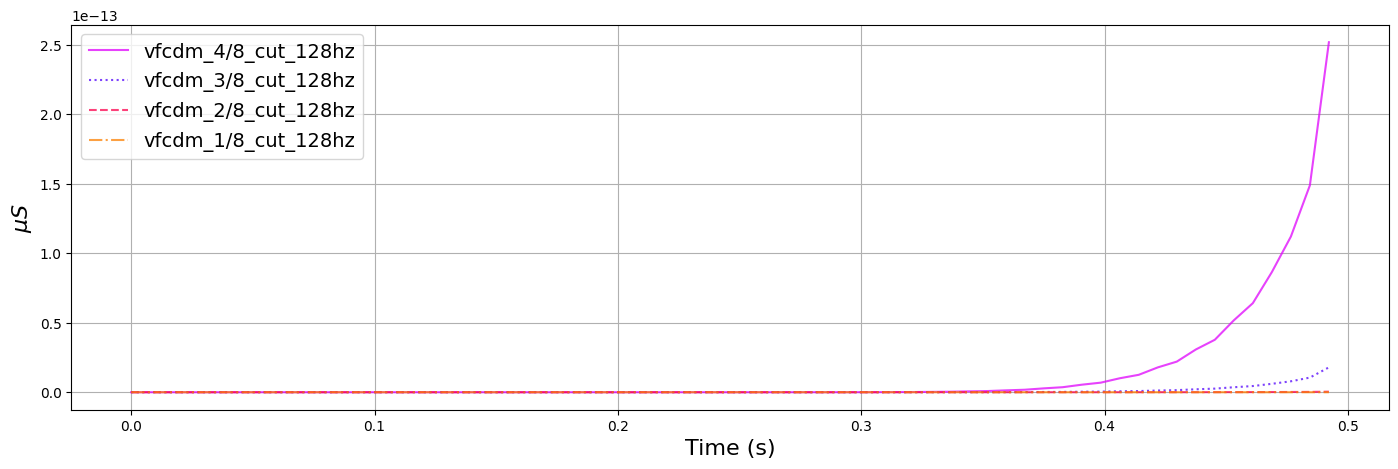

In [835]:
cols_to_use = ['vfcdm_4/8_cut_128hz',
'vfcdm_3/8_cut_128hz',
'vfcdm_2/8_cut_128hz',
'vfcdm_1/8_cut_128hz',]

fig = plt.figure(figsize=(17, 5))

axis = fig.add_subplot()


time_to_plot = data['time']

# colors and linestyles to use
colors = ['#df03fc', '#5203fc', '#fc034e', '#fc8003', '#3dfc03']
lines = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3))]

# axis.plot(time_to_plot, data['raw_signal'], label='raw_signal', alpha=0.75, linestyle=lines[4], c=colors[4])
for i, col in enumerate(cols_to_use):
    col_to_plot = data[col]
    axis.plot(time_to_plot, col_to_plot, label=col, alpha=0.75, linestyle=lines[i], c=colors[i])
# axis.plot(time_to_plot, rawdata_to_plot, label="Raw data")
# axis.plot(time_to_plot, cleandata_to_plot, label="Manual", c="orange")
# axis.plot(time_to_plot, autodata_to_plot, label="Automatic", alpha=0.7, linestyle="--", c="red")
# axis.plot(time_to_plot, autodata_to_plot, label="Automatic", alpha=0.7, linestyle="--", c="red")

axis.legend(fontsize=14)
axis.grid()

axis.set_ylabel(r'$\mu S$', fontsize=16)
axis.set_xlabel("Time (s)", fontsize=16)
plt.show()

In [836]:
import tensorflow as tf
from utilities.feature_extractors import extract_features
from utilities.loaders import load_model, load_meta_data, load_lookup_array
from utilities.preprocessors import correct_signals
from models.llanes_jurado import LSTM_CNN
from models.cueva import LSTM_SVM, LSTM_FE

In [837]:
pqbqpr_eda_df = pd.read_csv('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/Test/pqbqpr_expert2.csv', sep=';')
pqbqpr_eda_df

time   rawdata  cleandata  binarytarget  signal_automatic  \
0          0.000000  0.000000  -0.164015           0.0      2.106994e-20   
1          0.007812  0.000000  -0.164015           0.0      1.879714e-06   
2          0.015625  0.000000  -0.164015           0.0      3.656027e-06   
3          0.023438  0.000000  -0.164015           0.0      5.370973e-06   
4          0.031250  0.000000  -0.164015           0.0      7.062509e-06   
...             ...       ...        ...           ...               ...   
980113  7657.132812  0.002886   0.002886           0.0      2.886003e-03   
980114  7657.140625  0.000222   0.000222           0.0      2.220002e-04   
980115  7657.148438  0.000222   0.000222           0.0      2.220002e-04   
980116  7657.156250  0.002442   0.002442           0.0      2.442002e-03   
980117  7657.164062  0.000222   0.000222           0.0      2.220002e-04   

        PredArtifacts  PostProcessedPredArtifacts  
0                 1.0                         1.0  
1                 1.0                         1.0  
2                 1.0                         1.0  
3                 1.0                         1.0  
4                 1.0                         1.0  
...               ...                         ...  
980113            0.0                         0.0  
980114            0.0                         0.0  
980115            0.0                         0.0  
980116            0.0                         0.0  
980117            0.0                         0.0  

[980118 rows x 7 columns]

In [838]:
pqbqpr_eda_df.rename(columns={
    'rawdata': 'raw_signal',
    'cleandata': 'clean_signal',
    'binarytarget': 'label',
    'signal_automatic': 'auto_signal',
    'PredArtifacts': 'pred_art',
    'PostProcessedPredArtifacts': 'post_proc_pred_art'}, inplace=True)
pqbqpr_eda_df

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0          0.000000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1          0.007812    0.000000     -0.164015    0.0  1.879714e-06       1.0   
2          0.015625    0.000000     -0.164015    0.0  3.656027e-06       1.0   
3          0.023438    0.000000     -0.164015    0.0  5.370973e-06       1.0   
4          0.031250    0.000000     -0.164015    0.0  7.062509e-06       1.0   
...             ...         ...           ...    ...           ...       ...   
980113  7657.132812    0.002886      0.002886    0.0  2.886003e-03       0.0   
980114  7657.140625    0.000222      0.000222    0.0  2.220002e-04       0.0   
980115  7657.148438    0.000222      0.000222    0.0  2.220002e-04       0.0   
980116  7657.156250    0.002442      0.002442    0.0  2.442002e-03       0.0   
980117  7657.164062    0.000222      0.000222    0.0  2.220002e-04       0.0   

        post_proc_pred_art  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      1.0  
...                    ...  
980113                 0.0  
980114                 0.0  
980115                 0.0  
980116                 0.0  
980117                 0.0  

[980118 rows x 7 columns]

In [839]:
(pqbqpr_eda_df['raw_signal'] < 0).astype('int').sum()

0

In [840]:
signal_automatic = pqbqpr_eda_df.loc[pqbqpr_eda_df['raw_signal'] < 0, 'raw_signal']
signal_automatic

Series([], Name: raw_signal, dtype: float64)

In [841]:
pqbqpr_eda_df['raw_signal'][pqbqpr_eda_df['raw_signal'] < 0]

Series([], Name: raw_signal, dtype: float64)

In [842]:
from utilities.feature_extractors import extract_features_per_hour

In [843]:

test_X_dl, test_Y_dl = charge_raw_data(pqbqpr_eda_df, x_col='raw_signal', y_col="label", hertz=128, target_time=0.5, scale=True)
test_X_ml, test_Y_ml = extract_features(pqbqpr_eda_df, extractor_fn=extract_features_per_hour)

length of x_signals: 980118
window size: 640


c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:1172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df_16hz['filtered_signal'] = butter_lowpass_filter(eda_df_16hz['raw_signal'], cutoff=1.0, samp_freq=16, order=6)
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:411: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whole_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / whole_freq) * 1000)}ms')
c:\Users\LARRY\Documents

num_labels: 15315
last timestamp: 1970-01-01 00:59:59.500000
exclusion timestamp list: DatetimeIndex([   '1970-01-01 00:59:59.500000',
               '1970-01-01 00:59:59.507812500',
                  '1970-01-01 00:59:59.515625',
               '1970-01-01 00:59:59.523437500',
                  '1970-01-01 00:59:59.531250',
               '1970-01-01 00:59:59.539062500',
                  '1970-01-01 00:59:59.546875',
               '1970-01-01 00:59:59.554687500',
                  '1970-01-01 00:59:59.562500',
               '1970-01-01 00:59:59.570312500',
                  '1970-01-01 00:59:59.578125',
               '1970-01-01 00:59:59.585937500',
                  '1970-01-01 00:59:59.593750',
               '1970-01-01 00:59:59.601562500',
                  '1970-01-01 00:59:59.609375',
               '1970-01-01 00:59:59.617187500',
                  '1970-01-01 00:59:59.625000',
               '1970-01-01 00:59:59.632812500',
                  '1970-01-01 00:59:59.640625',
 

c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(signal)
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(signal)
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(signal)
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\fea

calculating features from 1970-01-01 00:59:58.500000 to 1970-01-01 00:59:59 exclusively for index 7197
calculating features from 460608 to 460671 inclusively for index 7197
data segment: 
                                      time  raw_signal  clean_signal  label  \
1970-01-01 00:59:58.500000000  3598.500000    7.165193      7.183875    1.0   
1970-01-01 00:59:58.507812500  3598.507812    7.206034      7.186881    1.0   
1970-01-01 00:59:58.515625000  3598.515625    7.200929      7.189748    1.0   
1970-01-01 00:59:58.523437500  3598.523438    7.206034      7.192478    1.0   
1970-01-01 00:59:58.531250000  3598.531250    7.216245      7.195073    1.0   
...                                    ...         ...           ...    ...   
1970-01-01 00:59:58.960937500  3598.960938    7.701242      7.207277    1.0   
1970-01-01 00:59:58.968750000  3598.968750    7.711452      7.206523    1.0   
1970-01-01 00:59:58.976562500  3598.976562    7.706347      7.205785    1.0   
1970-01-01 00:59:58.98

c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:411: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whole_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / whole_freq) * 1000)}ms')
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:412: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  half_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / half_freq) * 1000)}ms')


last timestamp: 1970-01-01 01:59:59.500000
exclusion timestamp list: DatetimeIndex([   '1970-01-01 01:59:59.500000',
               '1970-01-01 01:59:59.507812500',
                  '1970-01-01 01:59:59.515625',
               '1970-01-01 01:59:59.523437500',
                  '1970-01-01 01:59:59.531250',
               '1970-01-01 01:59:59.539062500',
                  '1970-01-01 01:59:59.546875',
               '1970-01-01 01:59:59.554687500',
                  '1970-01-01 01:59:59.562500',
               '1970-01-01 01:59:59.570312500',
                  '1970-01-01 01:59:59.578125',
               '1970-01-01 01:59:59.585937500',
                  '1970-01-01 01:59:59.593750',
               '1970-01-01 01:59:59.601562500',
                  '1970-01-01 01:59:59.609375',
               '1970-01-01 01:59:59.617187500',
                  '1970-01-01 01:59:59.625000',
               '1970-01-01 01:59:59.632812500',
                  '1970-01-01 01:59:59.640625',
               '197

c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:411: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whole_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / whole_freq) * 1000)}ms')
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:412: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  half_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / half_freq) * 1000)}ms')


calculating features from 1970-01-01 02:07:36 to 1970-01-01 02:07:36.500000 exclusively for index 912
calculating features from 979968 to 980031 inclusively for index 912
data segment: 
                                      time  raw_signal  clean_signal  label  \
1970-01-01 02:07:36.000000000  7656.000000    0.000222      0.000222    0.0   
1970-01-01 02:07:36.007812500  7656.007812    0.000222      0.000222    0.0   
1970-01-01 02:07:36.015625000  7656.015625    0.001554      0.001554    0.0   
1970-01-01 02:07:36.023437500  7656.023438    0.000222      0.000222    0.0   
1970-01-01 02:07:36.031250000  7656.031250    0.001110      0.001110    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 02:07:36.460937500  7656.460938    0.000222      0.000222    0.0   
1970-01-01 02:07:36.468750000  7656.468750    0.000222      0.000222    0.0   
1970-01-01 02:07:36.476562500  7656.476562    0.002886      0.002886    0.0   
1970-01-01 02:07:36.4843

c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:411: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whole_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / whole_freq) * 1000)}ms')
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:412: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  half_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / half_freq) * 1000)}ms')
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\fe

calculating features from 1970-01-01 00:59:58.500000 to 1970-01-01 00:59:59 exclusively for index 7197
calculating features from 57576 to 57583 inclusively for index 7197
data segment: 
                                 time  raw_signal  clean_signal  label  \
1970-01-01 00:59:58.500000  3598.5000    7.165193      7.183875    1.0   
1970-01-01 00:59:58.562500  3598.5625    7.216245      7.204158    1.0   
1970-01-01 00:59:58.625000  3598.6250    7.231561      7.216664    1.0   
1970-01-01 00:59:58.687500  3598.6875    7.246876      7.222737    1.0   
1970-01-01 00:59:58.750000  3598.7500    7.251981      7.223722    1.0   
1970-01-01 00:59:58.812500  3598.8125    7.246876      7.220964    1.0   
1970-01-01 00:59:58.875000  3598.8750    7.685926      7.215809    1.0   
1970-01-01 00:59:58.937500  3598.9375    7.711452      7.209602    1.0   

                            auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:59:58.500000     6.828251       1.0                 1.0   
1

c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:411: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whole_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / whole_freq) * 1000)}ms')
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:412: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  half_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / half_freq) * 1000)}ms')
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\fe

calculating features from 1970-01-01 01:59:58.500000 to 1970-01-01 01:59:59 exclusively for index 7197
calculating features from 115176 to 115183 inclusively for index 7197
data segment: 
                                 time  raw_signal  clean_signal  label  \
1970-01-01 01:59:58.500000  7198.5000    0.000222      0.000222    0.0   
1970-01-01 01:59:58.562500  7198.5625    0.000222      0.000222    0.0   
1970-01-01 01:59:58.625000  7198.6250    0.002442      0.002442    0.0   
1970-01-01 01:59:58.687500  7198.6875    0.004662      0.004662    0.0   
1970-01-01 01:59:58.750000  7198.7500    0.002442      0.002442    0.0   
1970-01-01 01:59:58.812500  7198.8125    0.000222      0.000222    0.0   
1970-01-01 01:59:58.875000  7198.8750    0.000222      0.000222    0.0   
1970-01-01 01:59:58.937500  7198.9375    0.000222      0.000222    0.0   

                            auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 01:59:58.500000     0.000222       0.0                 0.0   

c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:411: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whole_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / whole_freq) * 1000)}ms')
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:412: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  half_inc_ts = pd.date_range(start=timestamp_list[0], periods=data.shape[0], freq=f'{((1 / half_freq) * 1000)}ms')
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\fe

calculating features from 1970-01-01 02:07:36 to 1970-01-01 02:07:36.500000 exclusively for index 912
calculating features from 122496 to 122503 inclusively for index 912
data segment: 
                                 time  raw_signal  clean_signal  label  \
1970-01-01 02:07:36.000000  7656.0000    0.000222      0.000222    0.0   
1970-01-01 02:07:36.062500  7656.0625    0.000222      0.000222    0.0   
1970-01-01 02:07:36.125000  7656.1250    0.000222      0.000222    0.0   
1970-01-01 02:07:36.187500  7656.1875    0.000222      0.000222    0.0   
1970-01-01 02:07:36.250000  7656.2500    0.000222      0.000222    0.0   
1970-01-01 02:07:36.312500  7656.3125    0.002442      0.002442    0.0   
1970-01-01 02:07:36.375000  7656.3750    0.003330      0.003330    0.0   
1970-01-01 02:07:36.437500  7656.4375    0.001554      0.001554    0.0   

                            auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 02:07:36.000000     0.000222       0.0                 0.0   
1

c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\feature_extractors.py:180: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eda_labels = pd.concat([eda_labels, features_per_hour_1[i][1]], ignore_index=True)


In [844]:
# test_X_dl.shape

In [845]:
# test_X_ml

#### reduce features based on taylor or hossain

In [846]:
# # if features have already been saved load it
# hossain_lr_feats = load_lookup_array(f'./data/Artifact Detection Data/reduced_hossain_lr_feature_set.txt')

In [847]:
# test_X_hossain = test_X_ml[hossain_lr_feats].to_numpy()
# test_X_hossain

In [848]:
# test_Y_hossain = test_Y_ml.to_numpy().ravel()
# test_Y_hossain

In [849]:
# hossain_lr_scaler = load_model('./saved/misc/hossain_lr_scaler.pkl')
# hossain_lr_scaler

In [850]:
# test_X_hossain = hossain_lr_scaler.transform(test_X_hossain)
# test_X_hossain

# load models

In [851]:
# lstm_cnn_hp = load_meta_data('./saved/misc/jurado_lstm-cnn_meta_data.json')
# lstm_cnn = LSTM_CNN(**lstm_cnn_hp)
# lstm_cnn

In [852]:
# lstm_cnn.load_weights('./saved/weights/EDABE_LSTM_1DCNN_Model.h5')

In [853]:
lstm_fe_hp = load_meta_data('./saved/misc/cueva_lstm-fe_meta_data.json')
lstm_fe = LSTM_FE(**lstm_fe_hp)
lstm_fe

<Sequential name=sequential_1, built=True>

In [854]:
lstm_fe.load_weights('./saved/weights/cueva_lstm-fe_21_0.7489.weights.h5')

In [855]:
# hossain_lr = load_model('./saved/models/hossain_lr_clf.pkl')

In [856]:
# type(hossain_lr).__name__.lower()

In [857]:
# hossain_lr

In [858]:
# taylor_lr = 
# taylor_svm = 
# taylor_rf = 

# prediction

In [859]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from utilities.loaders import load_meta_data, load_model, load_lookup_array, charge_raw_data
from utilities.feature_extractors import extract_features, extract_features_hybrid, extract_features_per_hour

In [860]:
# hossain_lr.score(test_X_hossain, test_Y_hossain)

In [861]:
# hossain_lr_pred = hossain_lr.predict(test_X_hossain)
# hossain_lr_pred

In [862]:
# values, counts = np.unique(hossain_lr_pred, return_counts=True)
# values, counts

In [863]:
# jurado_lstm_cnn_pred = lstm_cnn.predict(test_X_dl)
# jurado_lstm_cnn_pred

In [864]:
# jurado_lstm_cnn_pred_whole = tf.cast(jurado_lstm_cnn_pred >= 0.2, tf.int64)
# jurado_lstm_cnn_pred_whole

In [865]:
# np.unique(jurado_lstm_cnn_pred_whole, return_counts=True)

In [866]:
# accuracy_score(test_Y_dl, jurado_lstm_cnn_pred_whole)

In [867]:
# precision_score(test_Y_dl, jurado_lstm_cnn_pred_whole, average='weighted')

In [868]:
# recall_score(test_Y_dl, jurado_lstm_cnn_pred_whole, average='weighted')

In [869]:
# f1_score(test_Y_dl, jurado_lstm_cnn_pred_whole, average='weighted')

In [870]:
# roc_auc_score(test_Y_dl, jurado_lstm_cnn_pred_whole, average='weighted', multi_class='ovo')

# Testing proposed model in terms of side task prediction capability (not as feature extractor yet )

In [871]:
cueva_lstm_fe_pred = lstm_fe.predict(test_X_dl)
cueva_lstm_fe_pred

479/479 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step


array([[0.9867937 ],
       [0.00510885],
       [0.00510885],
       ...,
       [0.00507176],
       [0.00507805],
       [0.00507705]], dtype=float32)

In [872]:
cueva_lstm_fe_pred_whole = tf.cast(cueva_lstm_fe_pred >= 0.2, tf.int64)
cueva_lstm_fe_pred_whole

<tf.Tensor: shape=(15305, 1), dtype=int64, numpy=
array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)>

In [873]:
np.unique(cueva_lstm_fe_pred_whole, return_counts=True)

(array([0, 1], dtype=int64), array([14307,   998], dtype=int64))

In [874]:
np.unique(test_Y_dl, return_counts=True)

(array([0, 1]), array([14314,   991], dtype=int64))

In [875]:
accuracy_score(test_Y_dl, cueva_lstm_fe_pred_whole)

0.9157791571381901

In [876]:

precision_score(test_Y_dl, cueva_lstm_fe_pred_whole, average='weighted')

0.9160556332883495

In [877]:
recall_score(test_Y_dl, cueva_lstm_fe_pred_whole, average='weighted')

0.9157791571381901

In [878]:
f1_score(test_Y_dl, cueva_lstm_fe_pred_whole, average='weighted')

0.9159170595377426

In [879]:
roc_auc_score(test_Y_dl, cueva_lstm_fe_pred, average='weighted', multi_class='ovo')

0.732569124636751

In [880]:
# roc_auc_score(test_Y_dl, cueva_lstm_fe_pred)

In [881]:
# lstm_layer_2 = lstm_fe.get_layer('lstm-layer-2')
# cueva_first_phase_lstm = tf.keras.Model(inputs=lstm_fe.inputs, outputs=lstm_layer_2.output)

In [882]:
# # extract lower order features of the test data akin to previous ml models
# subject_lof, subject_labels = extract_features(pqbqpr_eda_df, extractor_fn=extract_features_hybrid)

# # load test signals and use it to extract the higher order features from it
# subject_signals, subject_labels = charge_raw_data(pqbqpr_eda_df, x_col="raw_signal", y_col='label', scale=True, verbose=True)

# # extract higher features
# subject_hof_arr = cueva_first_phase_lstm.predict(subject_signals)
# columns = [f'HOF_{i}' for i in range(1, subject_hof_arr.shape[1] + 1)]
# subject_hof = pd.DataFrame(subject_hof_arr, columns=columns)

# # concatenate both dataframes of higher and lower features 
# subject_hof_lof = pd.concat([subject_hof, subject_lof], axis=1)

In [883]:
cueva_second_phase_svm_red_feats = load_lookup_array(f'./data/Artifact Detection Data/reduced_cueva_second_phase_svm_feature_set1.txt')

file not found please run needed script first to produce file


In [884]:
# subject_hof_lof = subject_hof_lof[cueva_second_phase_svm_red_feats]

In [885]:
# cueva_svm_X = subject_hof_lof.to_numpy()
# cueva_svm_Y = subject_labels

In [886]:
# cueva_second_phase_svm = load_model('./saved/models/cueva_second_phase_svm_clf1.pkl')

In [887]:
# # use model for prediction
# Y_pred = cueva_second_phase_svm.predict(cueva_svm_X)
# Y_pred_prob = cueva_second_phase_svm.predict_proba(cueva_svm_X)
# print(f"predicted Y: {Y_pred}")
# print(f"unique values and counts: {np.unique(Y_pred, return_counts=True)}")
# print(f"true Y: {cueva_svm_Y}")
# print(f"unique values and counts: {np.unique(cueva_svm_Y, return_counts=True)}")

# # compute performance metric values for test subject
# test_acc = accuracy_score(y_true=cueva_svm_Y, y_pred=Y_pred)
# test_prec = precision_score(y_true=cueva_svm_Y, y_pred=Y_pred, average="weighted")
# test_rec = recall_score(y_true=cueva_svm_Y, y_pred=Y_pred, average="weighted")
# test_f1 = f1_score(y_true=cueva_svm_Y, y_pred=Y_pred, average="weighted")
# test_roc_auc = roc_auc_score(y_true=cueva_svm_Y, y_score=Y_pred_prob[:, 1], average="weighted", multi_class="ovo")

# print(f"test acc: {test_acc} \
#       \ntest prec: {test_prec} \
#       \ntest rec: {test_rec} \
#       \ntest f1: {test_f1} \
#       \ntest roc_auc: {test_roc_auc}")

# as we can see the lstm fe side task model alone can produce comparable number of non artifacts to artifacts ratio to the lstm-cnn model by llanes-jurado et al. (2023) and so the lstm-fe used as a feature extractor disregarding the dense layers could when combined with lower order features as input features to an SVM can even be equalize if not be even more powerful than the lstm-cnn model 

In [888]:
# test_Y_dl

In [889]:
# np.unique(test_Y_dl, return_counts=True)

In [890]:
pqbqpr_eda_df

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0          0.000000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1          0.007812    0.000000     -0.164015    0.0  1.879714e-06       1.0   
2          0.015625    0.000000     -0.164015    0.0  3.656027e-06       1.0   
3          0.023438    0.000000     -0.164015    0.0  5.370973e-06       1.0   
4          0.031250    0.000000     -0.164015    0.0  7.062509e-06       1.0   
...             ...         ...           ...    ...           ...       ...   
980113  7657.132812    0.002886      0.002886    0.0  2.886003e-03       0.0   
980114  7657.140625    0.000222      0.000222    0.0  2.220002e-04       0.0   
980115  7657.148438    0.000222      0.000222    0.0  2.220002e-04       0.0   
980116  7657.156250    0.002442      0.002442    0.0  2.442002e-03       0.0   
980117  7657.164062    0.000222      0.000222    0.0  2.220002e-04       0.0   

        post_proc_pred_art  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      1.0  
...                    ...  
980113                 0.0  
980114                 0.0  
980115                 0.0  
980116                 0.0  
980117                 0.0  

[980118 rows x 7 columns]

In [891]:
# jurado_lstm_cnn_pqbqpr_res_df, jurado_lstm_cnn_dict_metrics = correct_signals(
#     jurado_lstm_cnn_pred_whole,
#     pqbqpr_eda_df,
#     estimator_name="lstm-cnn",
#     selector_config="jurado")

In [892]:
# hossain_lr_pqbqpr_res_df, hossain_lr_dict_metrics = correct_signals(
#     hossain_lr_pred,
#     pqbqpr_eda_df,
#     estimator_name="lr",
#     selector_config="hossain")

In [893]:
# cueva_lstm_svm_pqbqpr_res_df, cueva_lstm_svm_dict_metrics = correct_signals(
#     Y_pred,
#     pqbqpr_eda_df,
#     estimator_name="lstm-svm",
#     selector_config="cueva")

what we want to do in the correct_eda function is to have it take in the already predicted labels, 

In [894]:
# hossain_lr_pqbqpr_res_df

In [895]:
# begin_time_s = 0
# end_time_s = round(hossain_lr_pqbqpr_res_df['time'].iloc[-1] * 128)
# begin_time_s, end_time_s

In [896]:
# begin_time_s = 0
# end_time_s = round(cueva_lstm_svm_pqbqpr_res_df['time'].iloc[-1] * 128)
# begin_time_s, end_time_s

In [897]:
# view_time_frame(hossain_lr_pqbqpr_res_df, begin_time_s=5970, end_time_s=6000, cols_to_use=['raw_signal', 'new_signal'])

In [898]:
# jurado_lstm_cnn_pqbqpr_res_df.shape

In [899]:
# view_time_frame(jurado_lstm_cnn_pqbqpr_res_df, begin_time_s=5970, end_time_s=6000, cols_to_use=['raw_signal', 'new_signal'])

In [900]:
# view_time_frame(jurado_lstm_cnn_pqbqpr_res_df, begin_time_s=begin_time_s, end_time_s=end_time_s, cols_to_use=['raw_signal', 'new_signal'])

In [901]:
# view_time_frame(cueva_lstm_svm_pqbqpr_res_df, begin_time_s=5970, end_time_s=6000, cols_to_use=['raw_signal', 'new_signal'])

In [902]:
# jurado_lstm_cnn_pqbqpr_res_df['new_signal'].max()

In [903]:
# jurado_lstm_cnn_pqbqpr_res_df['new_signal'].min()

In [904]:
# jurado_lstm_cnn_pqbqpr_res_df.to_csv('./results/pqbqpr_expert2_corrected.csv')

In [905]:
from utilities.feature_extractors import load_wavelet_data

In [906]:
pqbqpr_eda_df

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0          0.000000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1          0.007812    0.000000     -0.164015    0.0  1.879714e-06       1.0   
2          0.015625    0.000000     -0.164015    0.0  3.656027e-06       1.0   
3          0.023438    0.000000     -0.164015    0.0  5.370973e-06       1.0   
4          0.031250    0.000000     -0.164015    0.0  7.062509e-06       1.0   
...             ...         ...           ...    ...           ...       ...   
980113  7657.132812    0.002886      0.002886    0.0  2.886003e-03       0.0   
980114  7657.140625    0.000222      0.000222    0.0  2.220002e-04       0.0   
980115  7657.148438    0.000222      0.000222    0.0  2.220002e-04       0.0   
980116  7657.156250    0.002442      0.002442    0.0  2.442002e-03       0.0   
980117  7657.164062    0.000222      0.000222    0.0  2.220002e-04       0.0   

        post_proc_pred_art  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      1.0  
...                    ...  
980113                 0.0  
980114                 0.0  
980115                 0.0  
980116                 0.0  
980117                 0.0  

[980118 rows x 7 columns]

In [907]:
oxused_eda_df = pd.read_csv('./data/Electrodermal Activity artifact correction BEnchmark (EDABE)/test/oxused_expert2.csv', sep=';')
oxused_eda_df

time   rawdata  cleandata  binarytarget  signal_automatic  \
0          0.000000  0.000000  -0.091119           0.0          0.000000   
1          0.007812  0.000000  -0.091119           0.0          0.000000   
2          0.015625  0.000000  -0.091119           0.0          0.000000   
3          0.023438  0.000000  -0.091119           0.0          0.000000   
4          0.031250  0.000000  -0.091119           0.0          0.000000   
...             ...       ...        ...           ...               ...   
765040  5976.875000  0.011766   0.011766           0.0          0.011766   
765041  5976.882812  0.011322   0.011322           0.0          0.011322   
765042  5976.890625  0.011322   0.011322           0.0          0.011322   
765043  5976.898438  0.011766   0.011766           0.0          0.011766   
765044  5976.906250  0.011322   0.011322           0.0          0.011322   

        PredArtifacts  PostProcessedPredArtifacts  
0                 0.0                         0.0  
1                 0.0                         0.0  
2                 0.0                         0.0  
3                 0.0                         0.0  
4                 0.0                         0.0  
...               ...                         ...  
765040            0.0                         0.0  
765041            0.0                         0.0  
765042            0.0                         0.0  
765043            0.0                         0.0  
765044            0.0                         0.0  

[765045 rows x 7 columns]

In [908]:
oxused_eda_df.rename(columns={
    'rawdata': 'raw_signal',
    'cleandata': 'clean_signal',
    'binarytarget': 'label',
    'signal_automatic': 'auto_signal',
    'PredArtifacts': 'pred_art',
    'PostProcessedPredArtifacts': 'post_proc_pred_art'}, inplace=True)
oxused_eda_df

time  raw_signal  clean_signal  label  auto_signal  pred_art  \
0          0.000000    0.000000     -0.091119    0.0     0.000000       0.0   
1          0.007812    0.000000     -0.091119    0.0     0.000000       0.0   
2          0.015625    0.000000     -0.091119    0.0     0.000000       0.0   
3          0.023438    0.000000     -0.091119    0.0     0.000000       0.0   
4          0.031250    0.000000     -0.091119    0.0     0.000000       0.0   
...             ...         ...           ...    ...          ...       ...   
765040  5976.875000    0.011766      0.011766    0.0     0.011766       0.0   
765041  5976.882812    0.011322      0.011322    0.0     0.011322       0.0   
765042  5976.890625    0.011322      0.011322    0.0     0.011322       0.0   
765043  5976.898438    0.011766      0.011766    0.0     0.011766       0.0   
765044  5976.906250    0.011322      0.011322    0.0     0.011322       0.0   

        post_proc_pred_art  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
765040                 0.0  
765041                 0.0  
765042                 0.0  
765043                 0.0  
765044                 0.0  

[765045 rows x 7 columns]

In [909]:
oxused_whole_wave, oxused_half_wave = load_wavelet_data(oxused_eda_df, col_to_use='raw_signal', hertz=128, samples_per_win_size=64)

In [910]:
oxused_whole_wave

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 00:00:00.000000                0.000000                 0.000000   
1970-01-01 00:00:00.062500                0.000000                 0.000000   
1970-01-01 00:00:00.125000                0.003626                 0.002564   
1970-01-01 00:00:00.187500                0.000000                 0.001354   
1970-01-01 00:00:00.250000                0.000314                 0.000666   
...                                            ...                      ...   
1970-01-01 01:39:36.625000                0.000314                 0.000222   
1970-01-01 01:39:36.687500                0.000314                 0.000222   
1970-01-01 01:39:36.750000                0.000314                 0.000444   
1970-01-01 01:39:36.812500                0.000314                 0.000222   
1970-01-01 01:39:36.875000                0.000314                 0.000000   

                            third_16thofa_sec_feat  
1970-01-01 00:00:00.000000                0.000000  
1970-01-01 00:00:00.062500                0.000000  
1970-01-01 00:00:00.125000                0.005439  
1970-01-01 00:00:00.187500                0.000958  
1970-01-01 00:00:00.250000                0.001727  
...                                            ...  
1970-01-01 01:39:36.625000                0.000157  
1970-01-01 01:39:36.687500                0.000157  
1970-01-01 01:39:36.750000                0.000000  
1970-01-01 01:39:36.812500                0.000314  
1970-01-01 01:39:36.875000                0.000314  

[95631 rows x 3 columns]

In [911]:
oxused_half_wave

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 00:00:00.000000                0.000000                 0.000000
1970-01-01 00:00:00.031250                0.000000                 0.000000
1970-01-01 00:00:00.062500                0.000000                 0.000000
1970-01-01 00:00:00.093750                0.000000                 0.000000
1970-01-01 00:00:00.125000                0.003626                 0.002564
...                                            ...                      ...
1970-01-01 01:39:36.781250                0.000000                 0.000444
1970-01-01 01:39:36.812500                0.000314                 0.000222
1970-01-01 01:39:36.843750                0.000314                 0.000222
1970-01-01 01:39:36.875000                0.000314                 0.000000
1970-01-01 01:39:36.906250                0.000000                 0.000000

[191262 rows x 2 columns]

95631 * 2 = 191262
95631 * 4 = 382524
95631 * 8 = 765048

765048 has 3 more rows than the original oxused df of 765045 rows this is because so we can create whole and half wave dfs as 765045 / 2 = 382522.5 which when encountered by pywavelet will be turned into 382523 instead and divided again by two which will give out another decimal value since it is an odd number, 191261.5, and turned again into 191262 which is now an odd number and then divided again by 2 which is 95631

and 95631 when we recursively multiply by 2 then 4 will give out 191262 and 382524 which is a mismatch in the originally calculated values of pywavelet of 191262 and 382523, and so to reshape this we need to add rows of zeros to these odd numbered rows of coefficients created by pywavelet so 382523 will become 382524 now

In [912]:
pqbqpr_eda_df

time  raw_signal  clean_signal  label   auto_signal  pred_art  \
0          0.000000    0.000000     -0.164015    0.0  2.106994e-20       1.0   
1          0.007812    0.000000     -0.164015    0.0  1.879714e-06       1.0   
2          0.015625    0.000000     -0.164015    0.0  3.656027e-06       1.0   
3          0.023438    0.000000     -0.164015    0.0  5.370973e-06       1.0   
4          0.031250    0.000000     -0.164015    0.0  7.062509e-06       1.0   
...             ...         ...           ...    ...           ...       ...   
980113  7657.132812    0.002886      0.002886    0.0  2.886003e-03       0.0   
980114  7657.140625    0.000222      0.000222    0.0  2.220002e-04       0.0   
980115  7657.148438    0.000222      0.000222    0.0  2.220002e-04       0.0   
980116  7657.156250    0.002442      0.002442    0.0  2.442002e-03       0.0   
980117  7657.164062    0.000222      0.000222    0.0  2.220002e-04       0.0   

        post_proc_pred_art  
0                      1.0  
1                      1.0  
2                      1.0  
3                      1.0  
4                      1.0  
...                    ...  
980113                 0.0  
980114                 0.0  
980115                 0.0  
980116                 0.0  
980117                 0.0  

[980118 rows x 7 columns]

In [913]:
pqbqpr_whole_wave, pqbqbr_half_wave = load_wavelet_data(pqbqpr_eda_df, col_to_use='raw_signal', hertz=128, samples_per_win_size=64)

In [914]:
pqbqpr_whole_wave

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 00:00:00.000000                0.000000                 0.000000   
1970-01-01 00:00:00.062500                0.000000                 0.000000   
1970-01-01 00:00:00.125000                0.000000                 0.000000   
1970-01-01 00:00:00.187500                0.000000                 0.000222   
1970-01-01 00:00:00.250000                0.000000                 0.000000   
...                                            ...                      ...   
1970-01-01 02:07:36.875000                0.002198                 0.001554   
1970-01-01 02:07:36.937500                0.001884                 0.000666   
1970-01-01 02:07:37.000000                0.002198                 0.001332   
1970-01-01 02:07:37.062500                0.002198                 0.000888   
1970-01-01 02:07:37.125000                0.001884                 0.001332   

                            third_16thofa_sec_feat  
1970-01-01 00:00:00.000000                0.000000  
1970-01-01 00:00:00.062500                0.000000  
1970-01-01 00:00:00.125000                0.000000  
1970-01-01 00:00:00.187500                0.000157  
1970-01-01 00:00:00.250000                0.000000  
...                                            ...  
1970-01-01 02:07:36.875000                0.000000  
1970-01-01 02:07:36.937500                0.000157  
1970-01-01 02:07:37.000000                0.000471  
1970-01-01 02:07:37.062500                0.001413  
1970-01-01 02:07:37.125000                0.000628  

[122515 rows x 3 columns]

In [915]:
pqbqbr_half_wave

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 00:00:00.000000                0.000000                 0.000000
1970-01-01 00:00:00.031250                0.000000                 0.000000
1970-01-01 00:00:00.062500                0.000000                 0.000000
1970-01-01 00:00:00.093750                0.000000                 0.000000
1970-01-01 00:00:00.125000                0.000000                 0.000000
...                                            ...                      ...
1970-01-01 02:07:37.031250                0.002198                 0.001110
1970-01-01 02:07:37.062500                0.000314                 0.000222
1970-01-01 02:07:37.093750                0.002198                 0.000888
1970-01-01 02:07:37.125000                0.001884                 0.001332
1970-01-01 02:07:37.156250                0.001570                 0.000000

[245030 rows x 2 columns]

In [916]:
pqbqpr_whole_wave.iloc[::16]

first_16thofa_sec_feat  second_16thofa_sec_feat  \
1970-01-01 00:00:00                0.000000                 0.000000   
1970-01-01 00:00:01                0.000000                 0.000000   
1970-01-01 00:00:02                0.000000                 0.000000   
1970-01-01 00:00:03                0.000000                 0.000000   
1970-01-01 00:00:04                0.000000                 0.000000   
...                                     ...                      ...   
1970-01-01 02:07:33                0.002198                 0.001110   
1970-01-01 02:07:34                0.002198                 0.001554   
1970-01-01 02:07:35                0.002198                 0.001554   
1970-01-01 02:07:36                0.002512                 0.001110   
1970-01-01 02:07:37                0.002198                 0.001332   

                     third_16thofa_sec_feat  
1970-01-01 00:00:00            0.000000e+00  
1970-01-01 00:00:01            0.000000e+00  
1970-01-01 00:00:02            0.000000e+00  
1970-01-01 00:00:03            0.000000e+00  
1970-01-01 00:00:04            0.000000e+00  
...                                     ...  
1970-01-01 02:07:33            3.534499e-17  
1970-01-01 02:07:34            3.139557e-04  
1970-01-01 02:07:35            3.139557e-04  
1970-01-01 02:07:36            1.255823e-03  
1970-01-01 02:07:37            4.709336e-04  

[7658 rows x 3 columns]

In [917]:
pqbqbr_half_wave.iloc[::32]

first_32thofa_sec_feat  second_32thofa_sec_feat
1970-01-01 00:00:00                0.000000                 0.000000
1970-01-01 00:00:01                0.000000                 0.000000
1970-01-01 00:00:02                0.000000                 0.000000
1970-01-01 00:00:03                0.000000                 0.000000
1970-01-01 00:00:04                0.000000                 0.000000
...                                     ...                      ...
1970-01-01 02:07:33                0.002198                 0.001110
1970-01-01 02:07:34                0.002198                 0.001554
1970-01-01 02:07:35                0.002198                 0.001554
1970-01-01 02:07:36                0.000942                 0.000666
1970-01-01 02:07:37                0.001884                 0.001332

[7658 rows x 2 columns]

with 128 hertz data we have 128 be divided by 8 which is 16 and so 1/16 will be how much we can increment before we get to a whole second. This essentially means we go through 16 rows of data in the whole wavelet dataframe before we ever increase by 1 second. This goes for th half wave dataframe as well as 128 is divided by 8 which is 16 but multiplied by 2 resulting in 32 and so 1/32 seconds will be how much we increment before we get to the next second, or how much rows it would take which in this case is 32 before we get to the next second

# So essentially with 128hz data we can create a whole and half wave dataframe that has its sampling frequency at 16 and 32 hertz respectively

# we must get 5s overlapping windows of these wavelet dataframes how? Perhaps with the same incrementing pattern used in charge raw data we could...
- have our sampling rate/frequency/hertz as 32 and 16 for both half and whole wave dataframes, and the window_time be 5s, so when we compute the window_size the computation would be something along the lines of window_time * hertz, which in this case would be 32 * 5 = 160 and 16 * 5 = 80. Hence our window size for both dataframes respectively would be 160 and 80 and must be overlapping. Note that a `target_size_frame` of 64 will still be used in order to have `i` increment by 64

but wait i'm not sure if we should increment by 64 because this is done for a 128hz dataset maybe instead of 64 for 128hz we could have 16 for 32hz, because we want our overlapping segments to be only 0.5s and since this is a 32hz dataframe we need to have it increment by 32 * 0.5 which would be 16 

for the oxused whole wave and half wave we have lengths of 95631 and 191262

in theory we would have the ff. iteration patterns:

```
stop = 95631 - 160
while i <= 95471:
    # 0:0 + 160 = 0:160 <--- this a 5 second window for data of 32hz that increments at 0.5s of the data which is by 16
    # 16:16 + 160 = 16:176 <---
    # 32:32 + 160 = 32:192
    # 48:48 + 160 = 48:208
    ...
    # 
```

In [918]:
this_is_a_sample_arr = []
hertz = 32
window_time = 5
window_size = int(window_time * hertz)
target_time = 0.5
target_size = int(target_time * hertz)

stop = oxused_whole_wave.shape[0] - window_size
i = 0
while i <= stop:
    print(f'{i}:{i + window_size}')
    this_is_a_sample_arr.append(i)

    i += target_size

0:160
16:176
32:192
48:208
64:224
80:240
96:256
112:272
128:288
144:304
160:320
176:336
192:352
208:368
224:384
240:400
256:416
272:432
288:448
304:464
320:480
336:496
352:512
368:528
384:544
400:560
416:576
432:592
448:608
464:624
480:640
496:656
512:672
528:688
544:704
560:720
576:736
592:752
608:768
624:784
640:800
656:816
672:832
688:848
704:864
720:880
736:896
752:912
768:928
784:944
800:960
816:976
832:992
848:1008
864:1024
880:1040
896:1056
912:1072
928:1088
944:1104
960:1120
976:1136
992:1152
1008:1168
1024:1184
1040:1200
1056:1216
1072:1232
1088:1248
1104:1264
1120:1280
1136:1296
1152:1312
1168:1328
1184:1344
1200:1360
1216:1376
1232:1392
1248:1408
1264:1424
1280:1440
1296:1456
1312:1472
1328:1488
1344:1504
1360:1520
1376:1536
1392:1552
1408:1568
1424:1584
1440:1600
1456:1616
1472:1632
1488:1648
1504:1664
1520:1680
1536:1696
1552:1712
1568:1728
1584:1744
1600:1760
1616:1776
1632:1792
1648:1808
1664:1824
1680:1840
1696:1856
1712:1872
1728:1888
1744:1904
1760:1920
1776:1936
1792

In [919]:
len(this_is_a_sample_arr)

5967

In [920]:
oxused_signals, oxused_labels = charge_raw_data(oxused_eda_df, x_col="raw_signal", target_time=0.5, y_col="label", hertz=128, scale=True)

length of x_signals: 765045
window size: 640
number of rows created: 11944


In [921]:
oxused_signals.shape

(11944, 640, 1)

In [922]:
oxused_labels.shape

(11944, 1)

In [923]:
oxused_whole_wave_windows = charge_raw_data(oxused_whole_wave, x_col="first_16thofa_sec_feat", y_col=None, target_time=0.5, hertz=32)

length of x_signals: 95631
window size: 160
number of rows created: 5967


In [924]:
oxused_whole_wave_windows.shape

(5967, 160, 1)

# How do I create wavelet features such that when windowed will still result in 11944 rows?

# Here we interpolate again the 128hz data to 16hz and try to get the same number of rows as the 128hz data when we want a window of 5 seconds for 16hz. And because the interpolated data will result in 16hz or 16 samples per 1 second when we set a `window_time` of 5 seconds the resulting `window_size` will be 5 * 16 or 80.

In [925]:
start_time = oxused_eda_df.iloc[0]['time']
start_time

0.0

In [926]:
oxused_eda_df_16hz = interpolate_signals(oxused_eda_df, sample_rate=128, start_time=start_time, target_hz=16)
oxused_eda_df_16hz

62.5ms


time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000     0.0000    0.000000     -0.091119    0.0   
1970-01-01 00:00:00.062500     0.0625    0.000000     -0.002553    0.0   
1970-01-01 00:00:00.125000     0.1250    0.000000     -0.002553    0.0   
1970-01-01 00:00:00.187500     0.1875    0.005128      0.005128    0.0   
1970-01-01 00:00:00.250000     0.2500    0.003774      0.003774    0.0   
...                               ...         ...           ...    ...   
1970-01-01 01:39:36.625000  5976.6250    0.011322      0.011322    0.0   
1970-01-01 01:39:36.687500  5976.6875    0.011322      0.011322    0.0   
1970-01-01 01:39:36.750000  5976.7500    0.011322      0.011322    0.0   
1970-01-01 01:39:36.812500  5976.8125    0.011322      0.011322    0.0   
1970-01-01 01:39:36.875000  5976.8750    0.011766      0.011766    0.0   

                            auto_signal  pred_art  post_proc_pred_art  
1970-01-01 00:00:00.000000     0.000000       0.0                 0.0  
1970-01-01 00:00:00.062500     0.000000       0.0                 0.0  
1970-01-01 00:00:00.125000     0.000000       0.0                 0.0  
1970-01-01 00:00:00.187500     0.005128       0.0                 0.0  
1970-01-01 00:00:00.250000     0.003774       0.0                 0.0  
...                                 ...       ...                 ...  
1970-01-01 01:39:36.625000     0.011322       0.0                 0.0  
1970-01-01 01:39:36.687500     0.011322       0.0                 0.0  
1970-01-01 01:39:36.750000     0.011322       0.0                 0.0  
1970-01-01 01:39:36.812500     0.011322       0.0                 0.0  
1970-01-01 01:39:36.875000     0.011766       0.0                 0.0  

[95631 rows x 7 columns]

In [927]:
oxused_signals_16hz, oxused_labels_16hz = charge_raw_data(oxused_eda_df_16hz, x_col="raw_signal", target_time=0.5, y_col="label", hertz=16, scale=True)
oxused_signals_16hz.shape

length of x_signals: 95631
window size: 80
number of rows created: 11944


(11944, 80, 1)

In [928]:
ahixac_eda_df

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.127567    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.127567    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.127567    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.127567    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:48:26.445312500  6506.445312    2.591209      2.591209    0.0   
1970-01-01 01:48:26.453125000  6506.453125    2.585348      2.585348    0.0   
1970-01-01 01:48:26.460937500  6506.460938    2.602930      2.602930    0.0   
1970-01-01 01:48:26.468750000  6506.468750    2.570696      2.570696    0.0   
1970-01-01 01:48:26.476562500  6506.476562    2.589744      2.589744    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 01:48:26.445312500  2.591209e+00       0.0                 0.0   
1970-01-01 01:48:26.453125000  2.585348e+00       0.0                 0.0   
1970-01-01 01:48:26.460937500  2.602930e+00       0.0                 0.0   
1970-01-01 01:48:26.468750000  2.570696e+00       0.0                 0.0   
1970-01-01 01:48:26.476562500  2.589744e+00       0.0                 0.0   

                               filtered_signal  tonic_component  \
1970-01-01 00:00:00.000000000         0.000000         0.000098   
1970-01-01 00:00:00.007812500         0.000000         0.000098   
1970-01-01 00:00:00.015625000         0.000000         0.000099   
1970-01-01 00:00:00.023437500         0.000000         0.000099   
1970-01-01 00:00:00.031250000         0.000000         0.000100   
...                                        ...              ...   
1970-01-01 01:48:26.445312500         2.599985         2.616667   
1970-01-01 01:48:26.453125000         2.597887         2.616441   
1970-01-01 01:48:26.460937500         2.594933         2.616240   
1970-01-01 01:48:26.468750000         2.591806         2.616008   
1970-01-01 01:48:26.476562500         2.589267         2.615814   

                               phasic_component  
1970-01-01 00:00:00.000000000         -0.000098  
1970-01-01 00:00:00.007812500         -0.000098  
1970-01-01 00:00:00.015625000         -0.000099  
1970-01-01 00:00:00.023437500         -0.000099  
1970-01-01 00:00:00.031250000         -0.000100  
...                                         ...  
1970-01-01 01:48:26.445312500         -0.025458  
1970-01-01 01:48:26.453125000         -0.031093  
1970-01-01 01:48:26.460937500         -0.013310  
1970-01-01 01:48:26.468750000         -0.045313  
1970-01-01 01:48:26.476562500         -0.026070  

[832830 rows x 10 columns]

In [929]:
ahixac_eda_df_16hz = interpolate_signals(ahixac_eda_df, sample_rate=128, start_time=start_time, target_hz=16)
ahixac_eda_df_16hz

62.5ms


time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000     0.0000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.062500     0.0625    0.000000     -0.022974    0.0   
1970-01-01 00:00:00.125000     0.1250    0.000000     -0.022974    0.0   
1970-01-01 00:00:00.187500     0.1875    0.000000     -0.005128    0.0   
1970-01-01 00:00:00.250000     0.2500    0.000222      0.000222    0.0   
...                               ...         ...           ...    ...   
1970-01-01 01:48:26.187500  6506.1875    2.547253      2.547253    0.0   
1970-01-01 01:48:26.250000  6506.2500    2.554579      2.554579    0.0   
1970-01-01 01:48:26.312500  6506.3125    2.594139      2.594139    0.0   
1970-01-01 01:48:26.375000  6506.3750    2.592674      2.592674    0.0   
1970-01-01 01:48:26.437500  6506.4375    2.578022      2.578022    0.0   

                             auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.062500  1.357508e-05       1.0                 1.0   
1970-01-01 00:00:00.125000  2.747785e-05       1.0                 1.0   
1970-01-01 00:00:00.187500  5.611462e-05       1.0                 1.0   
1970-01-01 00:00:00.250000  1.260593e-04       1.0                 1.0   
...                                  ...       ...                 ...   
1970-01-01 01:48:26.187500  2.547253e+00       0.0                 0.0   
1970-01-01 01:48:26.250000  2.554579e+00       0.0                 0.0   
1970-01-01 01:48:26.312500  2.594139e+00       0.0                 0.0   
1970-01-01 01:48:26.375000  2.592674e+00       0.0                 0.0   
1970-01-01 01:48:26.437500  2.578022e+00       0.0                 0.0   

                            filtered_signal  tonic_component  phasic_component  
1970-01-01 00:00:00.000000         0.000000         0.000098         -0.000098  
1970-01-01 00:00:00.062500         0.000000         0.000101         -0.000101  
1970-01-01 00:00:00.125000         0.000000         0.000105         -0.000105  
1970-01-01 00:00:00.187500         0.000000         0.000108         -0.000108  
1970-01-01 00:00:00.250000         0.000011         0.000112          0.000110  
...                                     ...              ...               ...  
1970-01-01 01:48:26.187500         2.558897         2.623644         -0.076391  
1970-01-01 01:48:26.250000         2.557202         2.621998         -0.067419  
1970-01-01 01:48:26.312500         2.591521         2.620318         -0.026179  
1970-01-01 01:48:26.375000         2.609459         2.618615         -0.025942  
1970-01-01 01:48:26.437500         2.600871         2.616861         -0.038839  

[104104 rows x 10 columns]

In [930]:
ahixac_signals_128hz, ahixac_labels_128hz = charge_raw_data(ahixac_eda_df, x_col="raw_signal", target_time=0.5, y_col="label", hertz=128, scale=True)
ahixac_signals_128hz.shape

length of x_signals: 832830
window size: 640
number of rows created: 13003


(13003, 640, 1)

In [931]:
ahixac_signals_16hz, ahixac_labels_16hz = charge_raw_data(ahixac_eda_df_16hz, x_col="raw_signal", target_time=0.5, y_col="label", hertz=16, scale=True)
ahixac_signals_16hz.shape

length of x_signals: 104104
window size: 80
number of rows created: 13003


(13003, 80, 1)

In [932]:
akakip_eda_df

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000000     0.000000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.007812500     0.007812    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.015625000     0.015625    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.023437500     0.023438    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.031250000     0.031250    0.000000     -0.164015    0.0   
...                                    ...         ...           ...    ...   
1970-01-01 01:40:21.945312500  6021.945312    5.214994      5.214994    0.0   
1970-01-01 01:40:21.953125000  6021.953125    5.209889      5.209889    0.0   
1970-01-01 01:40:21.960937500  6021.960938    5.209889      5.209889    0.0   
1970-01-01 01:40:21.968750000  6021.968750    5.204784      5.204784    0.0   
1970-01-01 01:40:21.976562500  6021.976562    5.204784      5.204784    0.0   

                                auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.007812500  1.879714e-06       1.0                 1.0   
1970-01-01 00:00:00.015625000  3.656027e-06       1.0                 1.0   
1970-01-01 00:00:00.023437500  5.370973e-06       1.0                 1.0   
1970-01-01 00:00:00.031250000  7.062509e-06       1.0                 1.0   
...                                     ...       ...                 ...   
1970-01-01 01:40:21.945312500  5.214994e+00       0.0                 0.0   
1970-01-01 01:40:21.953125000  5.209889e+00       0.0                 0.0   
1970-01-01 01:40:21.960937500  5.209889e+00       0.0                 0.0   
1970-01-01 01:40:21.968750000  5.204784e+00       0.0                 0.0   
1970-01-01 01:40:21.976562500  5.204784e+00       0.0                 0.0   

                               filtered_signal  
1970-01-01 00:00:00.000000000         0.000000  
1970-01-01 00:00:00.007812500         0.000000  
1970-01-01 00:00:00.015625000         0.000000  
1970-01-01 00:00:00.023437500         0.000000  
1970-01-01 00:00:00.031250000         0.000000  
...                                        ...  
1970-01-01 01:40:21.945312500         5.368299  
1970-01-01 01:40:21.953125000         5.366143  
1970-01-01 01:40:21.960937500         5.363993  
1970-01-01 01:40:21.968750000         5.361849  
1970-01-01 01:40:21.976562500         5.359710  

[770814 rows x 8 columns]

In [933]:
akakip_eda_df_16hz

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000     0.0000    0.000000     -0.164015    0.0   
1970-01-01 00:00:00.062500     0.0625    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.125000     0.1250    0.000000     -0.028079    0.0   
1970-01-01 00:00:00.187500     0.1875    0.000000     -0.005128    0.0   
1970-01-01 00:00:00.250000     0.2500    0.000222      0.000222    0.0   
...                               ...         ...           ...    ...   
1970-01-01 01:40:21.687500  6021.6875    5.271152      5.271152    0.0   
1970-01-01 01:40:21.750000  6021.7500    5.255836      5.255836    0.0   
1970-01-01 01:40:21.812500  6021.8125    5.240520      5.240520    0.0   
1970-01-01 01:40:21.875000  6021.8750    5.230310      5.230310    0.0   
1970-01-01 01:40:21.937500  6021.9375    5.209889      5.209889    0.0   

                             auto_signal  pred_art  post_proc_pred_art  \
1970-01-01 00:00:00.000000  2.106994e-20       1.0                 1.0   
1970-01-01 00:00:00.062500  1.357508e-05       1.0                 1.0   
1970-01-01 00:00:00.125000  2.747785e-05       1.0                 1.0   
1970-01-01 00:00:00.187500  5.611462e-05       1.0                 1.0   
1970-01-01 00:00:00.250000  1.260593e-04       1.0                 1.0   
...                                  ...       ...                 ...   
1970-01-01 01:40:21.687500  5.271152e+00       0.0                 0.0   
1970-01-01 01:40:21.750000  5.255836e+00       0.0                 0.0   
1970-01-01 01:40:21.812500  5.240520e+00       0.0                 0.0   
1970-01-01 01:40:21.875000  5.230310e+00       0.0                 0.0   
1970-01-01 01:40:21.937500  5.209889e+00       0.0                 0.0   

                            filtered_signal  
1970-01-01 00:00:00.000000     0.000000e+00  
1970-01-01 00:00:00.062500     0.000000e+00  
1970-01-01 00:00:00.125000     0.000000e+00  
1970-01-01 00:00:00.187500     0.000000e+00  
1970-01-01 00:00:00.250000     6.399354e-09  
...                                     ...  
1970-01-01 01:40:21.687500     5.441185e+00  
1970-01-01 01:40:21.750000     5.421049e+00  
1970-01-01 01:40:21.812500     5.401972e+00  
1970-01-01 01:40:21.875000     5.383830e+00  
1970-01-01 01:40:21.937500     5.366459e+00  

[96352 rows x 8 columns]

In [934]:
akakip_signals, akakip_labels = charge_raw_data(akakip_eda_df, x_col="raw_signal", target_time=0.5, y_col="label", hertz=128, scale=True)
akakip_signals.shape

length of x_signals: 770814
window size: 640
number of rows created: 12034


(12034, 640, 1)

In [935]:
akakip_signals_16hz, akakip_labels_16hz = charge_raw_data(akakip_eda_df_16hz, x_col="raw_signal", target_time=0.5, y_col="label", hertz=16, scale=True)
akakip_signals_16hz.shape

length of x_signals: 96352
window size: 80
number of rows created: 12034


(12034, 80, 1)

# There is a problem with some subjects where if interpolated to 16hz and the signals are segmente/windowed then it mismatches the length of the 128hz signals when windowed/segmented. So how can I solve this?

In [936]:
# 0:0 + 640 = 0:640
# 64:64 + 640 = 64:704
# 128:128 + 640 = 128:768
# 192:192 + 640 = 192:832
# ...
# 764352:764352 + 640 = 764352:764992

# 0 + 640 - 64:0 + 640 = 576:640
# 64 + 640 - 64:64 + 640 = 640:704
# 128 + 640 - 64:128 + 640 = 704:768
# ...
# 764288 + 640 - 64:764288 + 640 = 764864:764928
# 764352 + 640 - 64:764352 + 640 = 764928:764992

signals_len = ahixac_eda_df.shape[0]
hertz = 128
window_time = 5
target_time = 0.5
window_size = int(window_time * hertz)
target_size = int(target_time * hertz)
total_rows = 0
print(f'{signals_len} {window_size} {target_size}')
for i in range(window_size, signals_len, target_size):
    print(f'start x: {i - window_size} - end x: {i}')
    print(f'start y: {i - target_size} - end y: {i}\n')
    total_rows += 1

832830 640 64
start x: 0 - end x: 640
start y: 576 - end y: 640

start x: 64 - end x: 704
start y: 640 - end y: 704

start x: 128 - end x: 768
start y: 704 - end y: 768

start x: 192 - end x: 832
start y: 768 - end y: 832

start x: 256 - end x: 896
start y: 832 - end y: 896

start x: 320 - end x: 960
start y: 896 - end y: 960

start x: 384 - end x: 1024
start y: 960 - end y: 1024

start x: 448 - end x: 1088
start y: 1024 - end y: 1088

start x: 512 - end x: 1152
start y: 1088 - end y: 1152

start x: 576 - end x: 1216
start y: 1152 - end y: 1216

start x: 640 - end x: 1280
start y: 1216 - end y: 1280

start x: 704 - end x: 1344
start y: 1280 - end y: 1344

start x: 768 - end x: 1408
start y: 1344 - end y: 1408

start x: 832 - end x: 1472
start y: 1408 - end y: 1472

start x: 896 - end x: 1536
start y: 1472 - end y: 1536

start x: 960 - end x: 1600
start y: 1536 - end y: 1600

start x: 1024 - end x: 1664
start y: 1600 - end y: 1664

start x: 1088 - end x: 1728
start y: 1664 - end y: 1728

In [937]:
print(total_rows)

13003


In [938]:
signals_len = ahixac_eda_df_16hz.shape[0]
hertz = 16
window_time = 5
target_time = 0.5
window_size = int(window_time * hertz)
target_size = int(target_time * hertz)
total_rows = 0
print(f'{signals_len} {window_size} {target_size}')
for i in range(window_size, signals_len, target_size):
    print(f'start x : {i - window_size} - end x: {i}')
    print(f'start y: {i - target_size} - end y: {i}')
    total_rows += 1

104104 80 8
start x : 0 - end x: 80
start y: 72 - end y: 80
start x : 8 - end x: 88
start y: 80 - end y: 88
start x : 16 - end x: 96
start y: 88 - end y: 96
start x : 24 - end x: 104
start y: 96 - end y: 104
start x : 32 - end x: 112
start y: 104 - end y: 112
start x : 40 - end x: 120
start y: 112 - end y: 120
start x : 48 - end x: 128
start y: 120 - end y: 128
start x : 56 - end x: 136
start y: 128 - end y: 136
start x : 64 - end x: 144
start y: 136 - end y: 144
start x : 72 - end x: 152
start y: 144 - end y: 152
start x : 80 - end x: 160
start y: 152 - end y: 160
start x : 88 - end x: 168
start y: 160 - end y: 168
start x : 96 - end x: 176
start y: 168 - end y: 176
start x : 104 - end x: 184
start y: 176 - end y: 184
start x : 112 - end x: 192
start y: 184 - end y: 192
start x : 120 - end x: 200
start y: 192 - end y: 200
start x : 128 - end x: 208
start y: 200 - end y: 208
start x : 136 - end x: 216
start y: 208 - end y: 216
start x : 144 - end x: 224
start y: 216 - end y: 224
start 

In [939]:
print(total_rows)

13003


# Ok so this is solved, the problem of using the windowing function created by llanes-jurado et al. (2023) which produces extra rows at different sampling rates of the signals. All I need to do now is to integrate this windowing function as a new replacement to the windowing function in the feature extraction methods I have which is based from Llanes-Jurado et al. (2023)

In [940]:
def charge_raw_data(data: pd.DataFrame | np.ndarray, 
    hertz: int=128, 
    window_time: float | int=5, 
    x_col="raw_signal", 
    target_time=0.5, 
    y_col=None, 
    scale=False,
    verbose: bool=False):
    """
    charge_raw_data" preprocesses the input signal cutting the signal in pieces of 5 seconds.
    In the case that a target is introduced i.e. y_col != None, the target is cut the last 0.5
    seconds of the binary target, becoming the target of the correspondent 5 seconds segement.
    """

    # we access the SCR values via raw data column
    x_signals = data[x_col].values

    # here if we would want to create windows of the raw data including the target label
    # we must specify which target label we want to include since there are multiple columns
    # that pertain to the label I vbelieve which are: binary_target, predicted artifacts
    # and post processed artifacts
    if y_col is not None:
        y_signals = data[y_col].values

    window_size = int(window_time * hertz)
    target_size = int(target_time * hertz)

    x_window_list, y_window_list = [], []

    ctr = 0
    # so if we have a length of 765045 rows for the raw eda data
    # and in each row we'd have to multiply 128 to get specific seconds e.g.
    # to get 0th second we multiply 128 by 0 and use it as index
    # raw_eda_df['time'].iloc[:128 * 0], to get 1st second mark we'd have
    # to multiply 128 by 1 and use it as index raw_eda_df['time'].iloc[:128 * 1]

    # but what is the point of subtracting 765045 by window size of 640 (5 * 128)?
    print(f'length of x_signals: {len(x_signals)}')
    print(f'window size: {window_size}')

    signals_len = data.shape[0]
    for i in range(window_size, signals_len, target_size):
        print(f'start x: {i - window_size} - end x: {i}')
        # iteration pattern is the following
        # 0 <= 765045 - 640 (764405)
        # 64 <= 765045 - 640
        # 128 <= 765045 - 640
        # 192 <= 765045 - 640
        # 256 <= 765045 - 640
        # 320 <= 765045 - 640
        # ...
        # 764288 <= 765045 - 640
        # 764352 <= 765045 - 640 (764405) we only go until here as 764352 + 64
        # (or another 0.5s segment would result in 764416 which is greater than 764405)  

        # maybe what this truly does is we get 5 seconds of a signal and since there are 128 signals per second
        # we would in total get 640 rows for 5 seconds of our signals

        # oh so this is the denominator part of the min max scaling formula
        # and as stated by llanes-jurado et al. they used min max scaling to scale the raw signals
        # mroeover nanmax and min is used in case of nan values in the windows which returns
        # minimum of an array or minimum along an axis, ignoring any NaNs
        # 0:0 + 640 = 0:640
        # 64:64 + 640 = 64:704
        # 128:128 + 640 = 128:768
        # 192:192 + 640 = 192:832
        # ...
        # 764352:764352 + 640 = 764352:764992
        # if we exceed 764352 by adding 64 then we have 764416
        # 764416:764416 + 640 = 764416:765056 and 765056 exceeds the index and rows of 765045 

        # if scale is true then min max scaling is applied
        x_signal = x_signals[(i - window_size):i]
        if scale == True:
            
            denominator_norm = (np.nanmax(x_signal) - np.nanmin(x_signal))
            denominator_norm = denominator_norm + 1e-100 if denominator_norm == 0 else denominator_norm

            # this is full min max scaling formula with the denominator using
            # the difference of the min and max of a window
            # to address also potential zero division concerns
            x_window = (x_signal - np.nanmin(x_signal)) / denominator_norm
        else:
            # this would be appropriate if there was a larger ram
            x_window = x_signal

        # we then append these normed signals to a list
        x_window_list.append(x_window)

        # returns the mean of a list or matrix of values given an
        # axis ignoring any nan values. Based on Llanes-Jurado et al. (2023)
        # the threshold for a 0.5s segment of a signal to be accepted as an
        # artifact must be 0.5 or 50% if it is less than this then the label
        # of such a segment of the signal will be not an artifact
        # 0 + 640 - 64:0 + 640 = 576:640
        # 64 + 640 - 64:64 + 640 = 640:704
        # 128 + 640 - 64:128 + 640 = 704:768
        # ...
        # 764288 + 640 - 64:764288 + 640 = 764864:764928
        # 764352 + 640 - 64:764352 + 640 = 764928:764992
        # this iteration pattern now I know just gets the last 0.5s segment of a 5s segment and 
        
        if y_col is not None:
            y_signal = y_signals[(i - target_size):i]
            cond = np.nanmean(y_signal) > 0.5
            y_window_list.append(1 if cond else 0)
        
        # this will increment our i by the size of our target frames which in this 
        # case is 0.5s or 64 rows since 1 second is 128 rows or 128hz
        ctr += 1
    print(f'number of rows created: {ctr}')

    # because x_window_list and y_window_list when converted to a numpy array will
    # be of dimensions (m, 640) and (m,) respectively we need to first and foremost
    # reshpae x_window_list into a 3D matrix such that it is able to be taken in
    # by an LSTM layer, m being the number of examples, 640 being the number of time steps
    # and 1 being the number of features which will be just our raw eda signals.
    X = np.array(x_window_list)
    subject_signals = np.reshape(X, (X.shape[0], X.shape[1], -1))

    # and because y_window_list is merely of dimension (m, ) we will have to
    # expand its dimensions such that it can be accepted by our tensorflow model
    # resulting shape of subject_labels will now be (m, 1)
    if y_col is not None:
        Y = np.array(y_window_list)
        subject_labels = np.reshape(Y, (Y.shape[0], -1))

        return (subject_signals, subject_labels) 
    
    else:
        return subject_signals

In [941]:
oxused_eda_df

time  raw_signal  clean_signal  label  auto_signal  pred_art  \
0          0.000000    0.000000     -0.091119    0.0     0.000000       0.0   
1          0.007812    0.000000     -0.091119    0.0     0.000000       0.0   
2          0.015625    0.000000     -0.091119    0.0     0.000000       0.0   
3          0.023438    0.000000     -0.091119    0.0     0.000000       0.0   
4          0.031250    0.000000     -0.091119    0.0     0.000000       0.0   
...             ...         ...           ...    ...          ...       ...   
765040  5976.875000    0.011766      0.011766    0.0     0.011766       0.0   
765041  5976.882812    0.011322      0.011322    0.0     0.011322       0.0   
765042  5976.890625    0.011322      0.011322    0.0     0.011322       0.0   
765043  5976.898438    0.011766      0.011766    0.0     0.011766       0.0   
765044  5976.906250    0.011322      0.011322    0.0     0.011322       0.0   

        post_proc_pred_art  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
765040                 0.0  
765041                 0.0  
765042                 0.0  
765043                 0.0  
765044                 0.0  

[765045 rows x 7 columns]

In [942]:
oxused_signals_128hz, oxused_labels_128hz = charge_raw_data(oxused_eda_df, x_col="raw_signal", target_time=0.5, y_col="label", hertz=128, scale=True)
oxused_signals_128hz.shape

length of x_signals: 765045
window size: 640
start x: 0 - end x: 640
start x: 64 - end x: 704
start x: 128 - end x: 768
start x: 192 - end x: 832
start x: 256 - end x: 896
start x: 320 - end x: 960
start x: 384 - end x: 1024
start x: 448 - end x: 1088
start x: 512 - end x: 1152
start x: 576 - end x: 1216
start x: 640 - end x: 1280
start x: 704 - end x: 1344
start x: 768 - end x: 1408
start x: 832 - end x: 1472
start x: 896 - end x: 1536
start x: 960 - end x: 1600
start x: 1024 - end x: 1664
start x: 1088 - end x: 1728
start x: 1152 - end x: 1792
start x: 1216 - end x: 1856
start x: 1280 - end x: 1920
start x: 1344 - end x: 1984
start x: 1408 - end x: 2048
start x: 1472 - end x: 2112
start x: 1536 - end x: 2176
start x: 1600 - end x: 2240
start x: 1664 - end x: 2304
start x: 1728 - end x: 2368
start x: 1792 - end x: 2432
start x: 1856 - end x: 2496
start x: 1920 - end x: 2560
start x: 1984 - end x: 2624
start x: 2048 - end x: 2688
start x: 2112 - end x: 2752
start x: 2176 - end x: 2816


(11944, 640, 1)

In [943]:
oxused_eda_df_16hz

time  raw_signal  clean_signal  label  \
1970-01-01 00:00:00.000000     0.0000    0.000000     -0.091119    0.0   
1970-01-01 00:00:00.062500     0.0625    0.000000     -0.002553    0.0   
1970-01-01 00:00:00.125000     0.1250    0.000000     -0.002553    0.0   
1970-01-01 00:00:00.187500     0.1875    0.005128      0.005128    0.0   
1970-01-01 00:00:00.250000     0.2500    0.003774      0.003774    0.0   
...                               ...         ...           ...    ...   
1970-01-01 01:39:36.625000  5976.6250    0.011322      0.011322    0.0   
1970-01-01 01:39:36.687500  5976.6875    0.011322      0.011322    0.0   
1970-01-01 01:39:36.750000  5976.7500    0.011322      0.011322    0.0   
1970-01-01 01:39:36.812500  5976.8125    0.011322      0.011322    0.0   
1970-01-01 01:39:36.875000  5976.8750    0.011766      0.011766    0.0   

                            auto_signal  pred_art  post_proc_pred_art  
1970-01-01 00:00:00.000000     0.000000       0.0                 0.0  
1970-01-01 00:00:00.062500     0.000000       0.0                 0.0  
1970-01-01 00:00:00.125000     0.000000       0.0                 0.0  
1970-01-01 00:00:00.187500     0.005128       0.0                 0.0  
1970-01-01 00:00:00.250000     0.003774       0.0                 0.0  
...                                 ...       ...                 ...  
1970-01-01 01:39:36.625000     0.011322       0.0                 0.0  
1970-01-01 01:39:36.687500     0.011322       0.0                 0.0  
1970-01-01 01:39:36.750000     0.011322       0.0                 0.0  
1970-01-01 01:39:36.812500     0.011322       0.0                 0.0  
1970-01-01 01:39:36.875000     0.011766       0.0                 0.0  

[95631 rows x 7 columns]

In [944]:
oxused_signals_16hz, oxused_labels_16hz = charge_raw_data(oxused_eda_df_16hz, x_col="raw_signal", target_time=0.5, y_col="label", hertz=16, scale=True)
oxused_signals_16hz.shape

length of x_signals: 95631
window size: 80
start x: 0 - end x: 80
start x: 8 - end x: 88
start x: 16 - end x: 96
start x: 24 - end x: 104
start x: 32 - end x: 112
start x: 40 - end x: 120
start x: 48 - end x: 128
start x: 56 - end x: 136
start x: 64 - end x: 144
start x: 72 - end x: 152
start x: 80 - end x: 160
start x: 88 - end x: 168
start x: 96 - end x: 176
start x: 104 - end x: 184
start x: 112 - end x: 192
start x: 120 - end x: 200
start x: 128 - end x: 208
start x: 136 - end x: 216
start x: 144 - end x: 224
start x: 152 - end x: 232
start x: 160 - end x: 240
start x: 168 - end x: 248
start x: 176 - end x: 256
start x: 184 - end x: 264
start x: 192 - end x: 272
start x: 200 - end x: 280
start x: 208 - end x: 288
start x: 216 - end x: 296
start x: 224 - end x: 304
start x: 232 - end x: 312
start x: 240 - end x: 320
start x: 248 - end x: 328
start x: 256 - end x: 336
start x: 264 - end x: 344
start x: 272 - end x: 352
start x: 280 - end x: 360
start x: 288 - end x: 368
start x: 296 

(11944, 80, 1)

In [945]:
ahixac_signals_128hz, ahixac_labels_128hz = charge_raw_data(ahixac_eda_df, x_col="raw_signal", target_time=0.5, y_col="label", hertz=128, scale=True)
ahixac_signals_128hz.shape

length of x_signals: 832830
window size: 640
start x: 0 - end x: 640
start x: 64 - end x: 704
start x: 128 - end x: 768
start x: 192 - end x: 832
start x: 256 - end x: 896
start x: 320 - end x: 960
start x: 384 - end x: 1024
start x: 448 - end x: 1088
start x: 512 - end x: 1152
start x: 576 - end x: 1216
start x: 640 - end x: 1280
start x: 704 - end x: 1344
start x: 768 - end x: 1408
start x: 832 - end x: 1472
start x: 896 - end x: 1536
start x: 960 - end x: 1600
start x: 1024 - end x: 1664
start x: 1088 - end x: 1728
start x: 1152 - end x: 1792
start x: 1216 - end x: 1856
start x: 1280 - end x: 1920
start x: 1344 - end x: 1984
start x: 1408 - end x: 2048
start x: 1472 - end x: 2112
start x: 1536 - end x: 2176
start x: 1600 - end x: 2240
start x: 1664 - end x: 2304
start x: 1728 - end x: 2368
start x: 1792 - end x: 2432
start x: 1856 - end x: 2496
start x: 1920 - end x: 2560
start x: 1984 - end x: 2624
start x: 2048 - end x: 2688
start x: 2112 - end x: 2752
start x: 2176 - end x: 2816


(13003, 640, 1)

In [946]:
ahixac_signals_16hz, ahixac_labels_16hz = charge_raw_data(ahixac_eda_df_16hz, x_col="raw_signal", target_time=0.5, y_col="label", hertz=16, scale=True)
ahixac_signals_16hz.shape

length of x_signals: 104104
window size: 80
start x: 0 - end x: 80
start x: 8 - end x: 88
start x: 16 - end x: 96
start x: 24 - end x: 104
start x: 32 - end x: 112
start x: 40 - end x: 120
start x: 48 - end x: 128
start x: 56 - end x: 136
start x: 64 - end x: 144
start x: 72 - end x: 152
start x: 80 - end x: 160
start x: 88 - end x: 168
start x: 96 - end x: 176
start x: 104 - end x: 184
start x: 112 - end x: 192
start x: 120 - end x: 200
start x: 128 - end x: 208
start x: 136 - end x: 216
start x: 144 - end x: 224
start x: 152 - end x: 232
start x: 160 - end x: 240
start x: 168 - end x: 248
start x: 176 - end x: 256
start x: 184 - end x: 264
start x: 192 - end x: 272
start x: 200 - end x: 280
start x: 208 - end x: 288
start x: 216 - end x: 296
start x: 224 - end x: 304
start x: 232 - end x: 312
start x: 240 - end x: 320
start x: 248 - end x: 328
start x: 256 - end x: 336
start x: 264 - end x: 344
start x: 272 - end x: 352
start x: 280 - end x: 360
start x: 288 - end x: 368
start x: 296

(13003, 80, 1)